# A Conceptual and Practical Introduction to Hilbert Space Gaussian Process (HSGP) Approximation Methods

In this notebook, we explore the ideas and implementation details of the *Hilbert Space* approximation for Gaussian processes introduced in the article ["Hilbert space methods for reduced-rank Gaussian process regression"](https://link.springer.com/article/10.1007/s11222-019-09886-w) by Arno Solin and Simo Särkkä. We do not go deep into the mathematical details but focus on the core ideas to help us understand the main concepts guiding the technical implementation. We provide examples both in [`NumPyro`](https://github.com/pyro-ppl/numpyro) and [`PyMC`](https://github.com/pymc-devs/pymc) so that users can learn from cross-framework comparison so that we abstract the core ideas from the implementation. 

Before jumping into the approximation technique,  we recall the notion of  Gaussian processes to set up notation and understand the problem the Hilber Spae approximation is trying to solve. For a detailed treatment of the topic, please refer to the classical (free and online available!) book ["Gaussian Processes for Machine Learning"](https://gaussianprocess.org/gpml/chapters/) by Carl Edward Rasmussen and Christopher K. I. Williams. I have also written some blog posts with code about Gaussian process regression:

- [Bayesian Regression as a Gaussian Process](https://juanitorduz.github.io/reg_bayesian_regression/)
- [An Introduction to Gaussian Process Regression](https://juanitorduz.github.io/gaussian_process_reg/)

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
import seaborn as sns
from jax import random, scipy, vmap
from jaxlib.xla_extension import ArrayImpl
from numpyro.handlers import seed, trace
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Synthetic Data

For the purpose of this notebook, we generate synthetic data in a one-dimensional space. For the purpose of comparison we use the same functional for as in the blogpost [An Introduction to Gaussian Process Regression](https://juanitorduz.github.io/gaussian_process_reg/)

$$
y = f(x) + \varepsilon
$$

where 

$$f(x) = \sin(4 \pi x) + \sin(7 \pi x)$$

and $\varepsilon \sim \text{Normal}(0, 0.3)$. We generate $80$ points in the interval $[0, 1]$ as *training set* and $100$ points in the interval $[-0.2, 1.2]$ as *test set*.

In [2]:
def generate_synthetic_data(
    rng_key: ArrayImpl, start: float, stop: float, num: int, scale: float
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    x = jnp.linspace(start=start, stop=stop, num=num)
    y = jnp.sin(4 * jnp.pi * x) + jnp.sin(7 * jnp.pi * x)
    y_obs = y + scale * random.normal(rng_key, shape=(num,))
    return x, y, y_obs


n_train = 80
n_test = 100
scale = 0.3

rng_key, rng_subkey = random.split(rng_key)
x_train, y_train, y_train_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=0, stop=1, num=n_train, scale=scale
)

rng_key, rng_subkey = random.split(rng_key)
x_test, y_test, y_test_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=-0.2, stop=1.2, num=n_test, scale=scale
)

Let's visualize the synthetic dataset (training and test set).

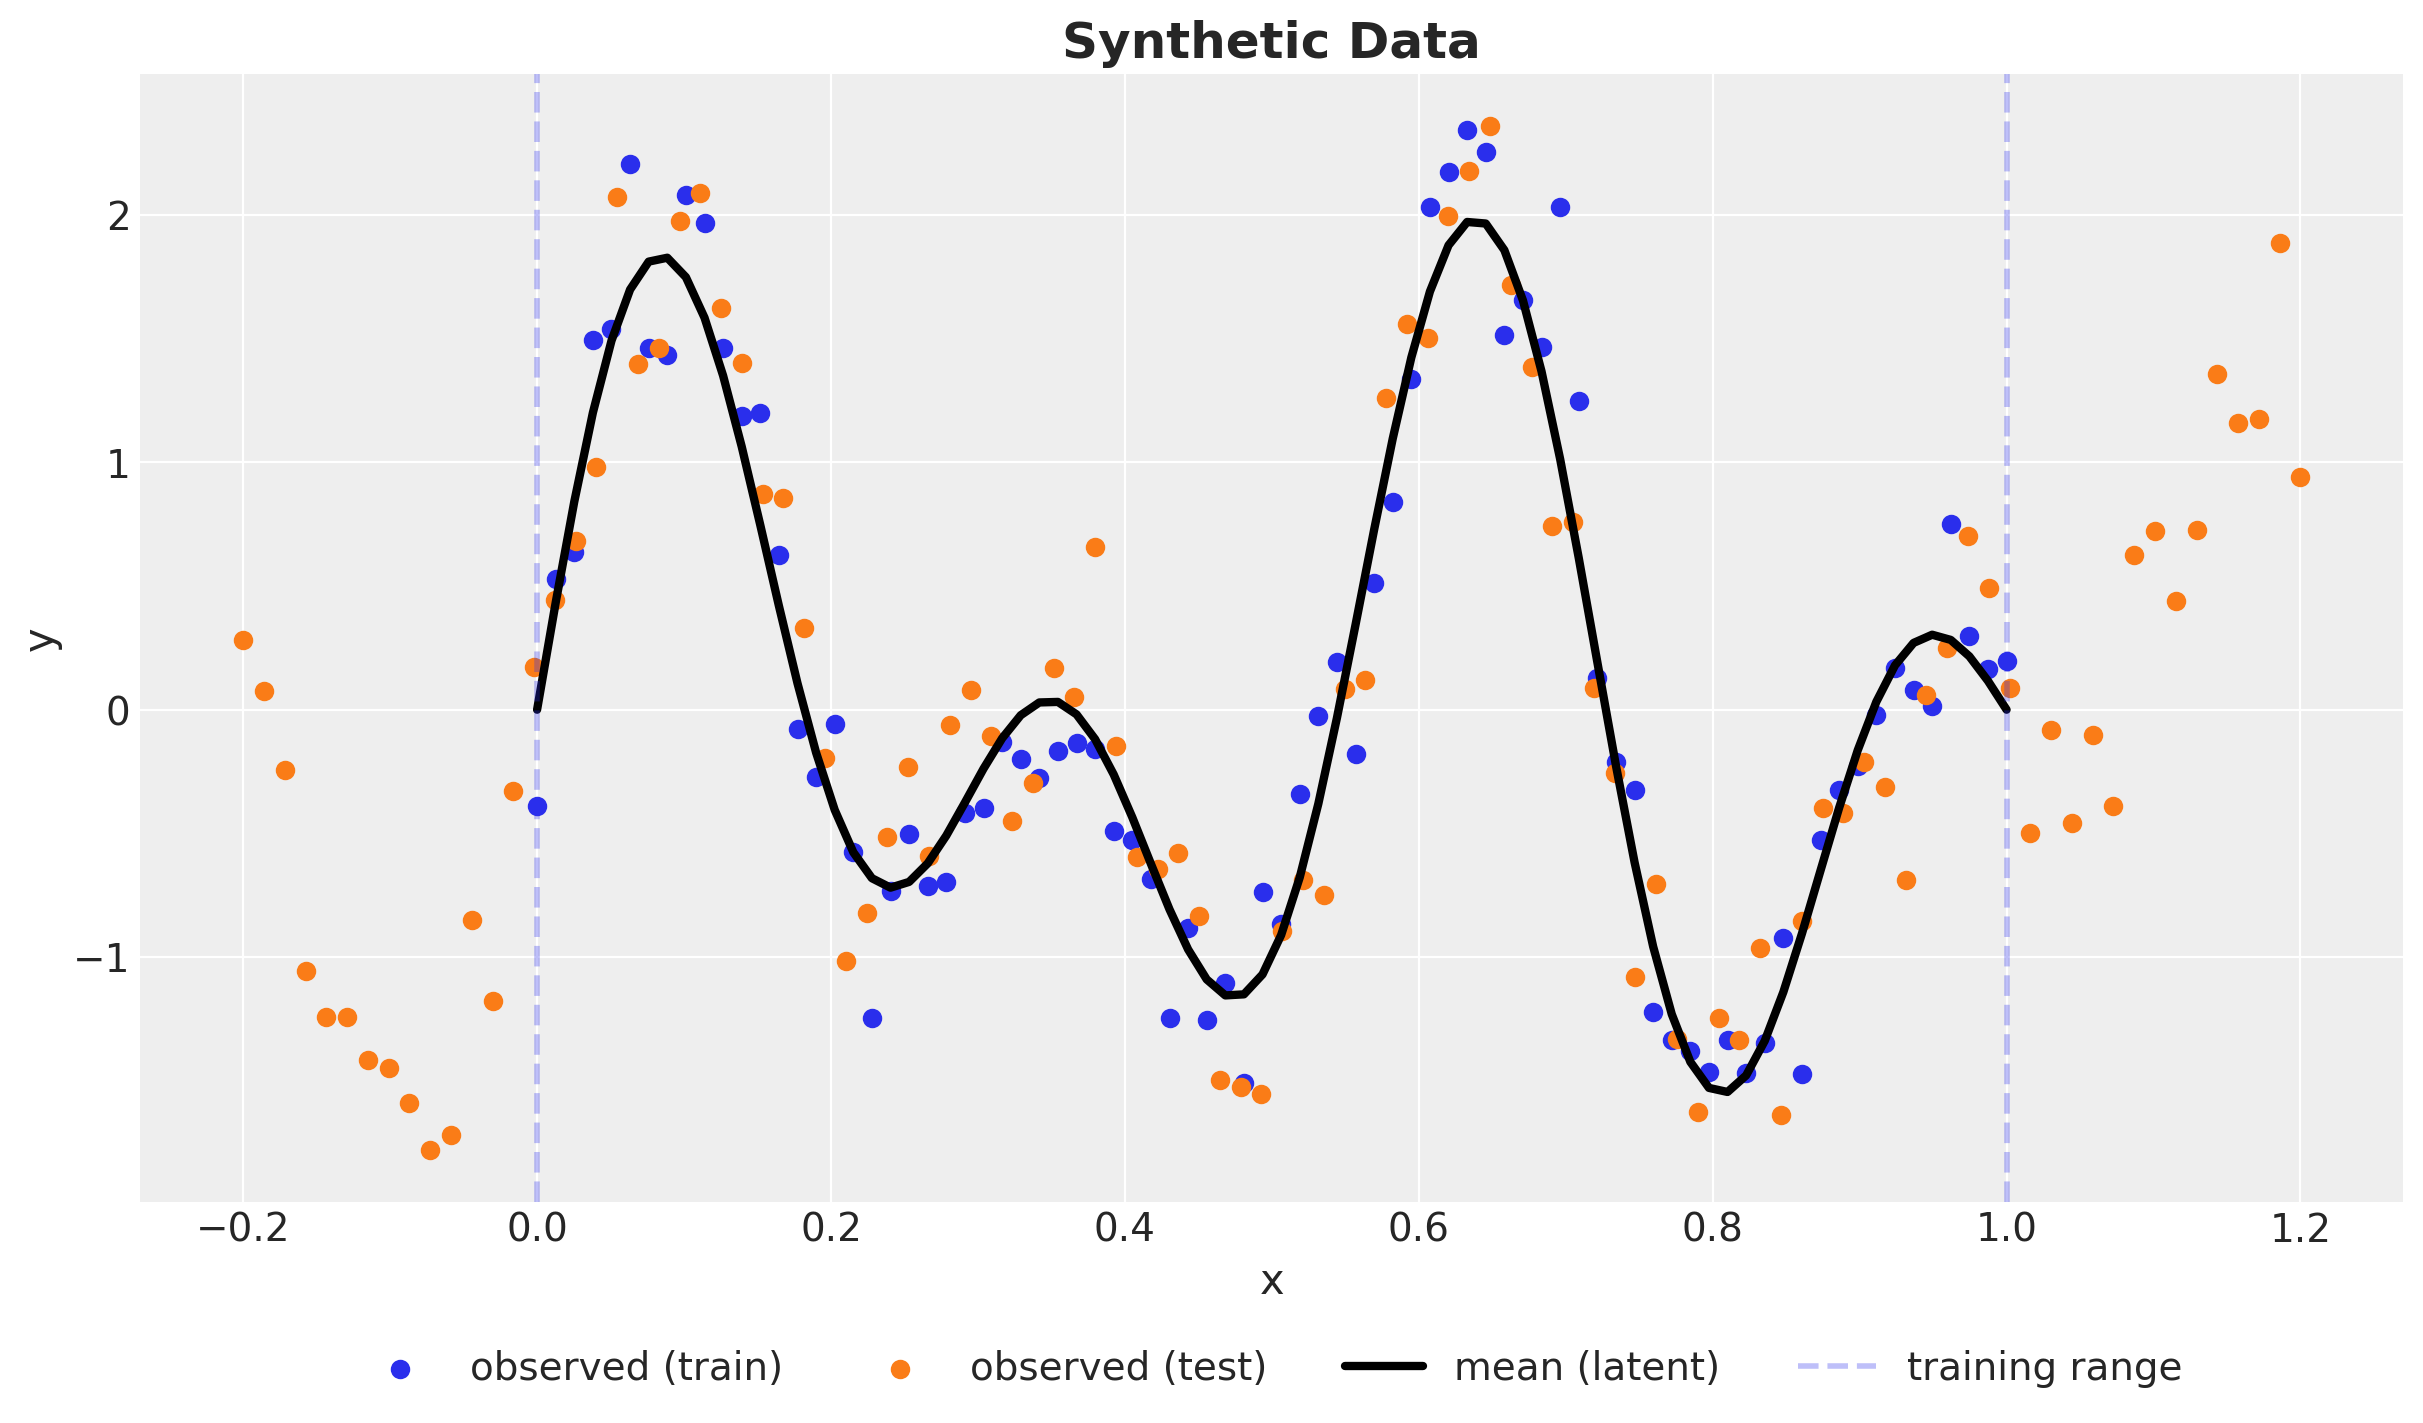

In [3]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.axvline(x=0, color="C0", alpha=0.3, linestyle="--", linewidth=2)
ax.axvline(
    x=1, color="C0", linestyle="--", alpha=0.3, linewidth=2, label="training range"
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Synthetic Data", fontsize=18, fontweight="bold");

---

# Part I: Gaussian Processes (GPs)

In this first part we recall the notion of Gaussian processes and the problem of inference in the context of regression. To showcase the main components of a Gaussian process model, we do it "by hand" using JAX and NumPyro. Afterwards, we show how to use the `GP` module in `PyMC` to generate the same results.

## NumPyro Gaussian Process Model

For the Numpyro implementation, we use the the code from some examples of the tutorial pages:

- [Example: Gaussian Process](https://num.pyro.ai/en/stable/examples/gp.html)
- [Example: Thompson sampling for Bayesian Optimization with GPs](https://num.pyro.ai/en/stable/examples/thompson_sampling.html)

### Kernel Specification

Given the data (and context of the application), we as modelers need to specify a kernel function that captures the structure of the data. The kernel function is a measure of similarity (covariance) between two points in the input space. The most common kernel function is the squared exponential kernel (also known as Gaussian kernel or RBF kernel):

$$
\text{cov}(f_{p}, f_{q}) = k_{a, \ell}(x_p, x_q) = a^{2} \: \exp\left(-\frac{1}{2\ell^2} ||x_p - x_q||^2\right)
$$

This kernel, which depends on two parameters $a$ and $\ell$, will produce smooth functions. The parameter $a$ is the amplitude of the covariance and $\ell$ is the length-scale. The length-scale controls how wiggly the function is. If $\ell$ is large, the function will be very flat , and if $\ell$ is small, the function will be wiggly.

There are many more kernels used in applications. For example:

- We can also use the Matérn kernel, which is a generalization of the squared exponential kernel. The Matérn kernel has an additional parameter $\nu$ that controls the smoothness of the function. The squared exponential kernel is a special case of the Matérn kernel when $\nu \to \infty$.
- Periodic kernel, which is useful for modeling periodic functions.

For a good introduction to kernels, I recommend the example notebook ["Mean and Covariance Functions"](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html) from the PyMC [example gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html). If yoi want to go deeper into the subject then I strongly recommend ["Gaussian Processes for Machine Learning - Chapter 4: Covariance Functions"](https://gaussianprocess.org/gpml/chapters/RW4.pdf) 

**Remark:** The sum of kernels is also a valid kernel. This is useful to model functions that have different scales or periodic components. For example, the kernel $k(x, x') = k_1(x, x') + k_2(x, x')$ is a valid kernel. Also, the product of kernels is a valid kernel. For example, the kernel $k(x, x') = k_1(x, x') \cdot k_2(x, x')$ is a valid kernel.

In [4]:
# https://num.pyro.ai/en/stable/examples/gp.html
def squared_exponential_kernel(
    xp: ArrayImpl, xq: ArrayImpl, amplitude: float, length_scale: float
) -> ArrayImpl:
    r = xp[:, None] - xq[None, :]
    delta = (r / length_scale) ** 2
    return amplitude**2 * jnp.exp(-0.5 * delta)

We can compute the associated kernel matrix for the training data and fixed values for the amplitude and length-scale. The kernel matrix is a matrix $K$ such that $K_{ij} = k(x_i, x_j)$.

In [5]:
kernel = squared_exponential_kernel(x_train, x_train, amplitude=1.0, length_scale=0.1)

One can visualize the kernel matrix as a heatmap to understand the structure of the covariance:

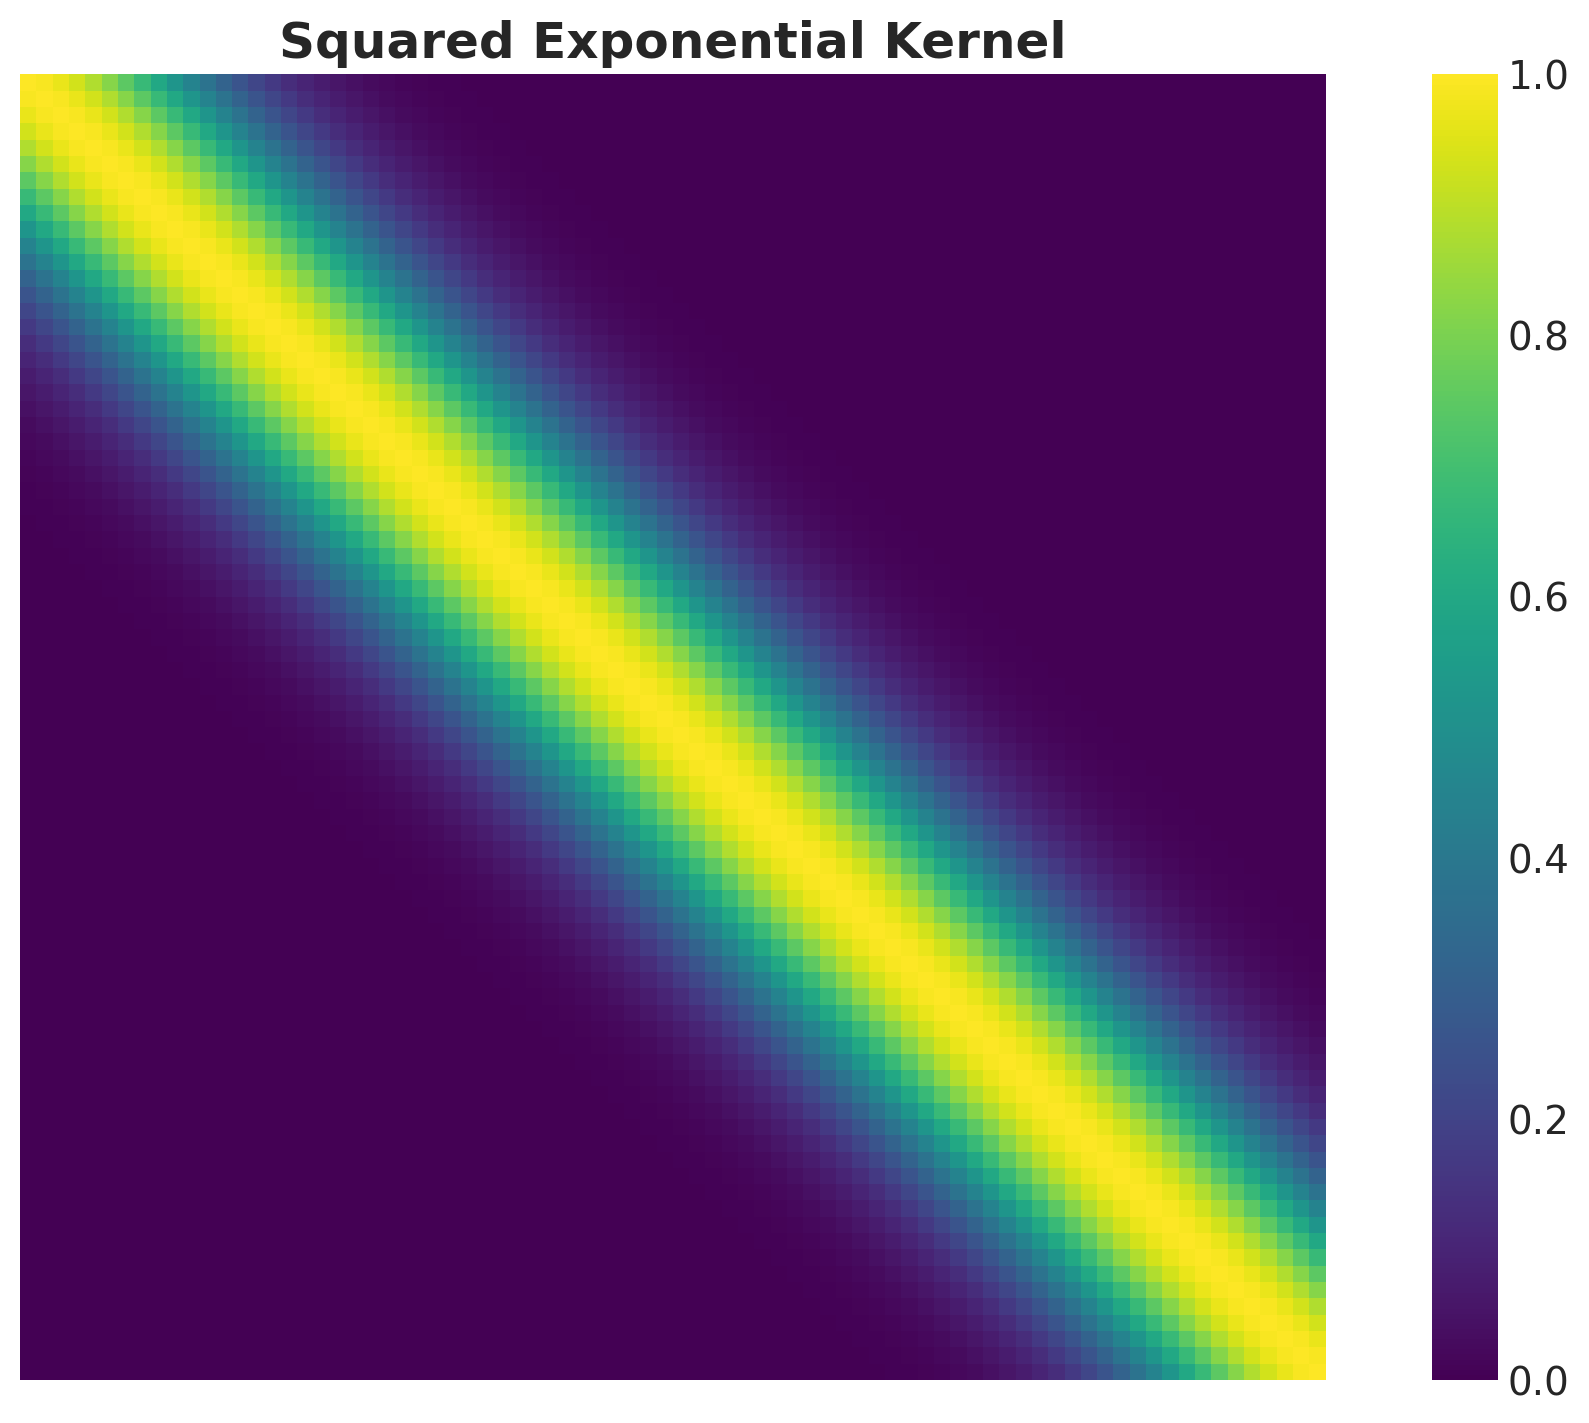

In [6]:
fig, ax = plt.subplots()
sns.heatmap(
    data=kernel,
    square=True,
    cmap="viridis",
    cbar=True,
    xticklabels=False,
    yticklabels=False,
    ax=ax,
)
ax.set_title("Squared Exponential Kernel", fontsize=18, fontweight="bold");

As expected, the kernel matrix is symmetric and the diagonal elements are all equal to $a^2$.

In [7]:
assert (kernel == kernel.T).all().item()
assert (jnp.diag(kernel) == 1).all().item()

The kernel matrices have an additional property: they are positive semi-definite. This means that their eigenvalues are non-negative.

**Remark:** In this notebook we will be talking a lot about the spectrum (eigenvalues and eigenvector) of a matrix / operator. Recall that given a matrix $A$ (or a linear operator) the eigenvalues and eigenvectors are the solutions to the equation $A v = \lambda v$ where $v$ is the eigenvector and $\lambda \neq 0$ is the eigenvalue. The spectrum of a matrix is the set of its eigenvalues. For more details see the blog post ["The Spectral Theorem for Matrices"](https://juanitorduz.github.io/the-spectral-theorem-for-matrices/).

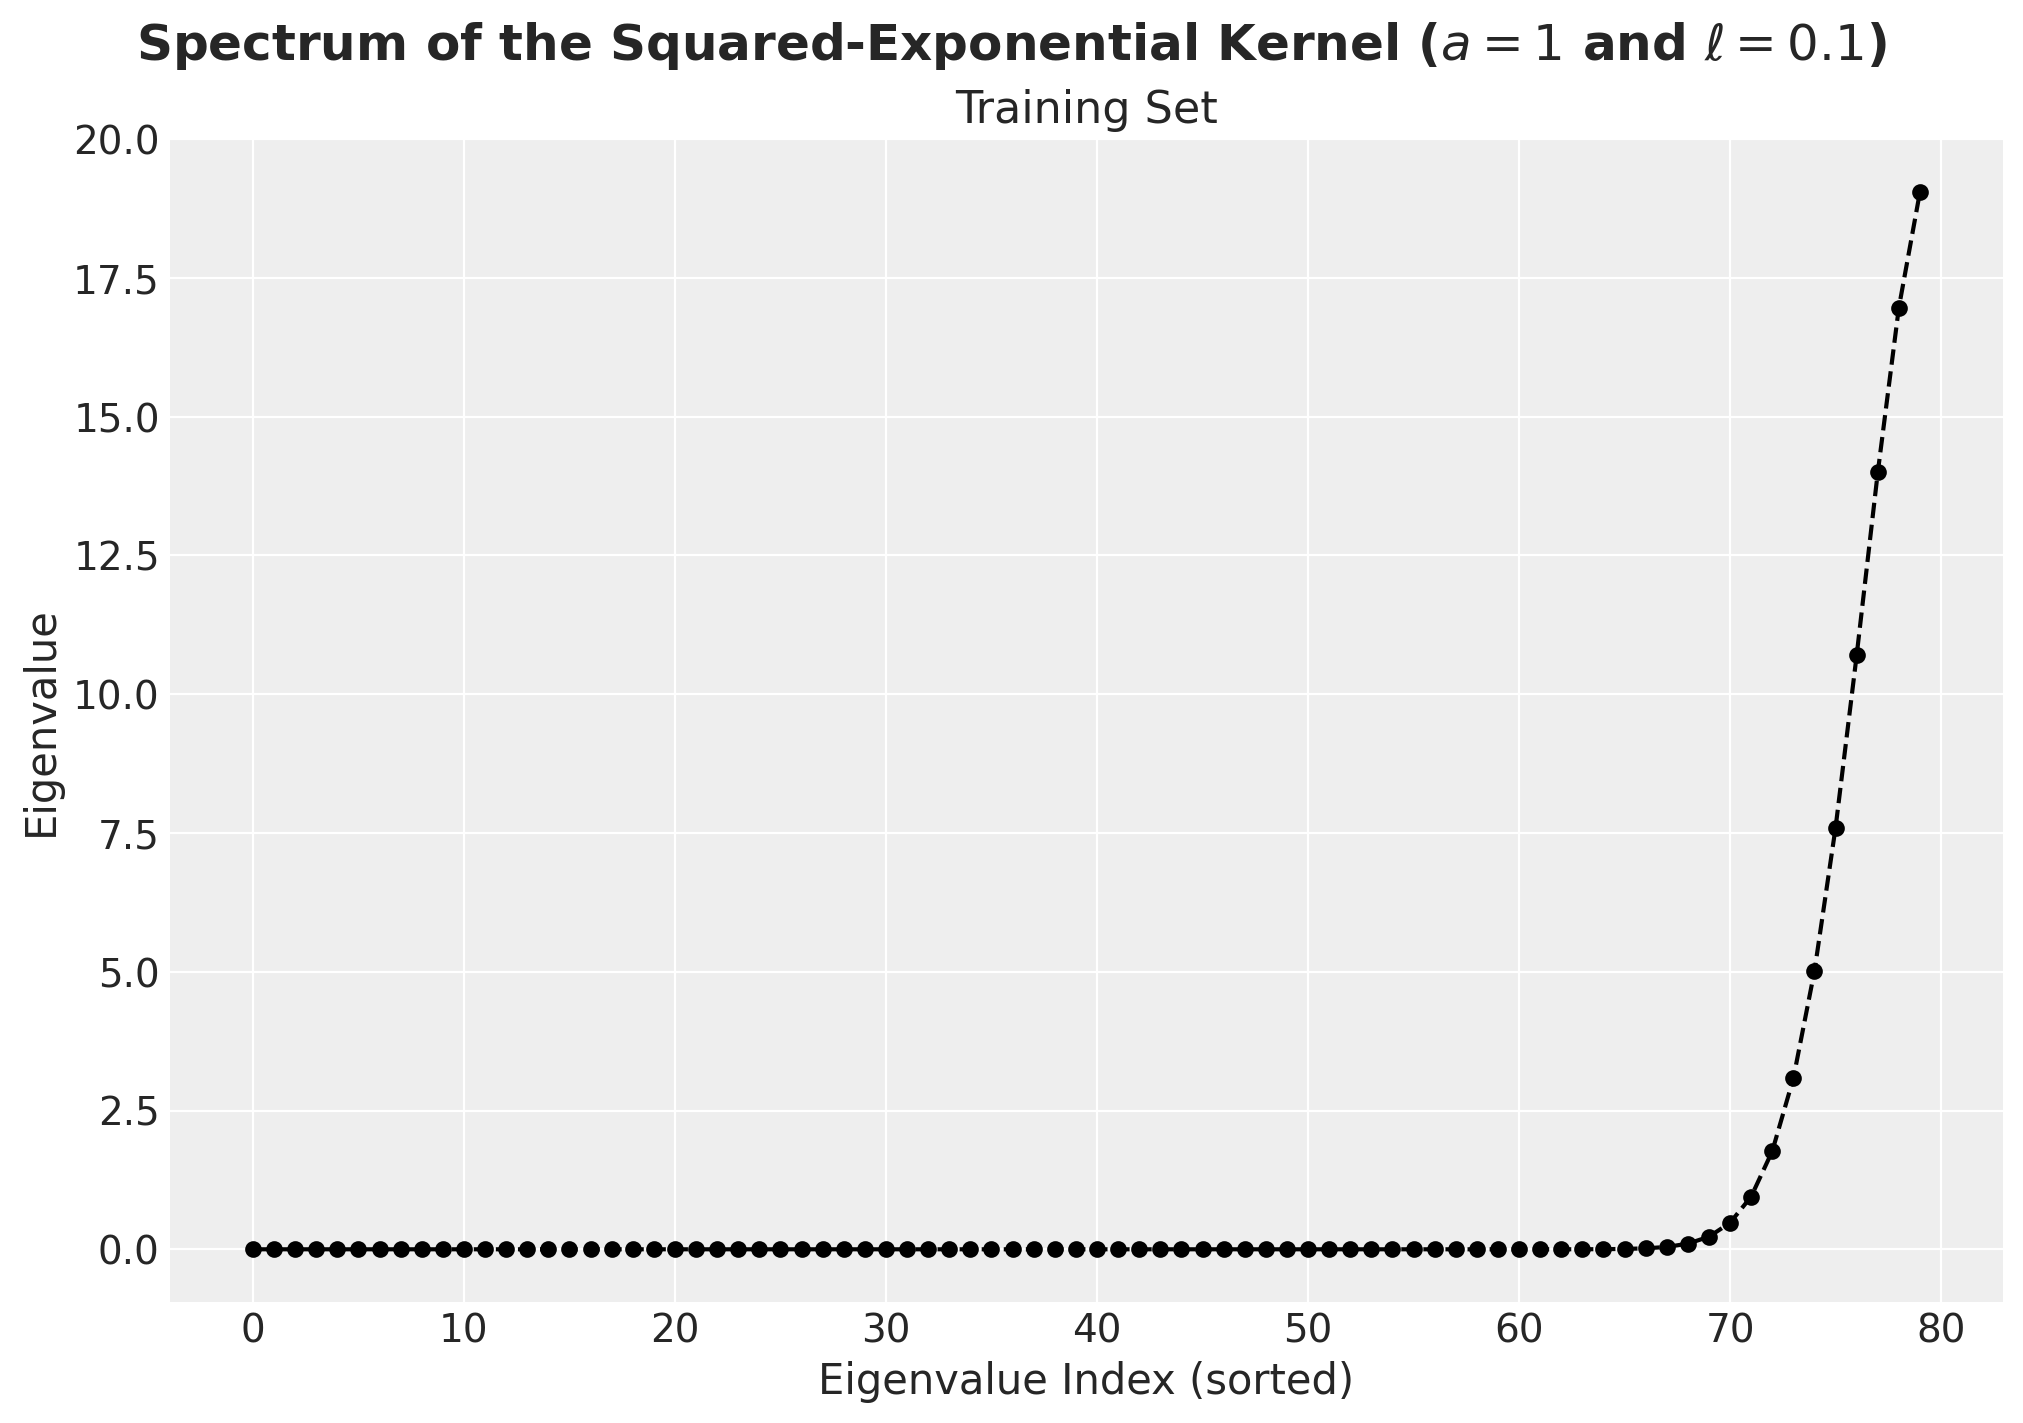

In [8]:
spectrum_kernel = jnp.linalg.eigh(kernel)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(
    spectrum_kernel.eigenvalues, marker="o", markersize=5, linestyle="--", color="black"
)
ax.set(xlabel="Eigenvalue Index (sorted)", ylabel="Eigenvalue")
ax.set_title("Training Set")
fig.suptitle(
    "Spectrum of the Squared-Exponential Kernel ($a=1$ and $\\ell=0.1$)",
    fontsize=18,
    fontweight="bold",
);

We indeed see that all of the eigenvalues are non-negative (up to some numerical error).

### Gaussian Process Model

In this subsection we describe the Gaussian process model. We summarize the main concepts from [Gaussian Processes for Machine Learning, Chapter 2: Regression](https://gaussianprocess.org/gpml/chapters/RW2.pdf). Recall we used the kernel to construct the kernel matrix $K := K((X,X)$ from the training data $X$. We can use this matrix to set the prior distribution over functions. The prior distribution over functions is a multivariate normal distribution with mean zero and covariance matrix $K$. This means that the prior distribution over functions is a distribution over functions such that the value of the function at any finite set of points is jointly Gaussian distributed. If we denote the training set by $X_{*}$ and all related quantities regarding this set by lower start, then the joint distribution of $y$ (observations of the training sets) and $f_{*}$ (latent GP realization on the test set) is given by (see Equation (2.18) in [Gaussian Processes for Machine Learning, Chapter 2: Regression](https://gaussianprocess.org/gpml/chapters/RW2.pdf))

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
\text{MultivariateNormal}(0, \mathcal{K})
$$

where 

$$
\mathcal{K} = 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
$$

Observe that we need to add the term $\sigma^2_n I$ to the upper left component to account for noise. 

As described in our main reference, *to get the posterior distribution over functions we need to restrict this joint
prior distribution to contain only those functions which agree with the observed
data points*, that is, we are interested in computing $f_*|X, y, X_*$. Using the results of [Gaussian Processes for Machine Learning, Appendinx A.2](http://www.gaussianprocess.org/gpml/chapters/RWA.pdf), one can show that (see Equation (2.19) in [Gaussian Processes for Machine Learning, Chapter 2: Regression](https://gaussianprocess.org/gpml/chapters/RW2.pdf))


$$
f_*|X, y, X_* 
\sim
\text{MultivariateNormal}(\bar{f}_*, \text{cov}(f_*))
$$

where 

$$
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y \in \mathbb{R}^{n_*}
$$

and 

$$
\text{cov}(f_*) = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*) \in M_{n_*}(\mathbb{R})
$$

For the NumPyro implementation, we will use these expressions to sample from the posterior distribution over functions on the train and test sets. Note that we are assuming we know the parameters of the kernel function. In practice, we need to infer these parameters from the data. We will discuss this in the next sections.

### Parameter Priors

After having a better understanding of the Gaussian process model, we can now proceed to the computational aspects of the model. We need to specify priors for the parameters of the kernel function. This is a huge topic! (see the great blog post ["Priors for the parameters in a Gaussian process"](https://dansblog.netlify.app/posts/2022-09-07-priors5/priors5.html) by [Dan Simpson](https://dansblog.netlify.app/)). A common choice for the length-scale and amplitude parameters is to use an [inverse-gamma distribution](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) as it is positive and drops to zero for values close to zero (this help us to avoid dividing by zero). We expect different ranges for length-scale and amplitude parameters since he former controls the smoothness of the function and the latter the amplitude of the covariance. We can use the function [`pm.find_constrained_prior`](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.find_constrained_prior.html) to find *optimal* parameters of the inverse-gamma distribution that align to our believes of the parameters given the data (e.g. plot). In addition, we can use [`preliz`](https://github.com/arviz-devs/preliz) to visualize the resulting prior distributions.

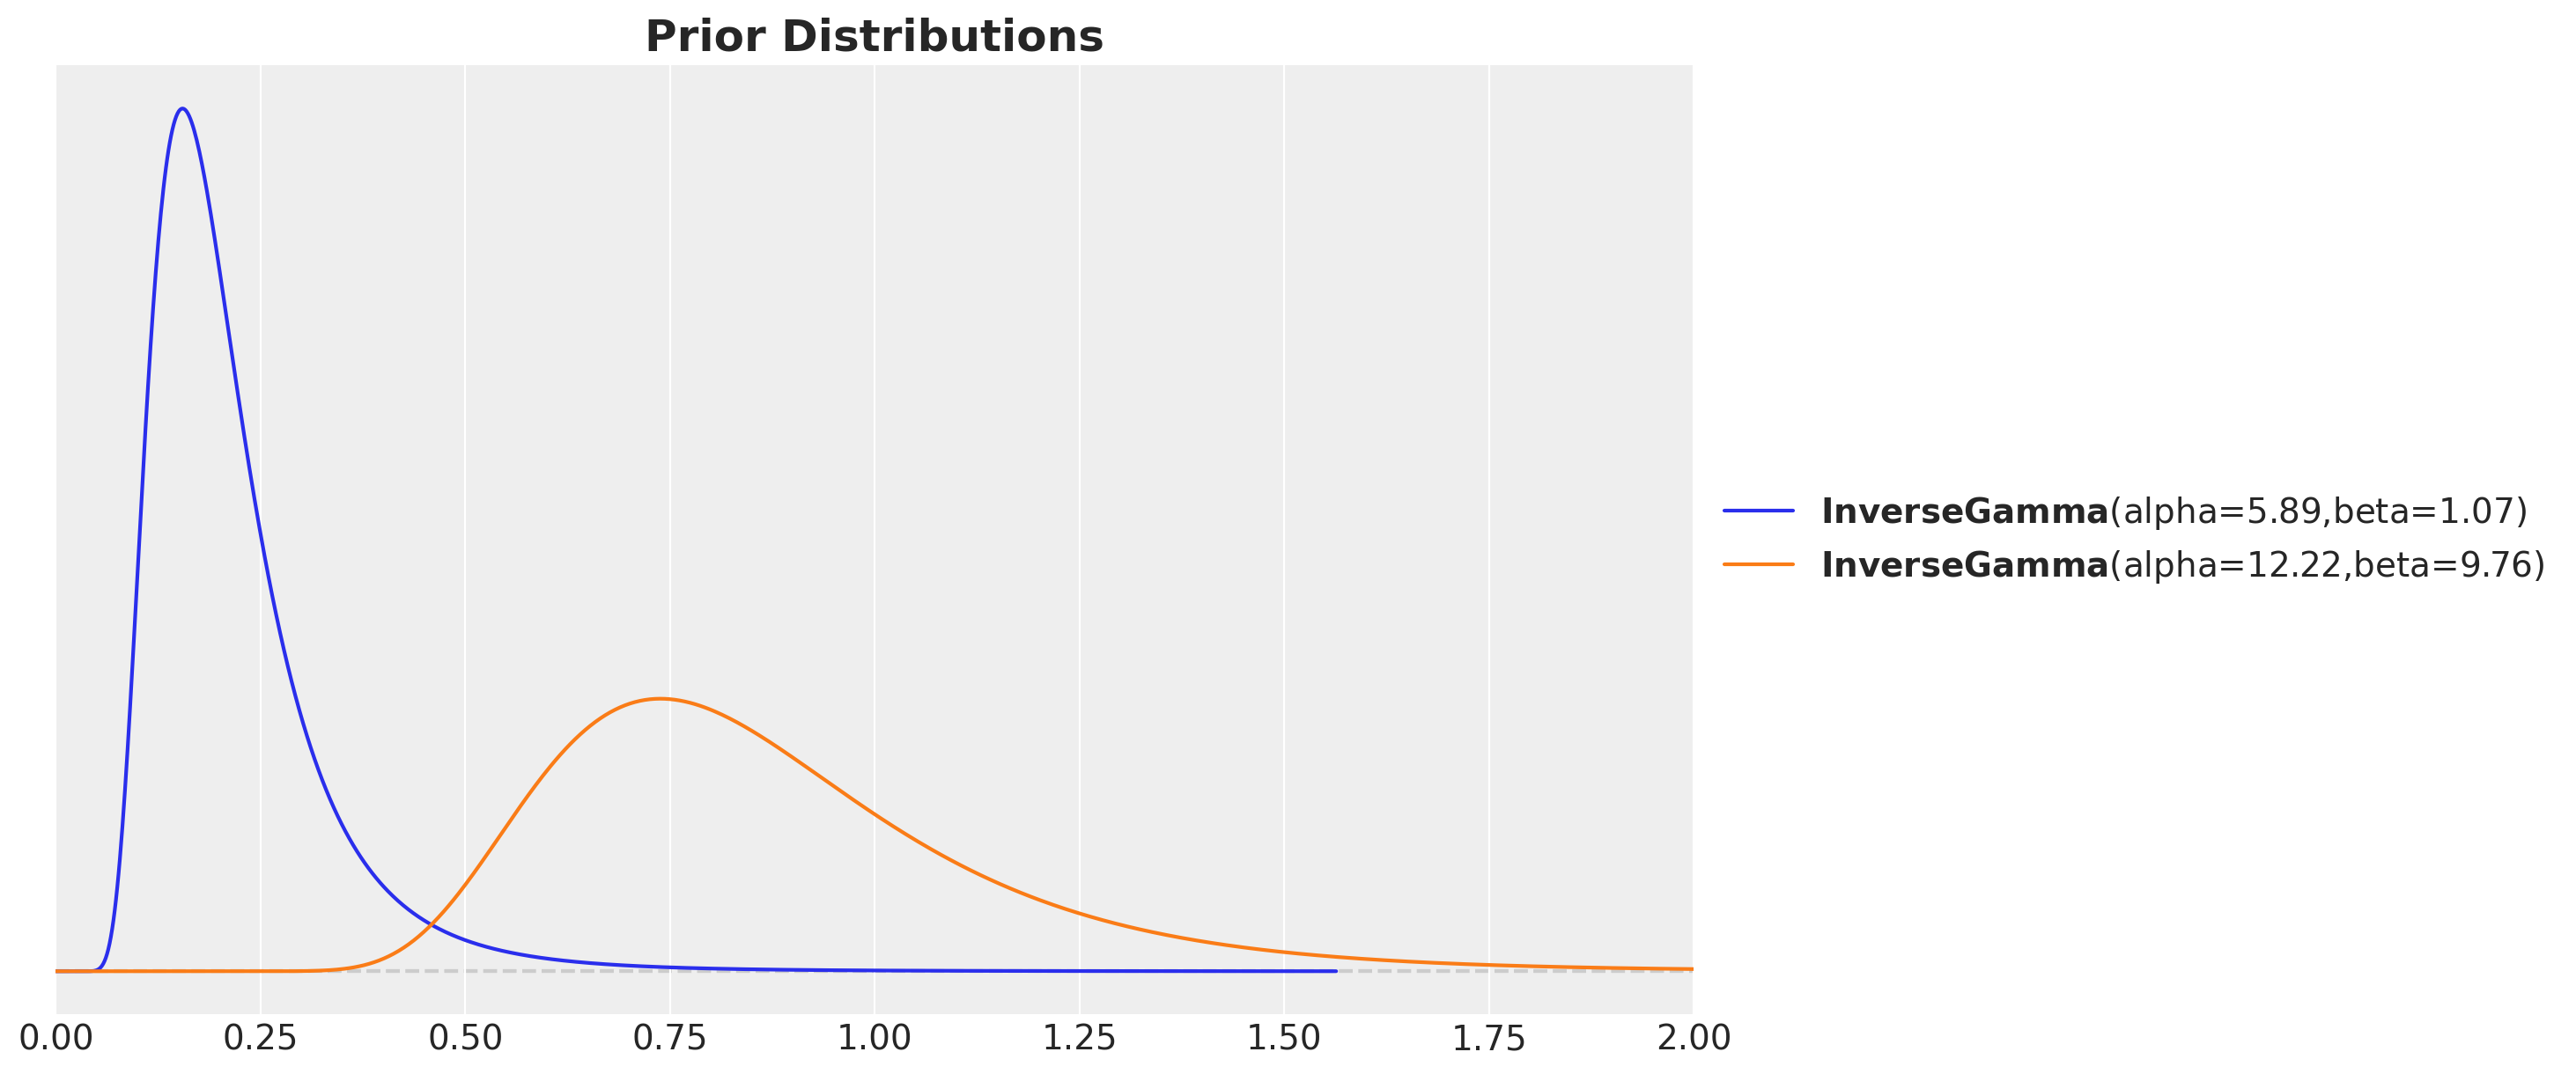

In [9]:
inverse_gamma_params_1 = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=0.01,
    upper=0.4,
    init_guess={"alpha": 5, "beta": 3},
    mass=0.94,
)
inverse_gamma_params_2 = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=0.5,
    upper=1.5,
    init_guess={"alpha": 5, "beta": 6},
    mass=0.94,
)

fig, ax = plt.subplots()
pz.InverseGamma(**inverse_gamma_params_1).plot_pdf(color="C0", ax=ax)
pz.InverseGamma(**inverse_gamma_params_2).plot_pdf(color="C1", ax=ax)
ax.set(xlim=(0, 2))
ax.set_title("Prior Distributions", fontsize=18, fontweight="bold");

**Remark:** In this example we use the same priors for the amplitude and noise parameters as it is well suited for the synthetic data. In practice, we would need to use different priors for these parameters.

### Model Specification

We now specify the model as described above: we use the kernel function to compute the kernel matrix and then use this matrix to set the prior distribution over functions as a multivariate normal distribution.

In [10]:
def gp_model(x, y=None, jitter=1.0e-6) -> None:
    # --- Priors ---
    kernel_amplitude = numpyro.sample(
        "kernel_amplitude",
        dist.InverseGamma(
            concentration=inverse_gamma_params_2["alpha"],
            rate=inverse_gamma_params_2["beta"],
        ),
    )
    kernel_length_scale = numpyro.sample(
        "kernel_length_scale",
        dist.InverseGamma(
            concentration=inverse_gamma_params_1["alpha"],
            rate=inverse_gamma_params_1["beta"],
        ),
    )
    noise = numpyro.sample(
        "noise",
        dist.InverseGamma(
            concentration=inverse_gamma_params_2["alpha"],
            rate=inverse_gamma_params_2["beta"],
        ),
    )
    # --- Parametrization ---
    mean = jnp.zeros(x.shape[0])
    kernel = squared_exponential_kernel(x, x, kernel_amplitude, kernel_length_scale)
    covariance_matrix = kernel + (noise + jitter) * jnp.eye(x.shape[0])
    # --- Likelihood ---
    numpyro.sample(
        "likelihood",
        dist.MultivariateNormal(loc=mean, covariance_matrix=covariance_matrix),
        obs=y,
    )

We can visualize the model representation in [plate notation](https://en.wikipedia.org/wiki/Plate_notation):

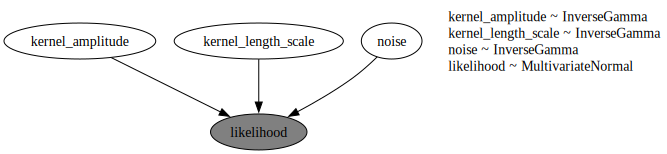

In [11]:
numpyro.render_model(
    model=gp_model,
    model_args=(x_train, y_train_obs),
    render_distributions=True,
    render_params=True,
)

### Prior Predictive Check

Before fitting the model to the data, we can use the model above to generate samples from the prior distribution over functions. This will help us to understand the behavior of the model before seeing the data.

In [12]:
gp_numpyro_prior_predictive = Predictive(gp_model, num_samples=1_000)
rng_key, rng_subkey = random.split(rng_key)
gp_numpyro_prior_samples = gp_numpyro_prior_predictive(rng_subkey, x_train)

gp_numpyro_prior_idata = az.from_numpyro(prior=gp_numpyro_prior_samples)

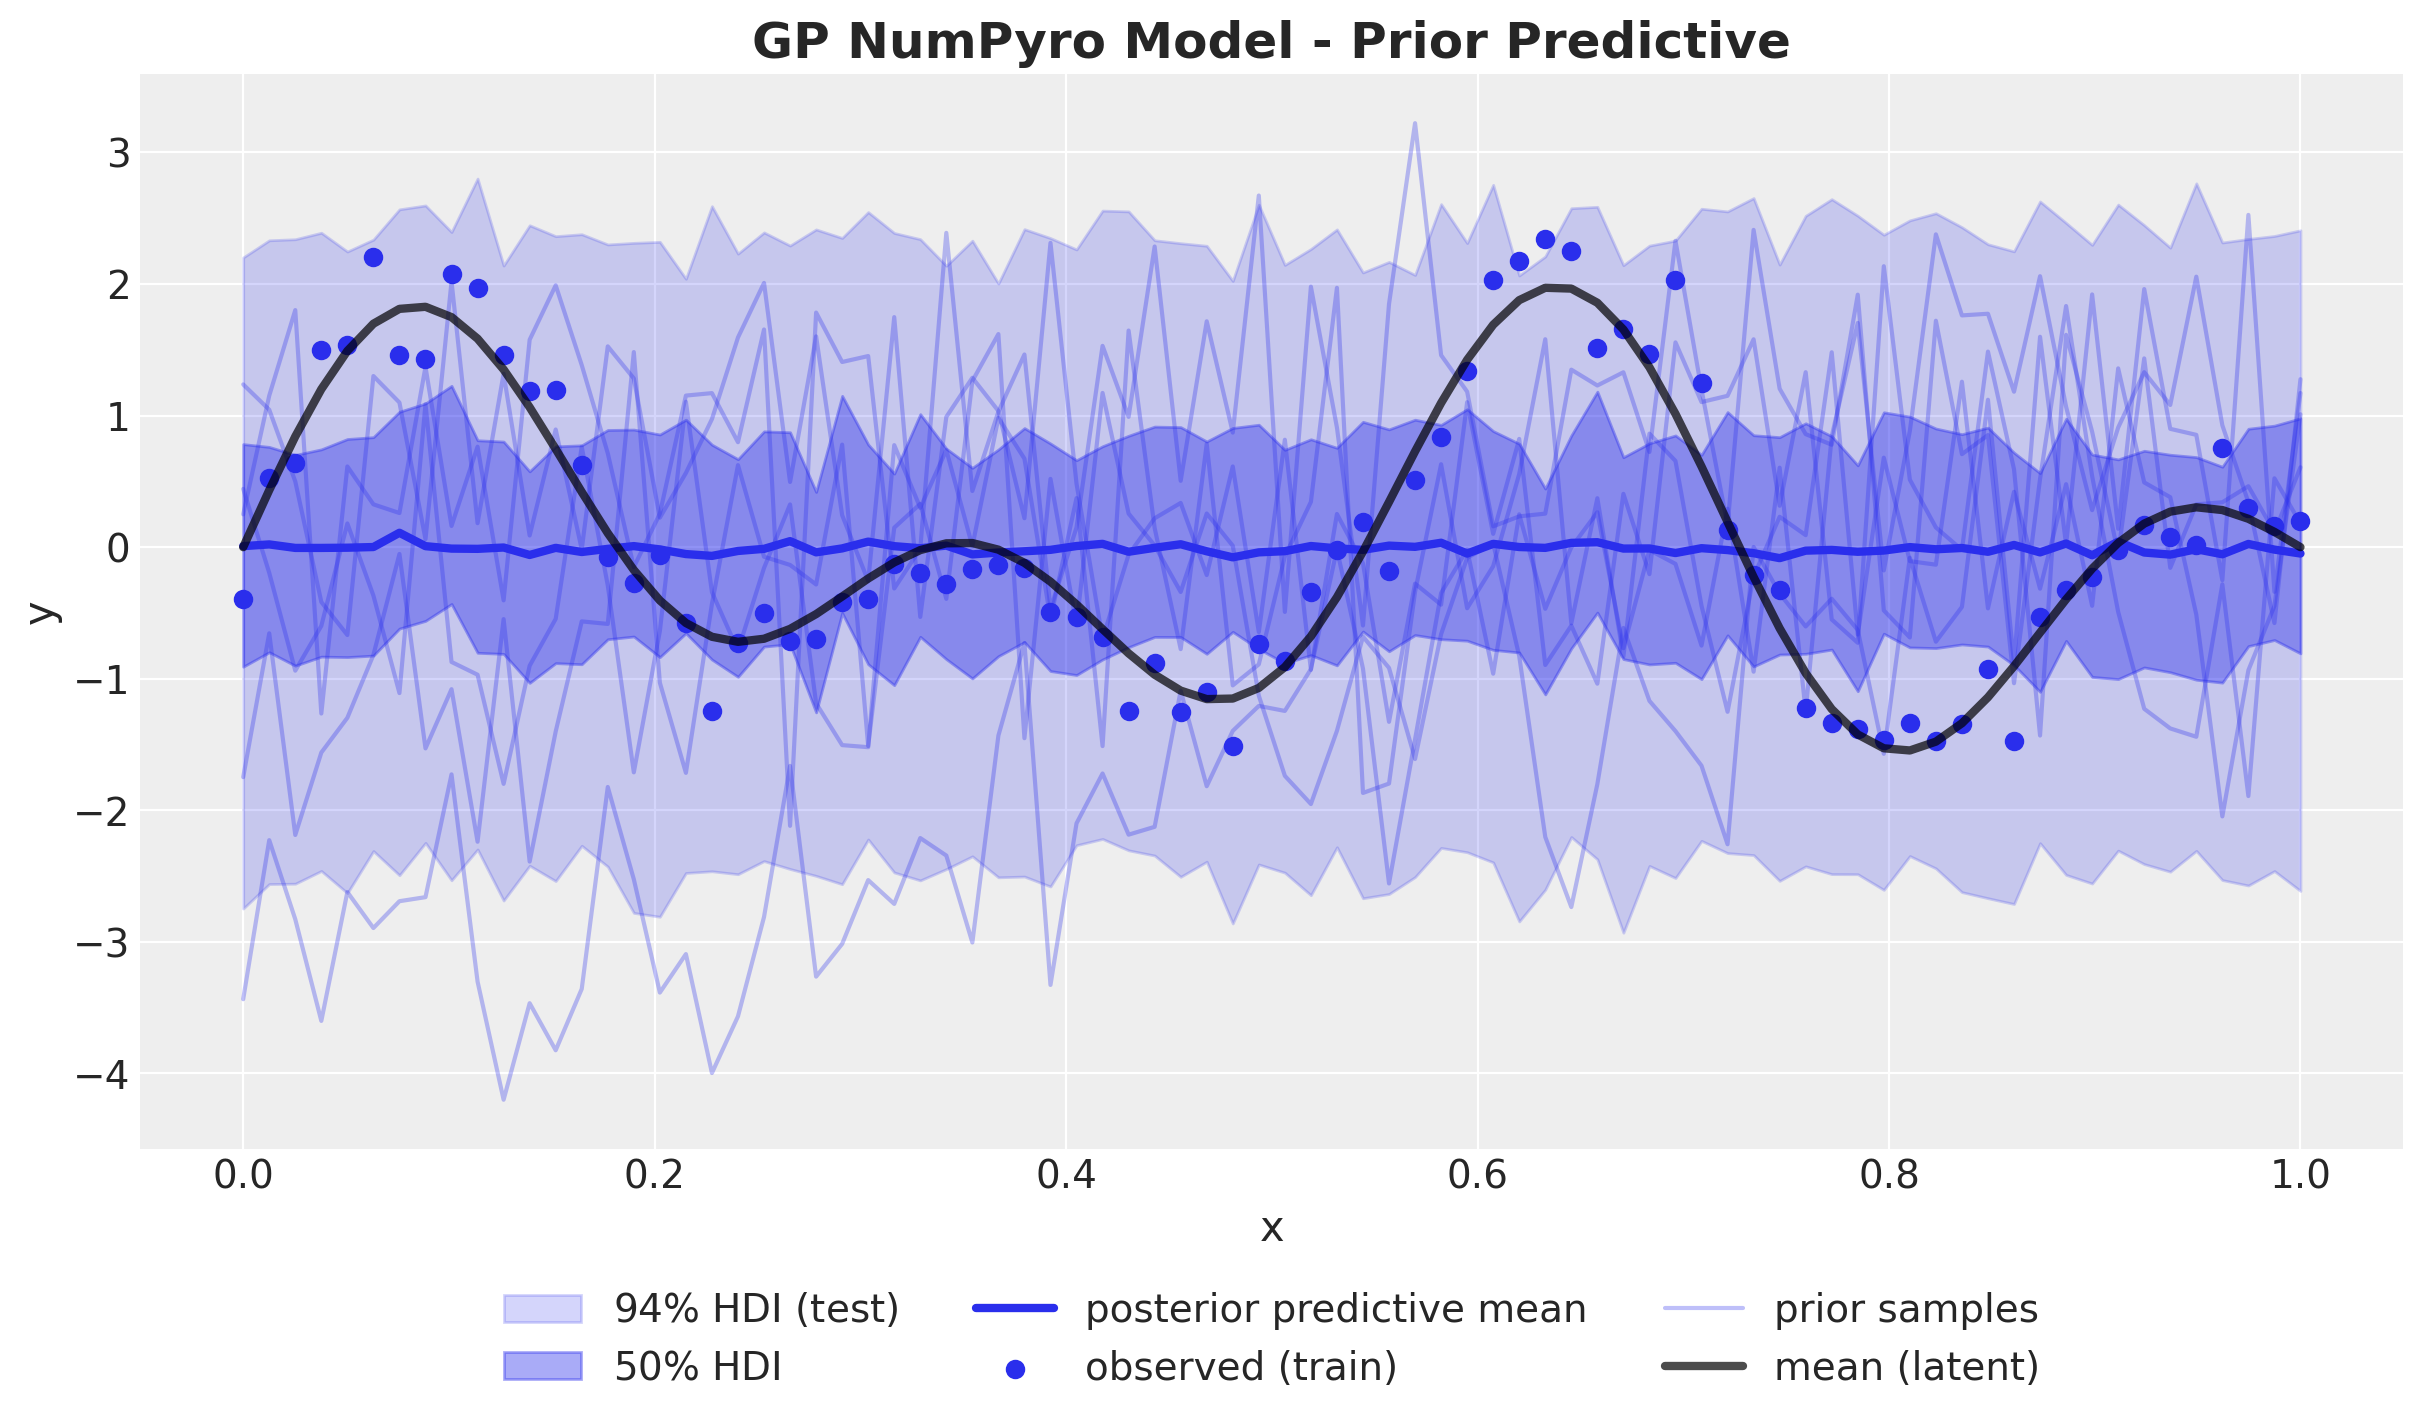

In [13]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_train,
    gp_numpyro_prior_idata.prior["likelihood"],
    hdi_prob=0.94,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_train,
    gp_numpyro_prior_idata.prior["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.plot(
    x_train,
    gp_numpyro_prior_idata.prior["likelihood"].mean(dim=("chain", "draw")),
    color="C0",
    linewidth=3,
    label="posterior predictive mean",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
for i in range(5):
    label = "prior samples" if i == 0 else None
    ax.plot(
        x_train,
        gp_numpyro_prior_idata.prior["likelihood"].sel(chain=0, draw=i),
        color="C0",
        alpha=0.3,
        label=label,
    )
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Prior Predictive", fontsize=18, fontweight="bold");

Wee see that the generated functions (range and smoothness) are reasonable candidates for the true function. Hence, we can proceed to fit the model to the data.

### Model Fitting

We define some helper objects to fit the model to the data so that we can reuse them later.

In [14]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc


inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
gp_mcmc = run_inference(rng_subkey, gp_model, inference_params, x_train, y_train_obs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

### Model Diagnostics

The model samples quite fast! We can now look into the posterior distributions and model diagnostics:

In [15]:
gp_numpyro_idata = az.from_numpyro(posterior=gp_mcmc)

az.summary(data=gp_numpyro_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel_amplitude     1.190  0.267   0.729    1.672      0.004    0.003   
kernel_length_scale  0.089  0.011   0.069    0.109      0.000    0.000   
noise                0.278  0.043   0.204    0.359      0.001    0.000   

                     ess_bulk  ess_tail  r_hat  
kernel_amplitude       5426.0    4562.0    1.0  
kernel_length_scale    5004.0    4967.0    1.0  
noise                  5928.0    4826.0    1.0

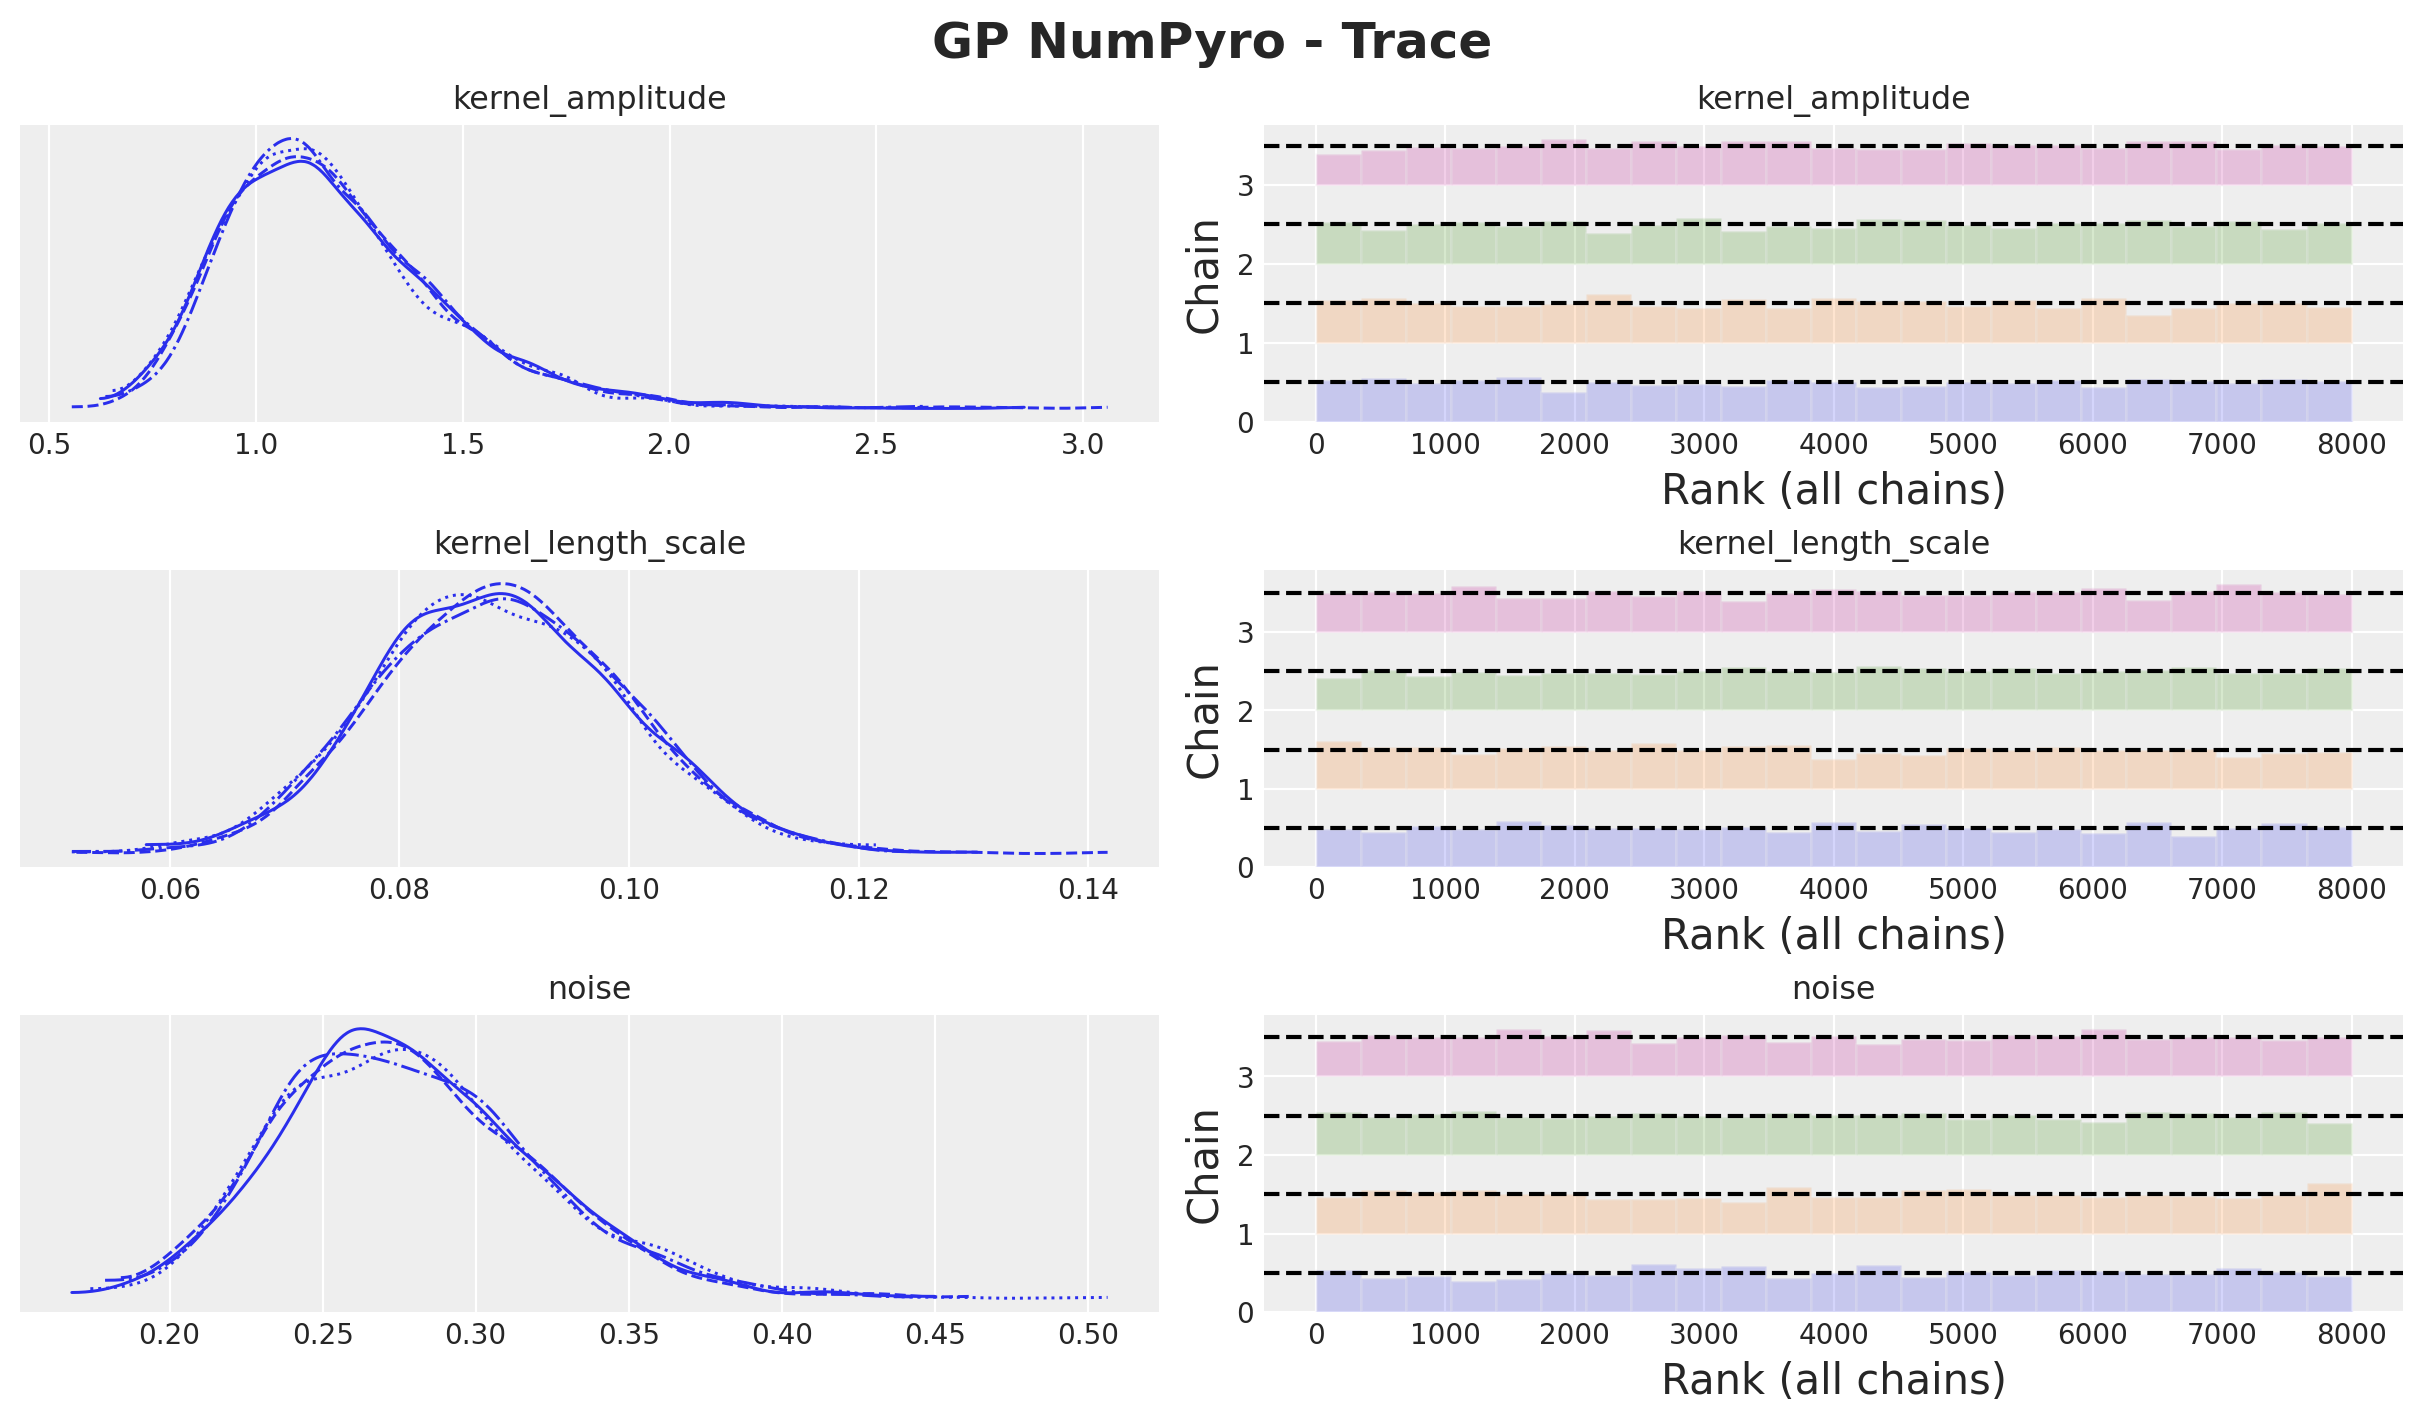

In [16]:
axes = az.plot_trace(
    data=gp_numpyro_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP NumPyro - Trace", fontsize=18, fontweight="bold");

Everything looks good! We are ready to generate predictions for the test set.

### Out of Sample Prediction

Recall from the Gaussian model description that we can generate samples on the test set as:

$$
f_*|X, y, X_* 
\sim
\text{MultivariateNormal}(\bar{f}_*, \text{cov}(f_*))
$$

where 

$$
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y 
$$

and 

$$
\text{cov}(f_*) = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*)
$$

We now simply write these expressions in JAX code:

In [17]:
def get_kernel_matrices_train_test(
    kernel, x, x_test, noise, jitter=1.0e-6, **kernel_kwargs
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    k = kernel(x, x, **kernel_kwargs) + (noise + jitter) * jnp.eye(x.shape[0])
    k_star = kernel(x_test, x, **kernel_kwargs)
    k_star_star = kernel(x_test, x_test, **kernel_kwargs) + (noise + jitter) * jnp.eye(
        x_test.shape[0]
    )
    return k, k_star, k_star_star


def sample_test(rng_key, kernel, x, y, x_test, noise, jitter=1.0e-6, **kernel_kwargs):
    k, k_star, k_star_star = get_kernel_matrices_train_test(
        kernel, x, x_test, noise, jitter, **kernel_kwargs
    )
    k_inv = jnp.linalg.inv(k)
    mean_star = k_star @ (k_inv @ y)
    cov_star = k_star_star - (k_star @ k_inv @ k_star.T)
    return random.multivariate_normal(rng_key, mean=mean_star, cov=cov_star)

We now [`vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) (i.e. paralellize) these functions to generate samples from the posterior distribution over functions on the test set. 

In [18]:
rng_key, rng_subkey = random.split(rng_key)

vmap_args = (
    random.split(
        rng_subkey, inference_params.num_samples * inference_params.num_chains
    ),
    gp_mcmc.get_samples()["noise"],
    gp_mcmc.get_samples()["kernel_amplitude"],
    gp_mcmc.get_samples()["kernel_length_scale"],
)

posterior_predictive_test = vmap(
    lambda rng_key, noise, amplitude, length_scale: sample_test(
        rng_key,
        squared_exponential_kernel,
        x_train,
        y_train_obs,
        x_test,
        noise,
        amplitude=amplitude,
        length_scale=length_scale,
    ),
)(*vmap_args)

gp_numpyro_idata.extend(
    az.from_dict(
        posterior_predictive={
            "y_pred_test": posterior_predictive_test[None, ...],
        },
        coords={"x": x_test},
        dims={"y_pred_test": ["x"]},
    )
)

Here is the final result:

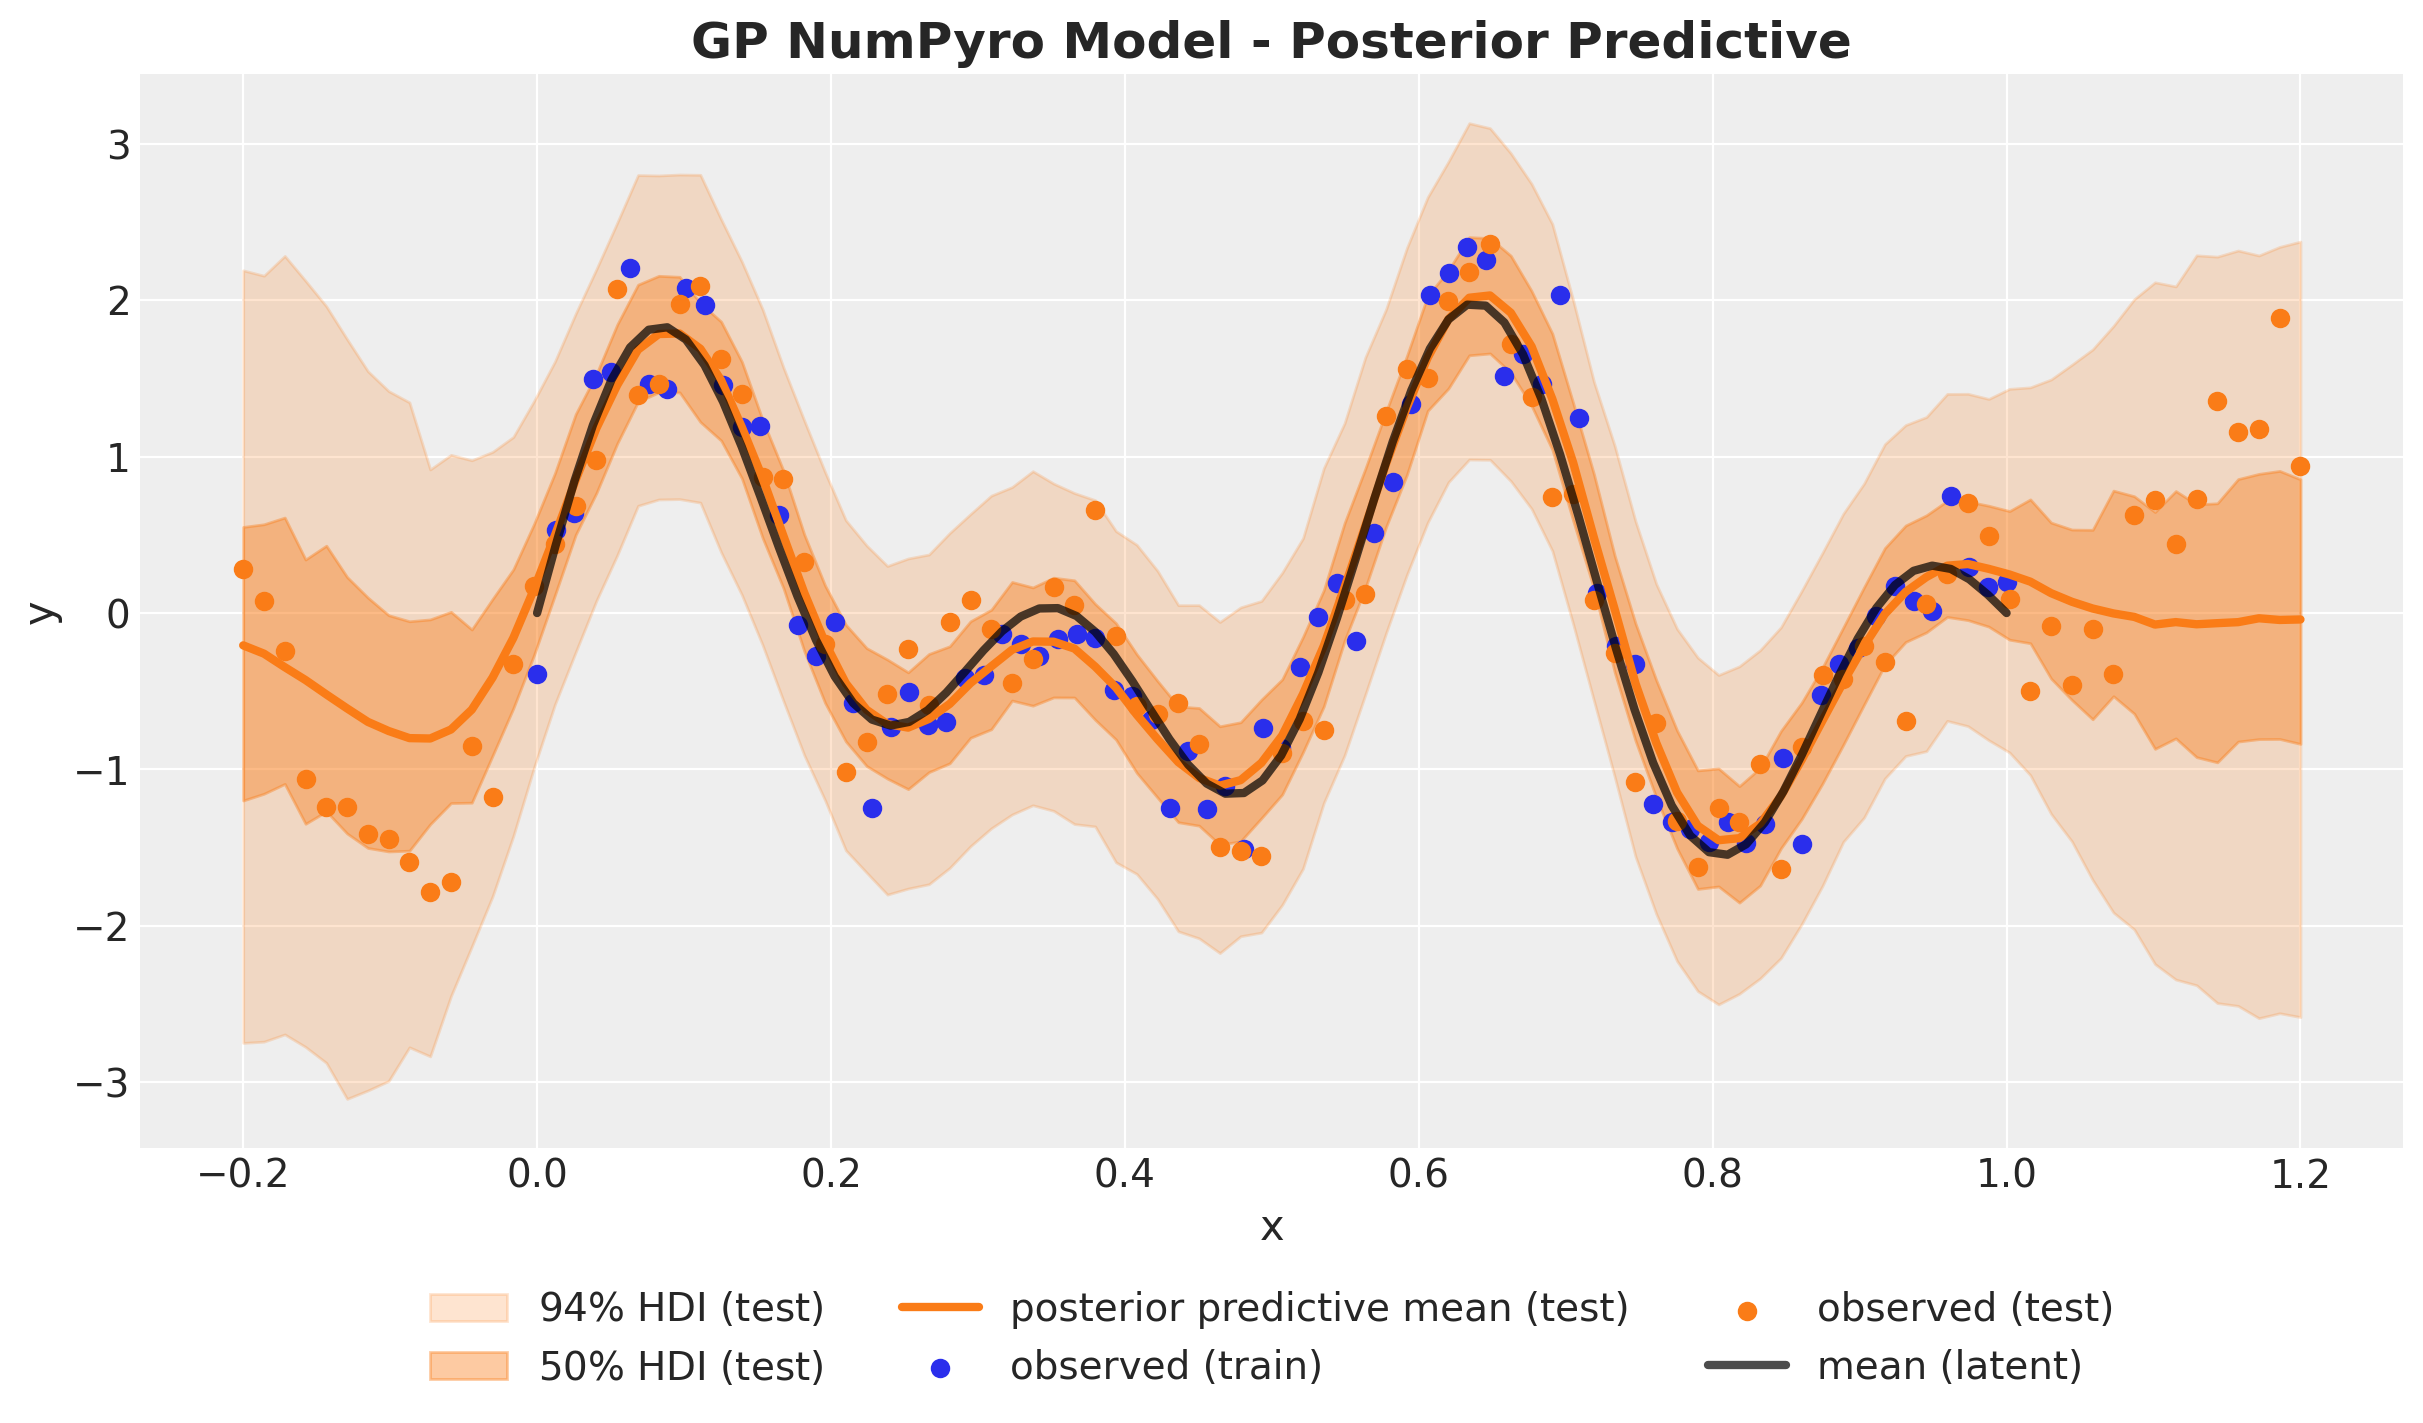

In [19]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Posterior Predictive", fontsize=18, fontweight="bold");

It looks very good 🚀!  The in-sample fit captures very well the latent Gaussian process mean (black line). The out of sample also works well close to the boundaries (note how the uncertainty grows as we get far away from the training space, as expected). In the following plot we add indicators of one length scale the posterior distribution shift from the boundaries, until where we expect the model to work relatively well.

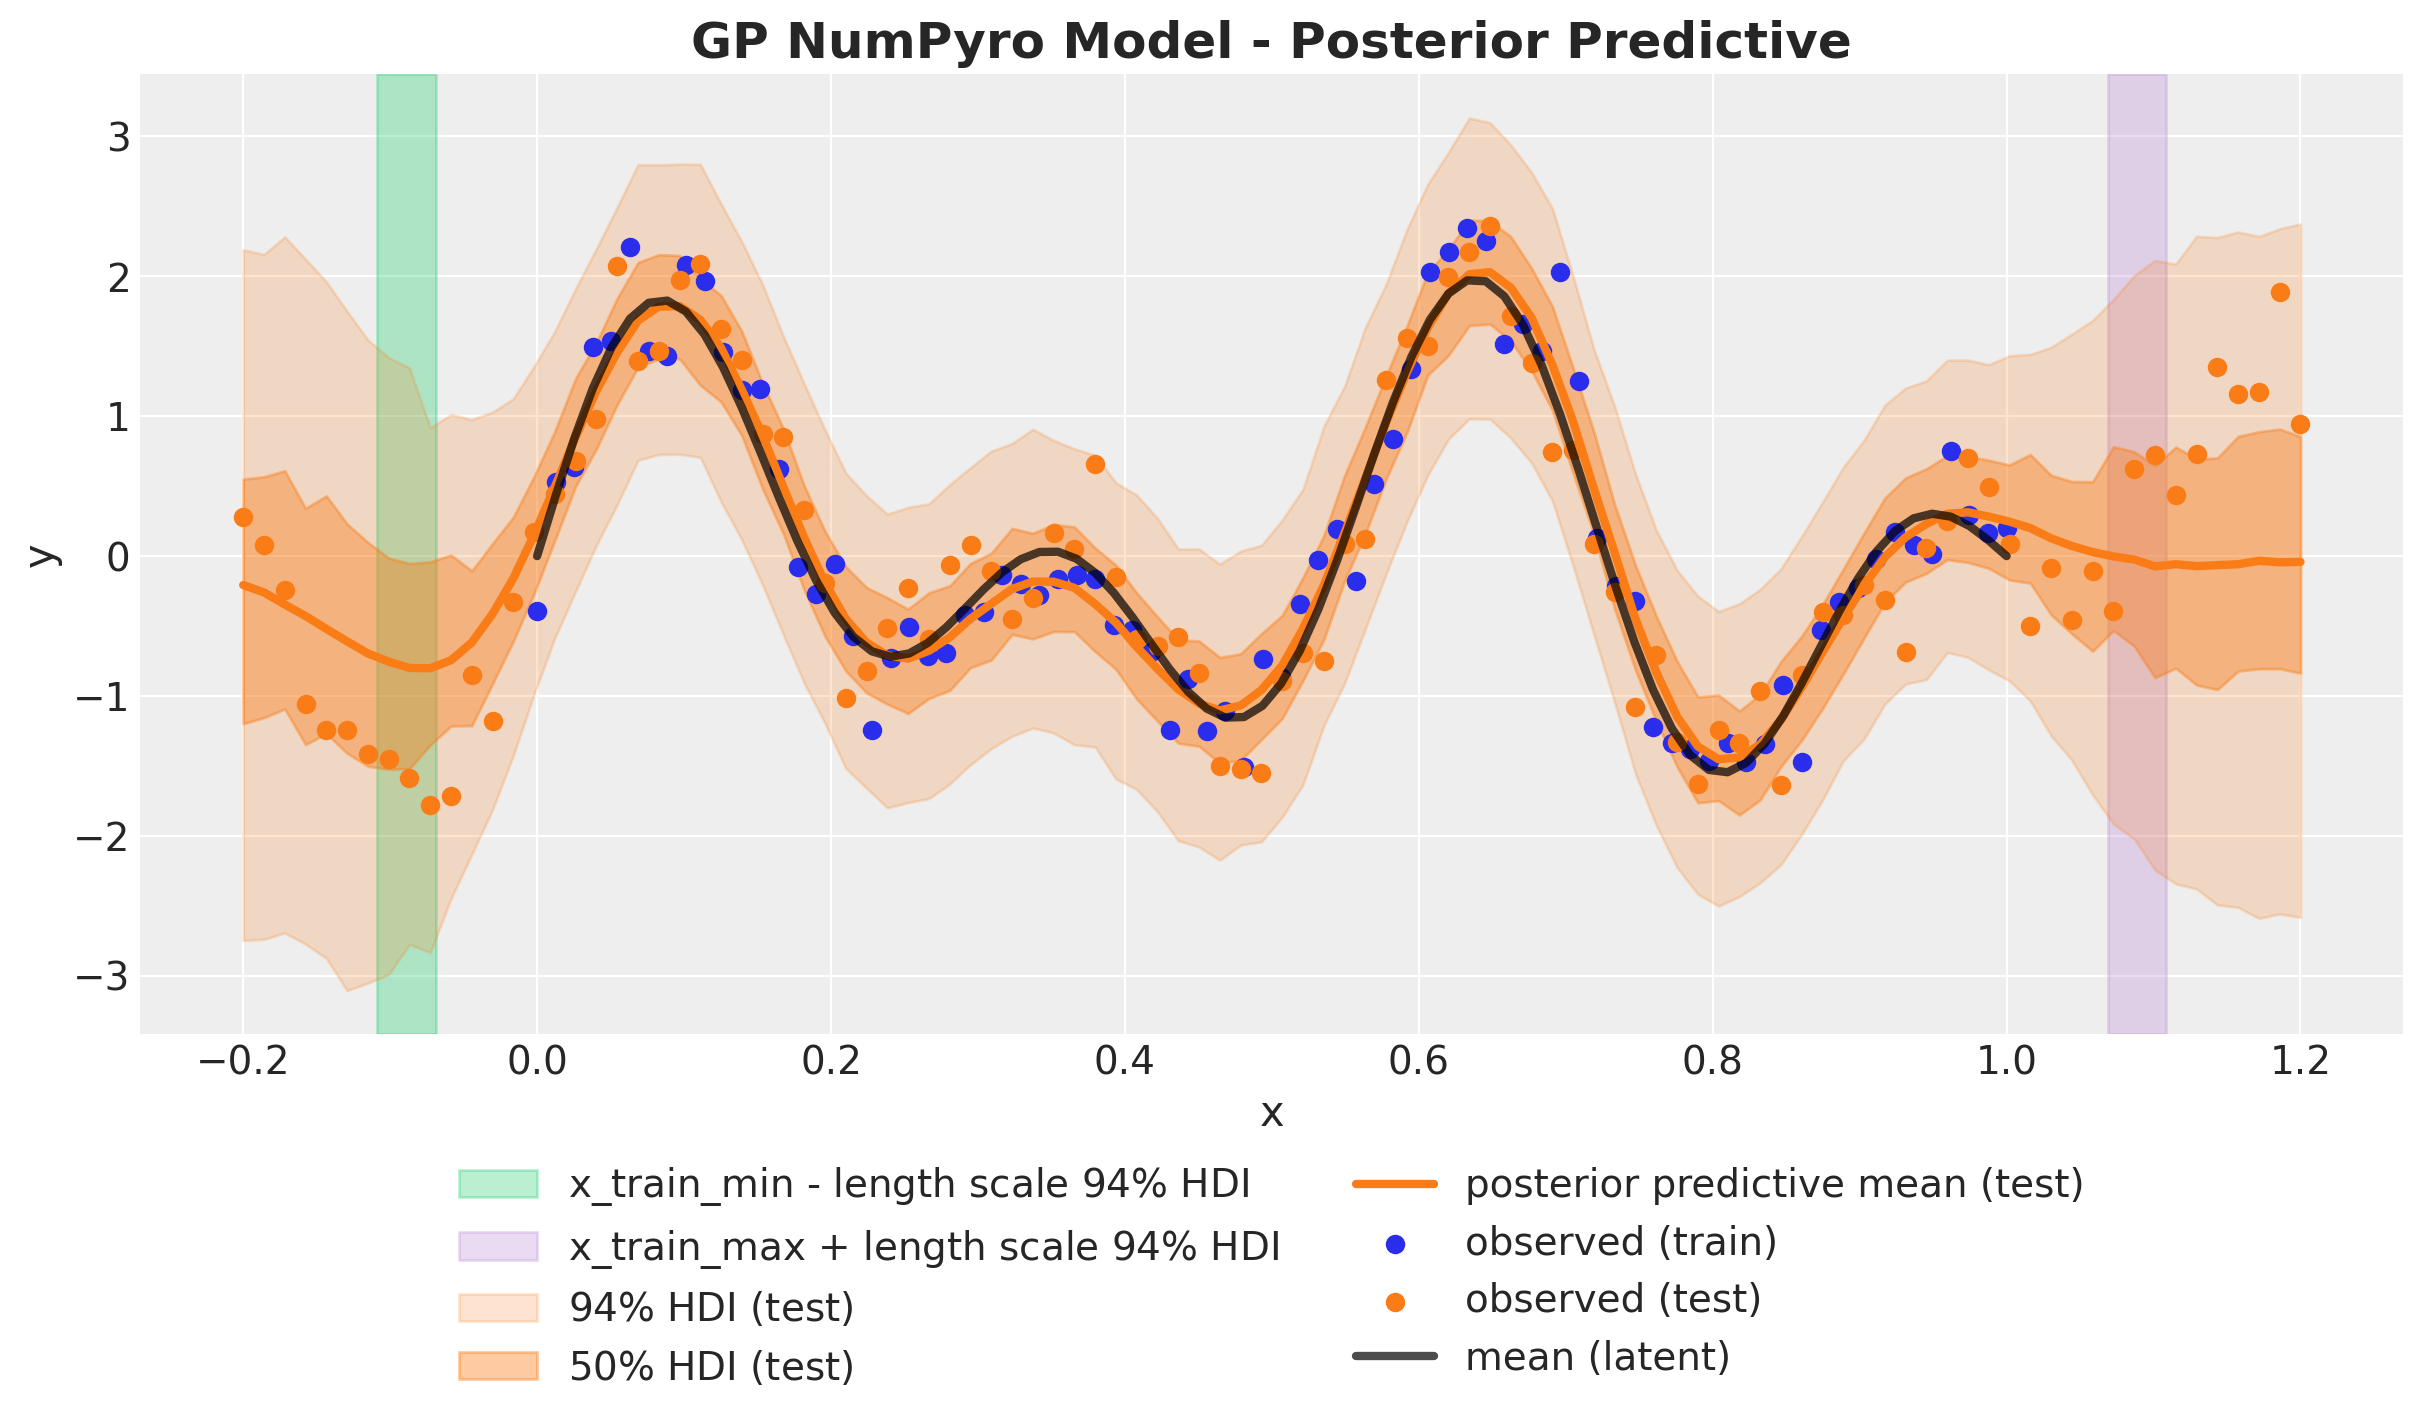

In [20]:
kernel_length_scale_hdi = az.hdi(gp_numpyro_idata.posterior)[
    "kernel_length_scale"
].to_numpy()


fig, ax = plt.subplots()
plt.axvspan(
    xmin=x_train.min().item() - kernel_length_scale_hdi[1],
    xmax=x_train.min().item() - kernel_length_scale_hdi[0],
    color="C7",
    alpha=0.3,
    label="x_train_min - length scale $94\\%$ HDI",
)
plt.axvspan(
    xmin=x_train.max().item() + kernel_length_scale_hdi[1],
    xmax=x_train.max().item() + kernel_length_scale_hdi[0],
    color="C8",
    alpha=0.3,
    label="x_train_max + length scale $94\\%$ HDI",
)
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Posterior Predictive", fontsize=18, fontweight="bold");

## PyMC Gaussian Process Model

In this section we show how to use the [`gp`](https://www.pymc.io/projects/docs/en/stable/api/gp.html) module in `PyMC` to generate the same results as in the `NumPyro` implementation. The data, priors and sampling parameters are the same as above.

To define a Gaussian process component in PyMC we can use the [`pm.Latent`](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.Latent.html) class. This class allows us to define a Gaussian process with a given mean and kernel function. Moreover, we can use the [`conditional`](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/classmethods/pymc.gp.Latent.conditional.html#pymc.gp.Latent.conditional) method to generate samples from the posterior distribution over functions on the test set without the need to write the expressions by hand. Let's see how to do this.

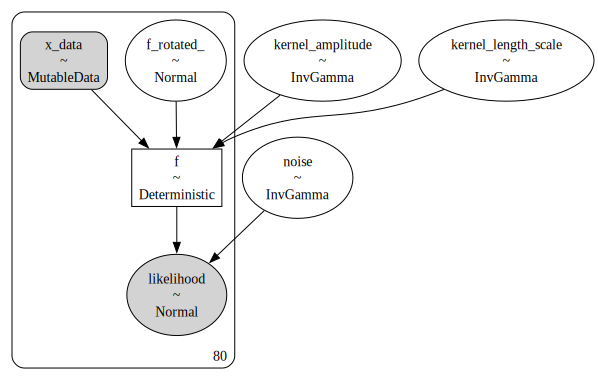

In [21]:
with pm.Model() as gp_pymc_model:
    x_data = pm.MutableData("x_data", value=x_train)

    kernel_amplitude = pm.InverseGamma(
        "kernel_amplitude",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )
    kernel_length_scale = pm.InverseGamma(
        "kernel_length_scale",
        alpha=inverse_gamma_params_1["alpha"],
        beta=inverse_gamma_params_1["beta"],
    )
    noise = pm.InverseGamma(
        "noise",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )

    mean = pm.gp.mean.Zero()
    cov = kernel_amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=kernel_length_scale)
    gp = pm.gp.Latent(mean_func=mean, cov_func=cov)
    f = gp.prior("f", X=x_data[:, None])

    pm.Normal("likelihood", mu=f, sigma=noise, observed=y_train_obs)


pm.model_to_graphviz(model=gp_pymc_model)

As the model is exactly the same as in the `NumPyro` implementation, we skip the prior predictive check and fit the model directly.

In [22]:
rng_key, rng_subkey = random.split(rng_key)

with gp_pymc_model:
    gp_pymc_idata = pm.sample(
        target_accept=0.9,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

The sampling time is not as fast as in the `NumPyro` implementation. It is slow, but it is still reasonable. We can now look into the posterior distributions and model diagnostics:

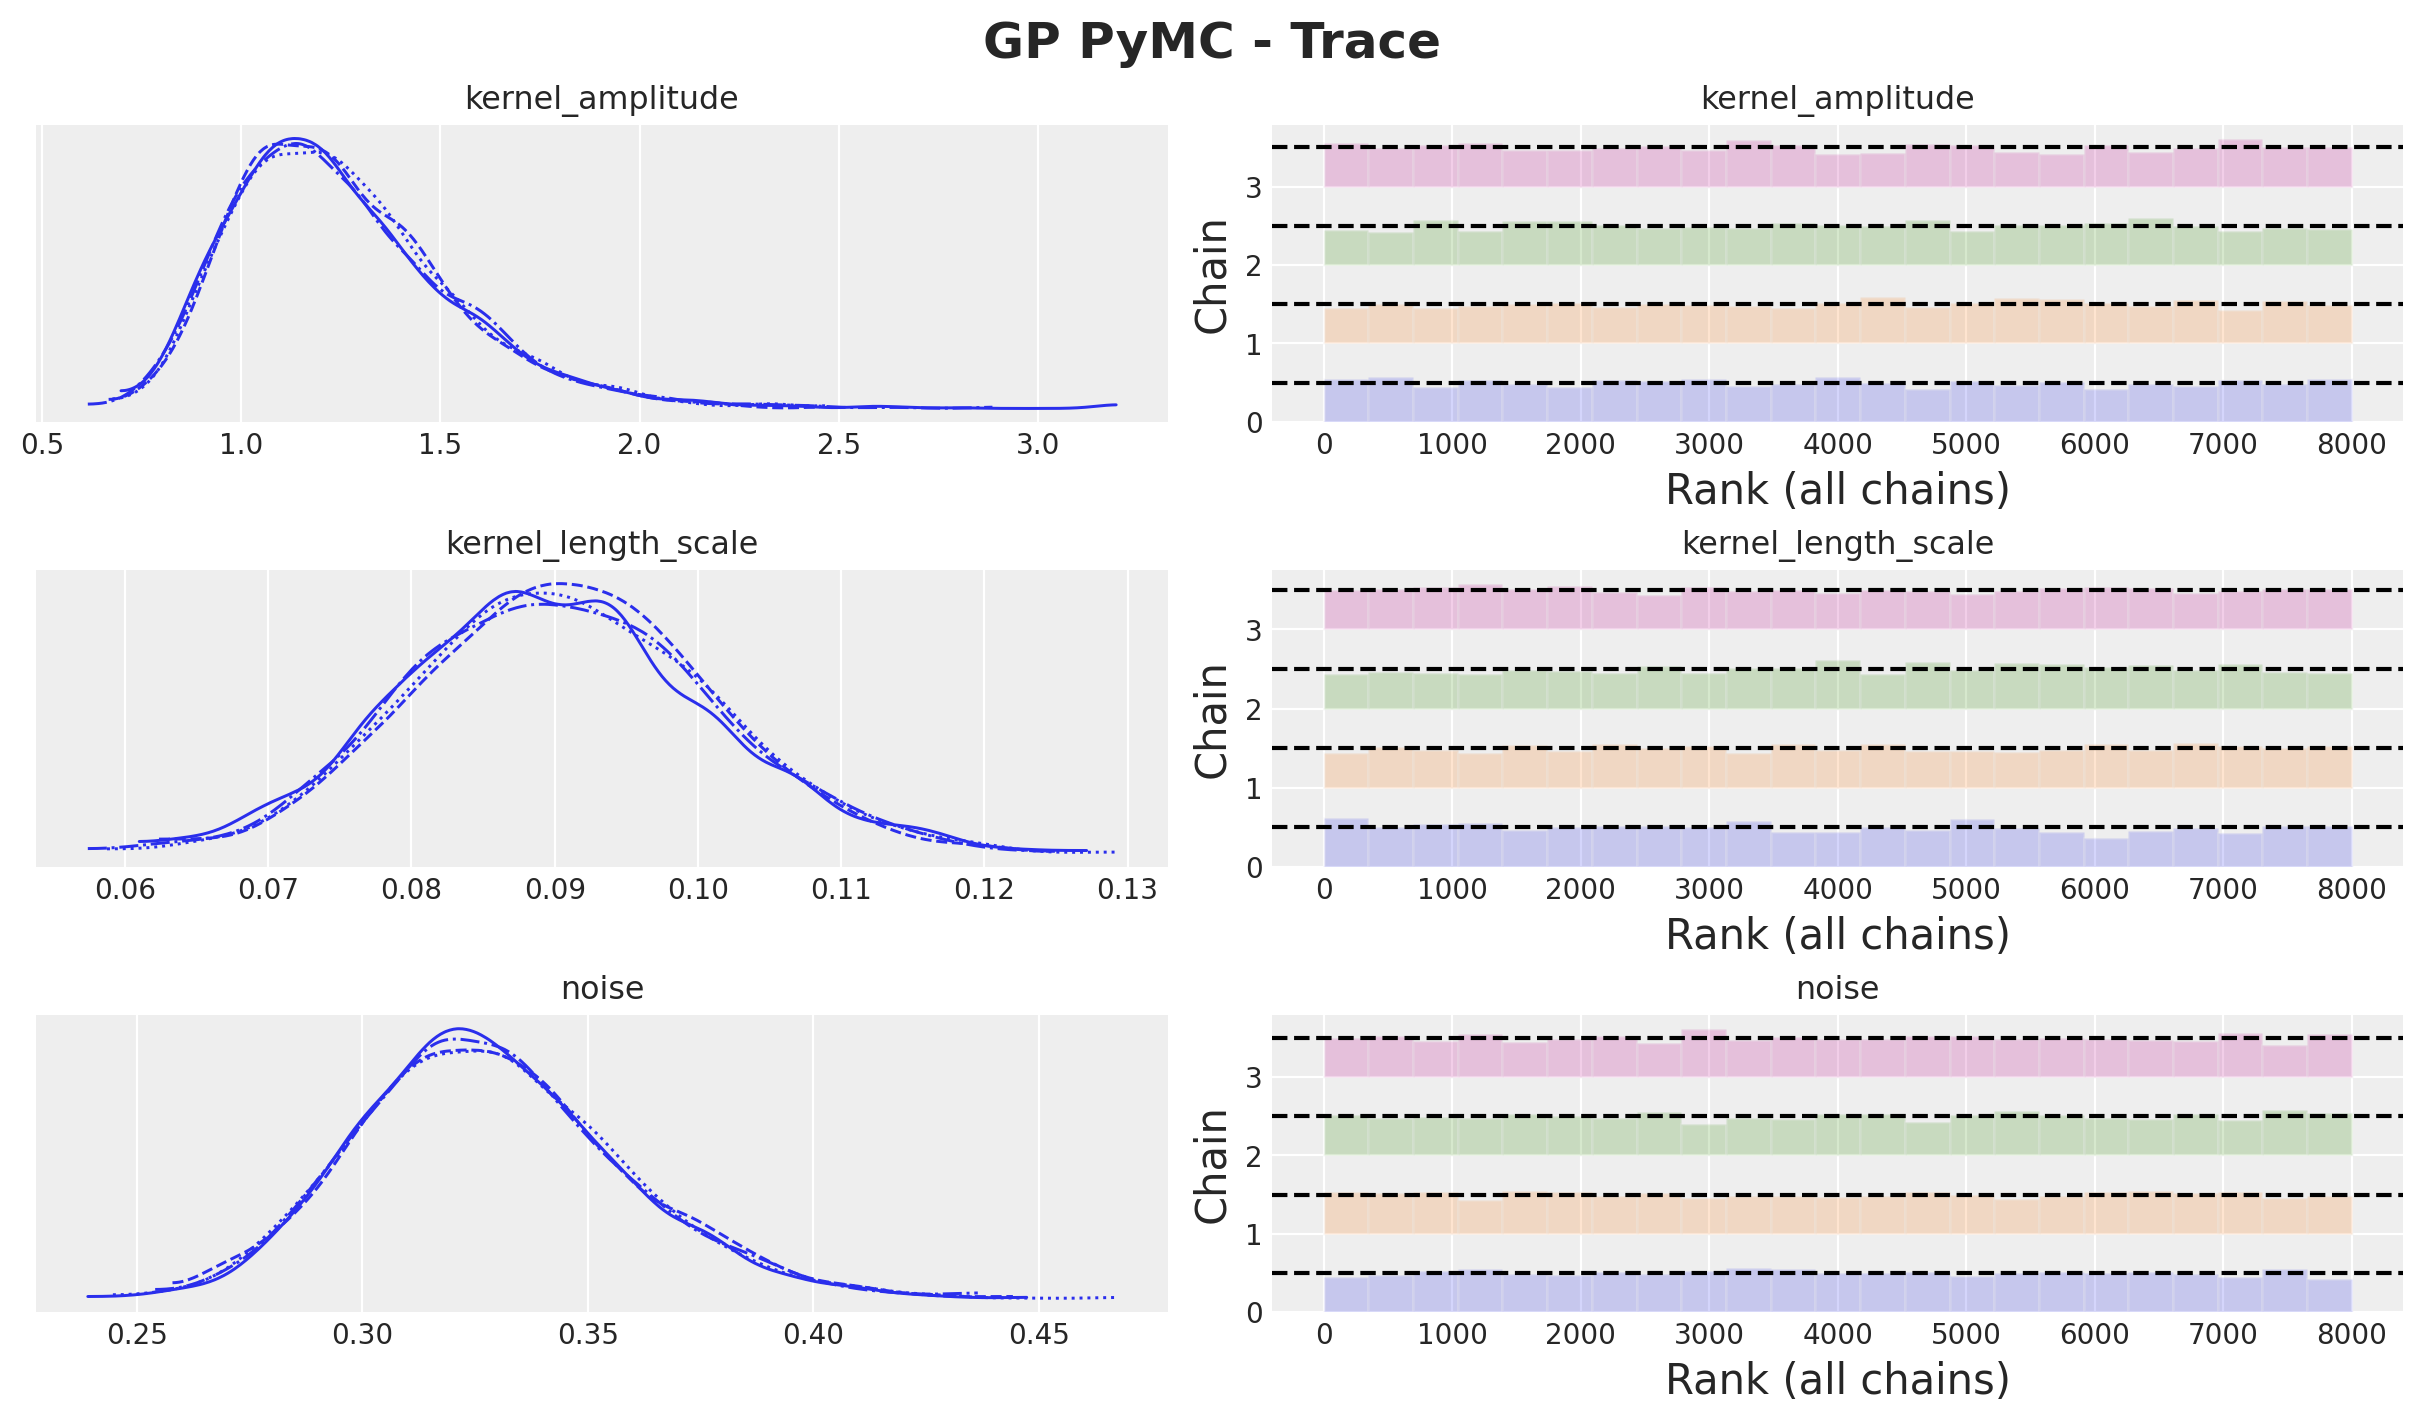

In [23]:
axes = az.plot_trace(
    data=gp_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP PyMC - Trace", fontsize=18, fontweight="bold");

We can see that the posterior distributions og both frameworks are almost the same:

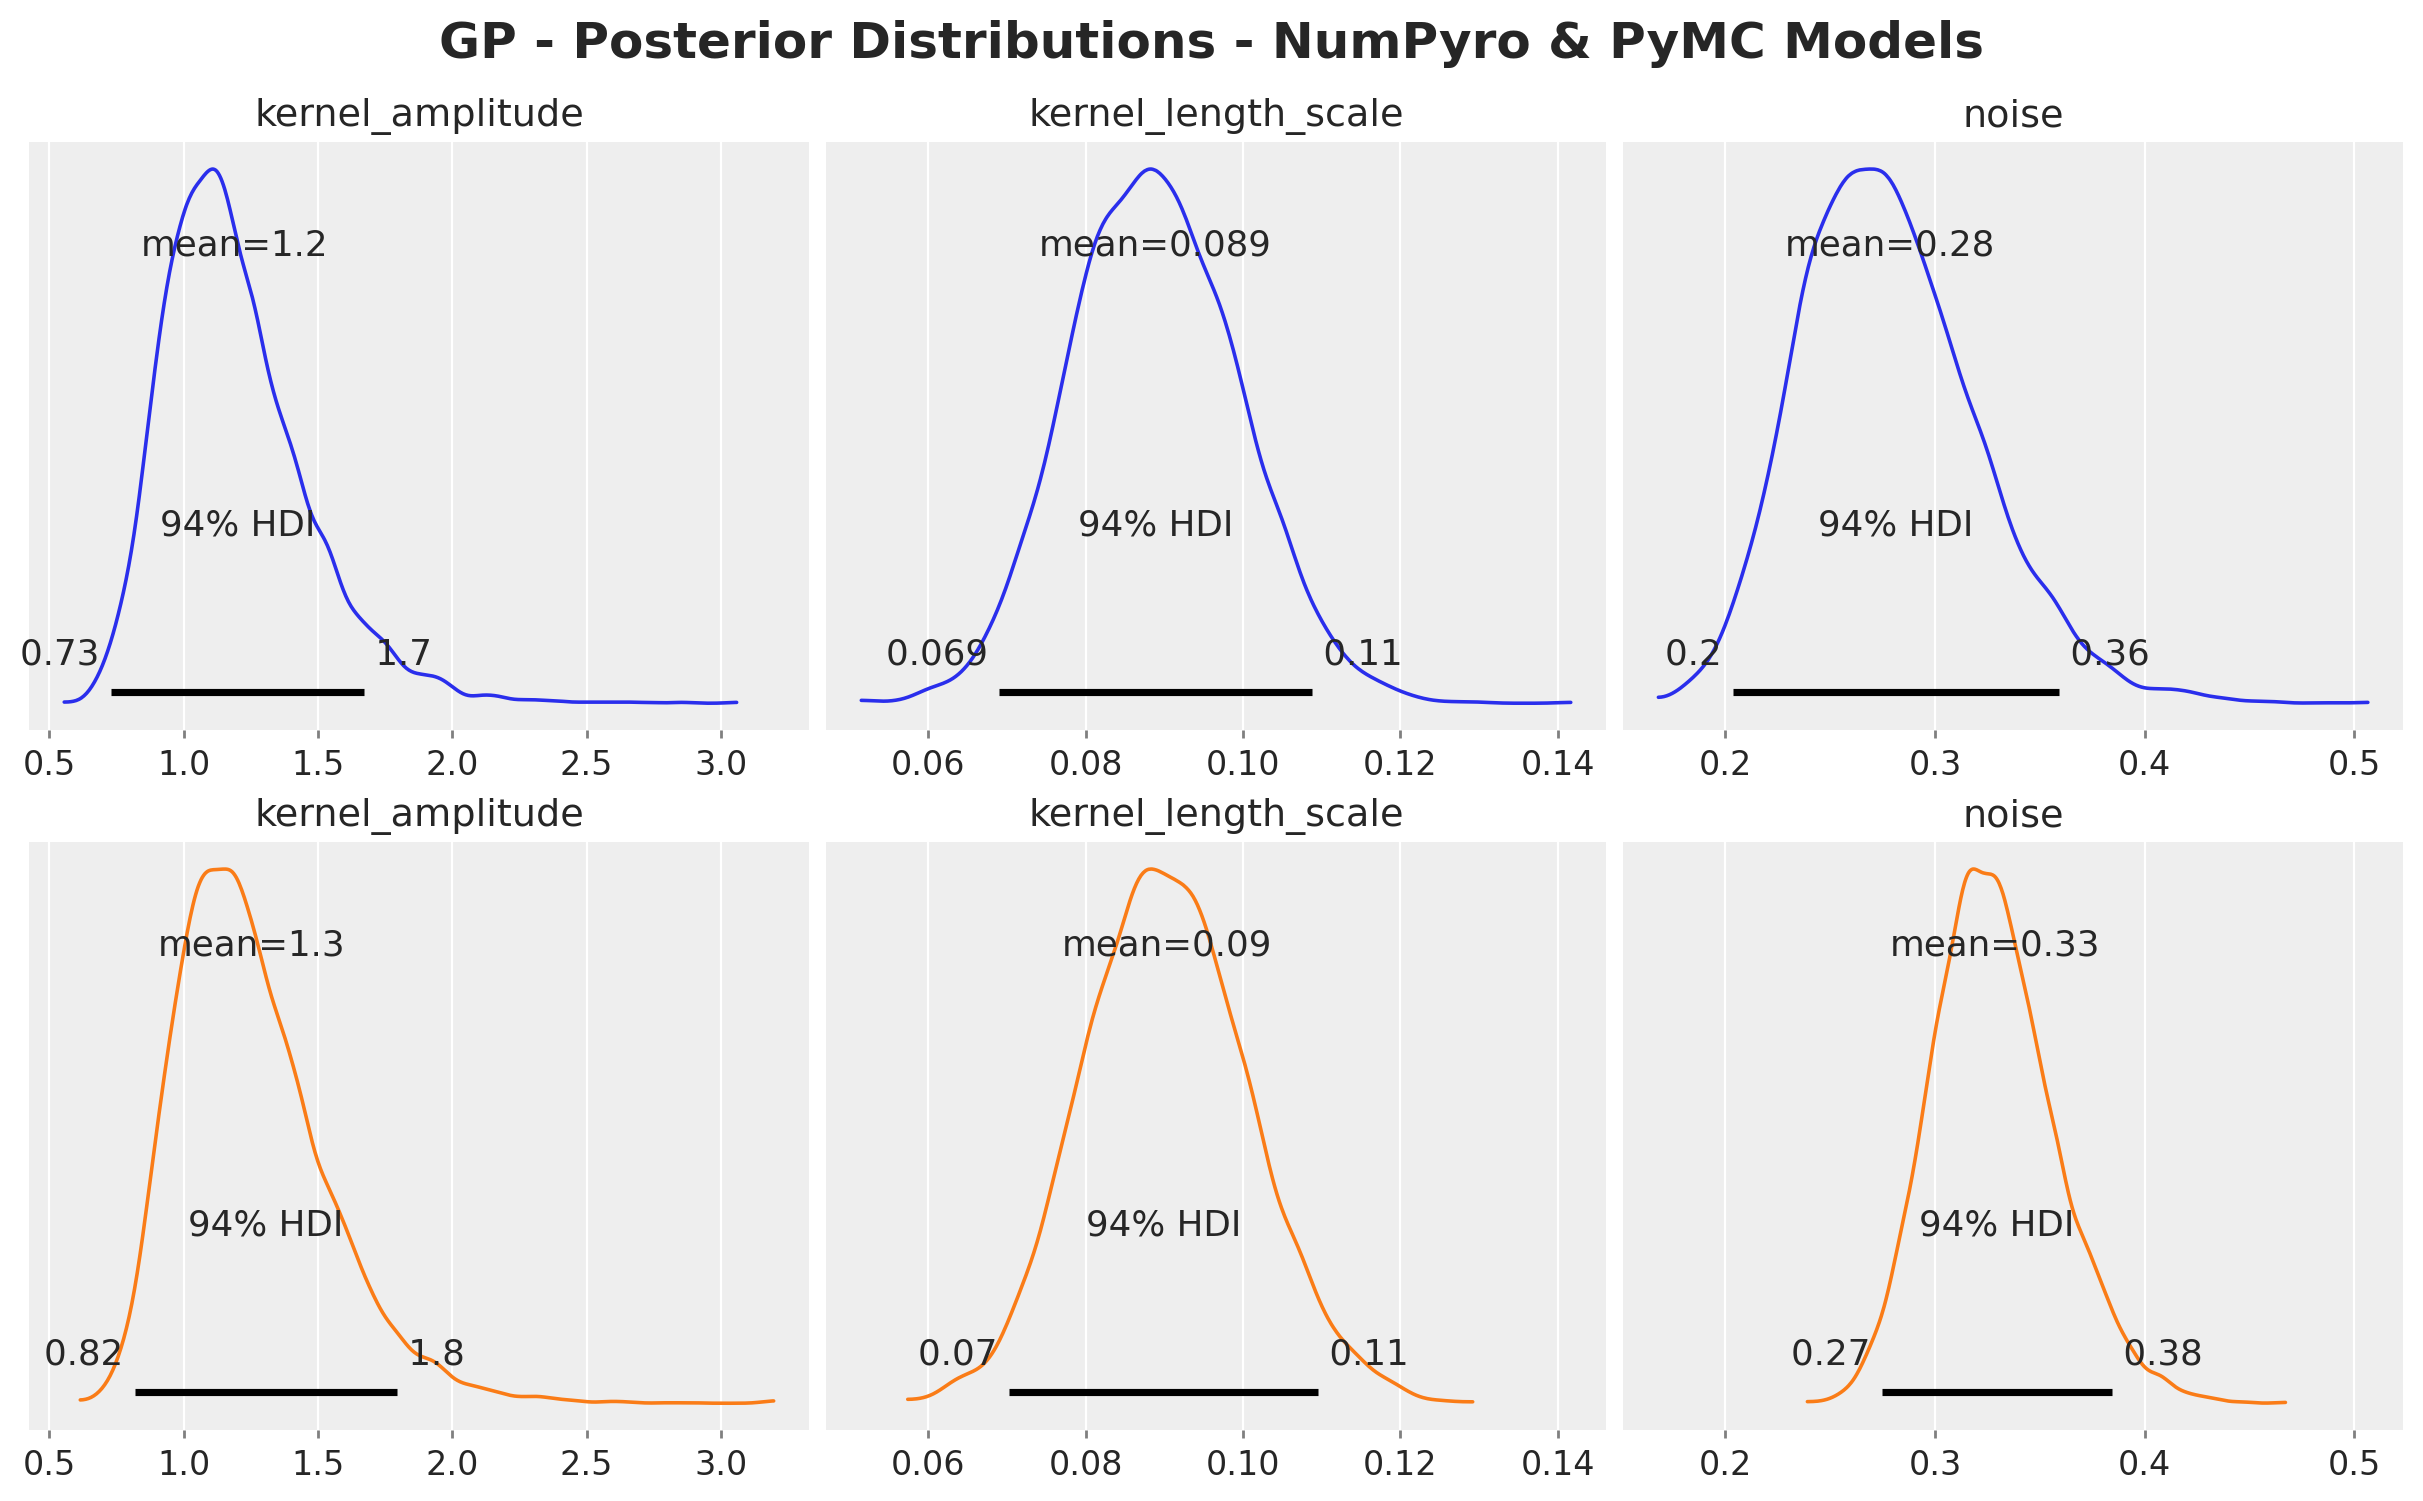

In [24]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 7),
    sharex="col",
    sharey=False,
    constrained_layout=True,
)

az.plot_posterior(
    data=gp_numpyro_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    round_to=2,
    kind="kde",
    hdi_prob=0.94,
    color="C0",
    textsize=12,
    ax=ax[0, :],
)
az.plot_posterior(
    data=gp_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    round_to=2,
    kind="kde",
    hdi_prob=0.94,
    color="C1",
    textsize=12,
    ax=ax[1, :],
)
fig.suptitle(
    "GP - Posterior Distributions - NumPyro & PyMC Models",
    fontsize=18,
    fontweight="bold",
    y=1.05,
);

Next, we generate samples from the posterior distribution over functions on the test set. Here is where the `conditional` method comes into play:

In [25]:
with gp_pymc_model:
    x_star_data = pm.MutableData("x_star_data", x_test)
    f_star = gp.conditional("f_star", x_star_data[:, None])
    pm.Normal("likelihood_test", mu=f_star, sigma=noise)

    gp_pymc_idata.extend(
        pm.sample_posterior_predictive(
            trace=gp_pymc_idata,
            var_names=["f_star", "likelihood_test"],
            random_seed=rng_subkey[1].item(),
        )
    )

Sampling: [f_star, likelihood_test]


Finally, we plot the posterior distribution over functions on the test set of both the likelihood and the latent Gaussian process:

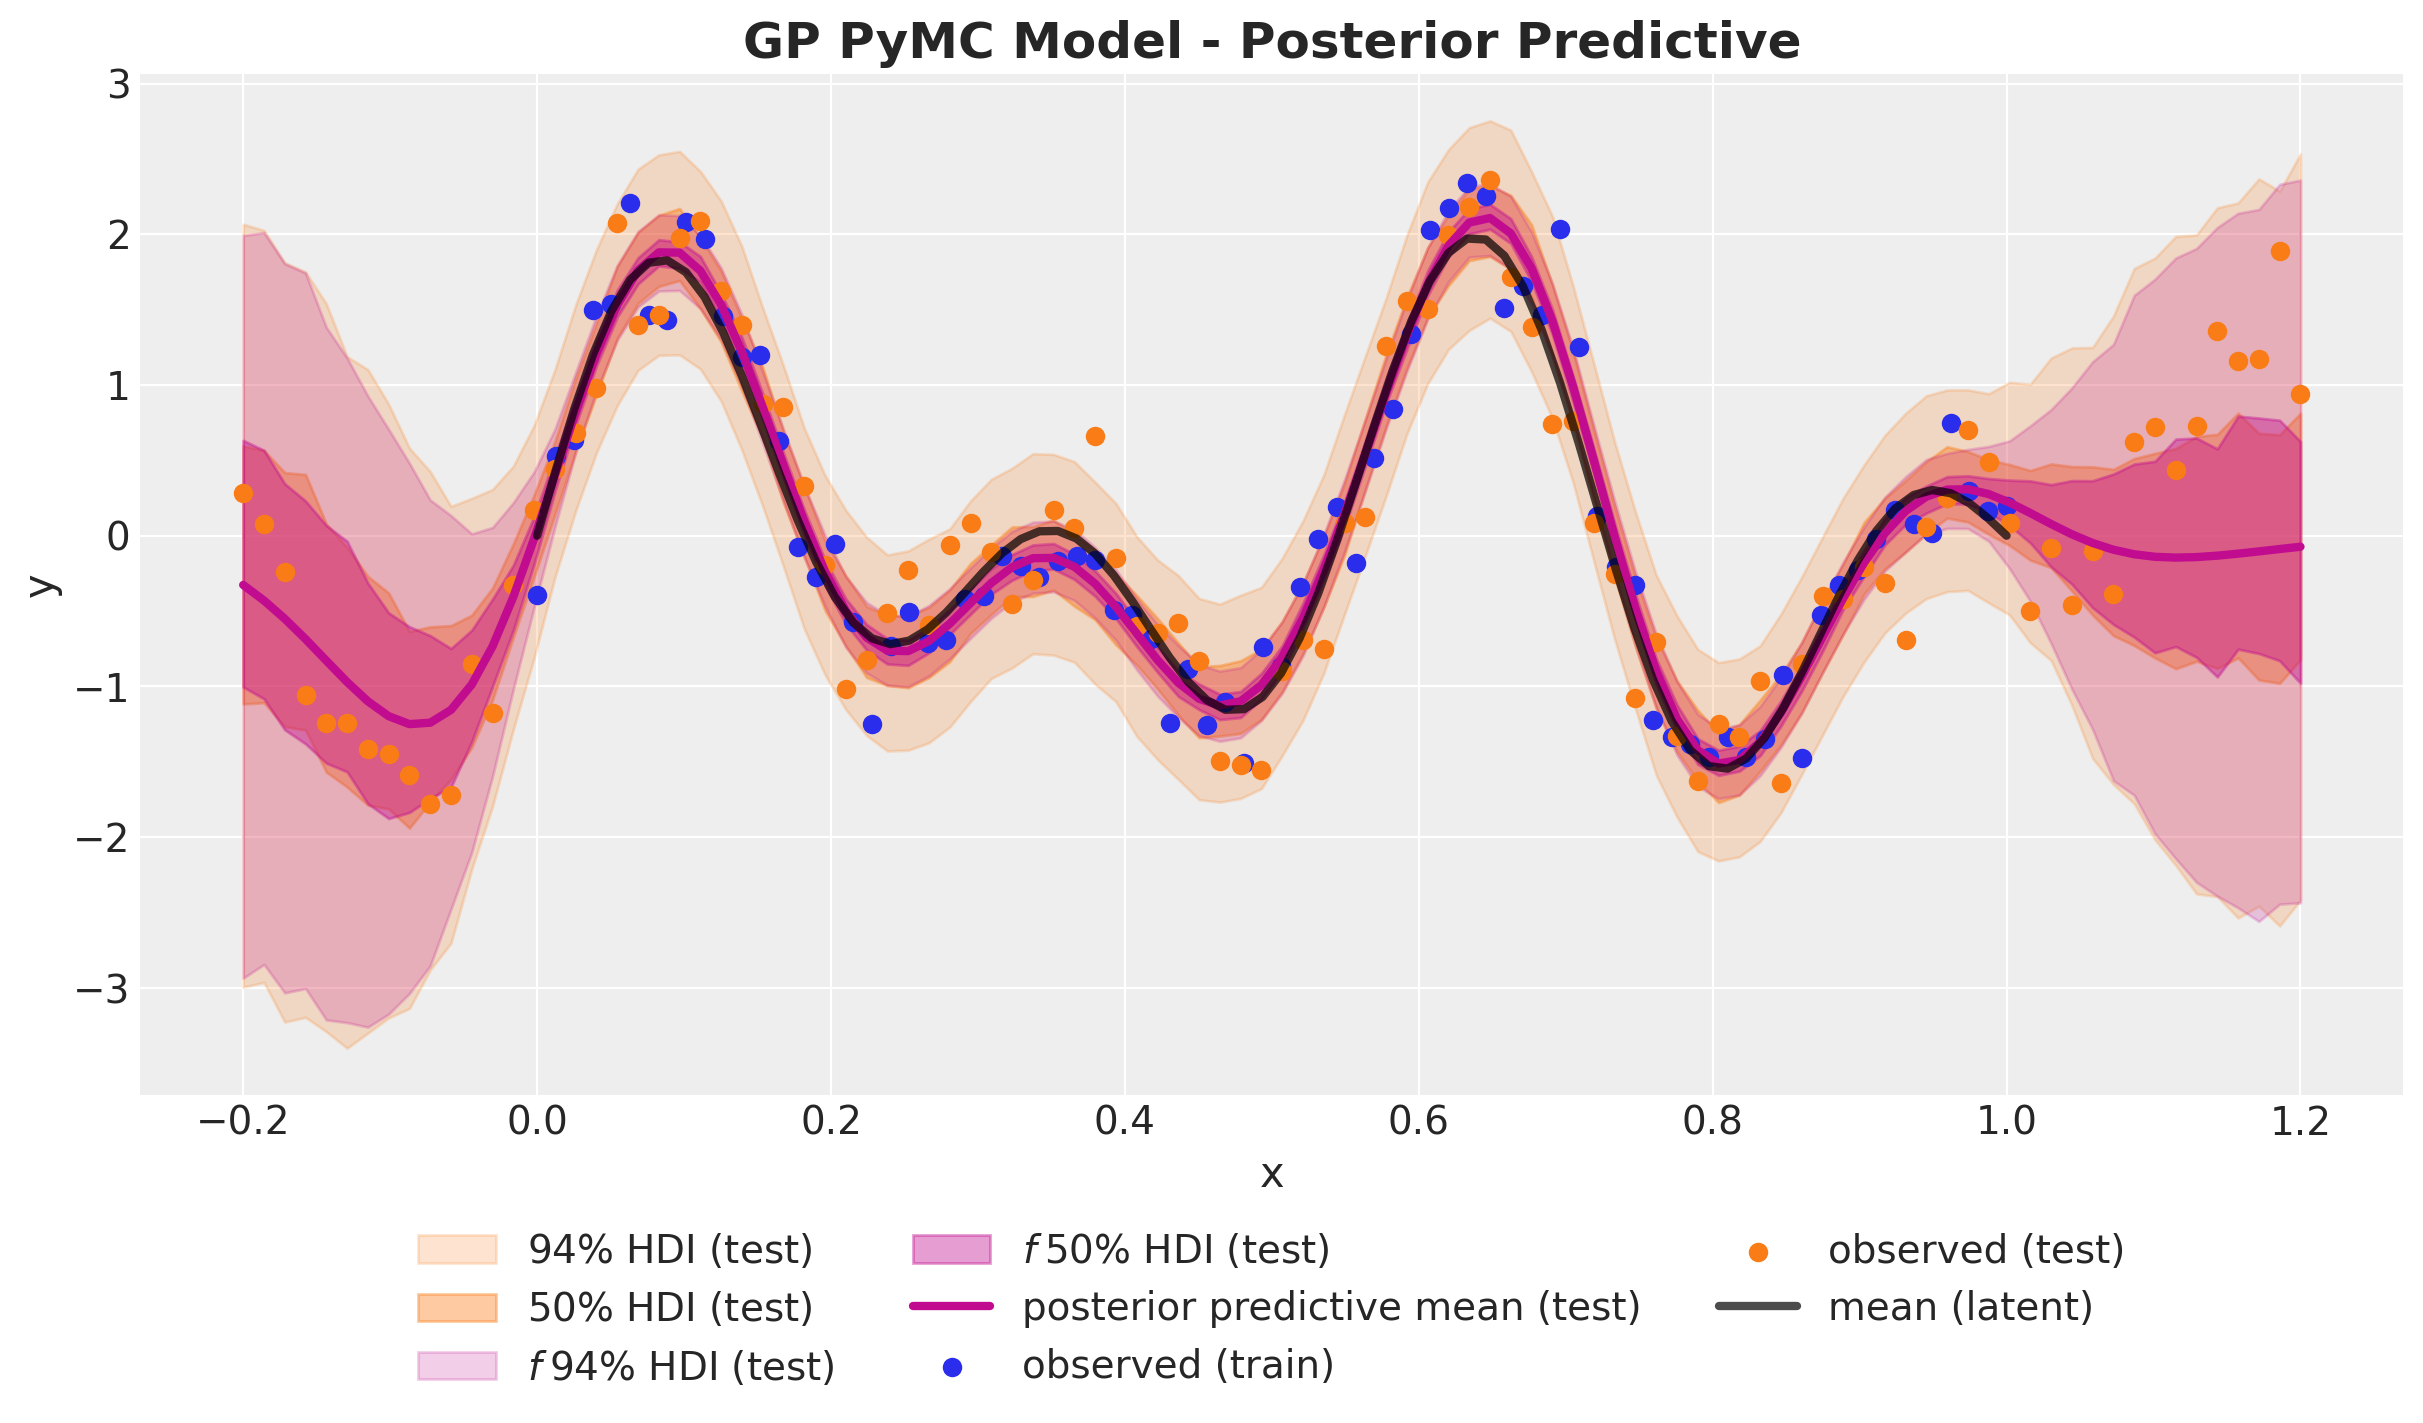

In [26]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["likelihood_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["likelihood_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["f_star"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$f \\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["f_star"],
    hdi_prob=0.5,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$f \\: 50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_pymc_idata.posterior_predictive["f_star"].mean(dim=("chain", "draw")),
    color="C3",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP PyMC Model - Posterior Predictive", fontsize=18, fontweight="bold");

We again see that the posterior predictive distribution of both frameworks are almost the same 🙌!

---

# Part II: Hilbert Space Gaussian Processes (HSGPs)

In this part we focus on the Hilbert Space Gaussian Process (HSGP) approximation method description following very closely the articles 

- ["Hilbert space methods for reduced-rank Gaussian process regression"](https://link.springer.com/article/10.1007/s11222-019-09886-w)
- ["Practical Hilbert space approximate Bayesian Gaussian processes for probabilistic programming"](https://link.springer.com/article/10.1007/s11222-022-10167-2)

We strongly recommend looking into these articles to get the details of the method. Here we simply provide a summary and indicate the main step so that we can do a simple version of the implementation ourselves. 

**Why do we need an approximation?** As we will see below, Gaussian processes do not scale well with the number of data points. The computational complexity of the Gaussian process model is $\mathcal{O}(n^3)$, where $n$ is the number of data points. This is due to the inversion of the kernel matrix. The HSGP approximation method is a way to reduce the computational complexity of the Gaussian process model to $\mathcal{O}(n)$.

The ouline of this part of the notebook is as follows:

**Approximation Strategy Steps:**

1. We recall de definition of the spectral density $S(\omega)$ associated with a stationary kernel function $k$.
2. We approximate the spectral density $S(\omega)$ as a polynomial series in $||\omega||^2$.
3. We can interpret these polynomial terms as powers of the Laplacian operator. The key observation is that the Fourier transform of the Laplacian operator is $||\omega||^2$.
4. Next, we impose Dirichlet boundary conditions on the Laplacian operator which makes it self-adjoint and with discrete spectrum (we do a D-tour in the main ideas a consequences of the spectral theorem).
5. We identify the expansion in (2) with the sum of powers of the Laplacian operator in the eigenbasis of (4).
6. We arrive to the final approximation formula and explicitly compute the terms for the squared exponential kernel in the one-dimensional case.

### The Scaling Challenge

Why do Gaussian processes scale poorly with the number of data points? In the introduction of the paper ["Hilbert space methods for reduced-rank Gaussian process regression"](https://link.springer.com/article/10.1007/s11222-019-09886-w) the authors give a great summary:

>*One of the main limitations of GPs in machine learning is the computational and memory requirements that scale as $\mathcal{O}(n^3)$ and  $\mathcal{O}(n^2)$ in a direct implementation. This limits the applicability of GPs when the number of training samples $n$ grows large. The computational requirements arise because in solving the GP regression problem we need to invert the $n \times n$ Gram matrix $K + \sigma_{n}^{2}I$, where $K=k(x_i, x_j)$, which is an $\mathcal{O}(n^3)$ operation in general.*

**Remark:** In real applications,  one does not invert the matrix but rather use the si called, Cholesky decomposition, since it is faster and numerically more stable. The Cholesky decomposition is an $\mathcal{O}(n^3)$ operation and it is defined as a factorization of the form $K = LL^{T}$ where $L$ is a lower triangular matrix. See ["Gaussian Processes for Machine Learning - Appendix A4:  Cholesky Decomposition"](https://gaussianprocess.org/gpml/chapters/RWA.pdf).

### Spectral Densities

In the case a kernel function is *stationary*, that is the kernel just depends in the difference $r := x - x'$ so that $k(x, x') = k(x - x') = k(r)$ (for example, the square exponential), we can use the spectral representation of the kernel function. The spectral representation of a kernel function is given by ([Bochner’s theorem](https://en.wikipedia.org/wiki/Bochner%27s_theorem))

$$
k(r) = \frac{1}{(2 \pi)^{d}}\int_{\mathbb{R}^{d}} e^{i \omega^{T} r} d\mu(\omega)
$$

where $\mu$ is a positive measure. If this measure has a density, it is called the *spectral density* $S(\omega)$ corresponding to the covariance function
$k(r)$. That is, we can write the kernel function as

$$
k(x, x') = \frac{1}{(2 \pi)^{d}} \int_{\mathbb{R}^{d}} e^{i \omega^{T} r} S(\omega) d\omega
$$

See ["Gaussian Processes for Machine Learning - Chapter 4: Covariance Functions"](https://gaussianprocess.org/gpml/chapters/RW4.pdf).

**Remark:** Note the similarity between the spectral density and the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform). For Gaussian-like kernels, like the squared exponential, we therefore expect the associated spectral density to also be Gaussian-like. Of course, we care about the constants and parameters of the kernel. This motivates the following example.

**Example:** For the squared exponential kernel, it can be shown that the spectral density is given by

$$
S(\omega) = a^2(2 \pi \ell^2)^{d/2} \exp\left(-2\pi^2\ell^2\omega^2\right)
$$

where $a$ is the amplitude and $\ell$ is the length-scale parameter.

For the special case $d=1$ we have

$$
S(\omega) = a^2 \sqrt{2 \pi} \ell \exp\left(-2\pi^2\ell^2\omega^2\right)
$$

We can write this spectral density as a function in JAX:

In [27]:
def squared_exponential_spectral_density(w, amplitude, length_scale):
    c = amplitude**2 * jnp.sqrt(2 * jnp.pi) * length_scale
    e = jnp.exp(-0.5 * (length_scale**2) * (w**2))
    return c * e

For an amplitude of one, we can plot the spectral density for different length-scales:

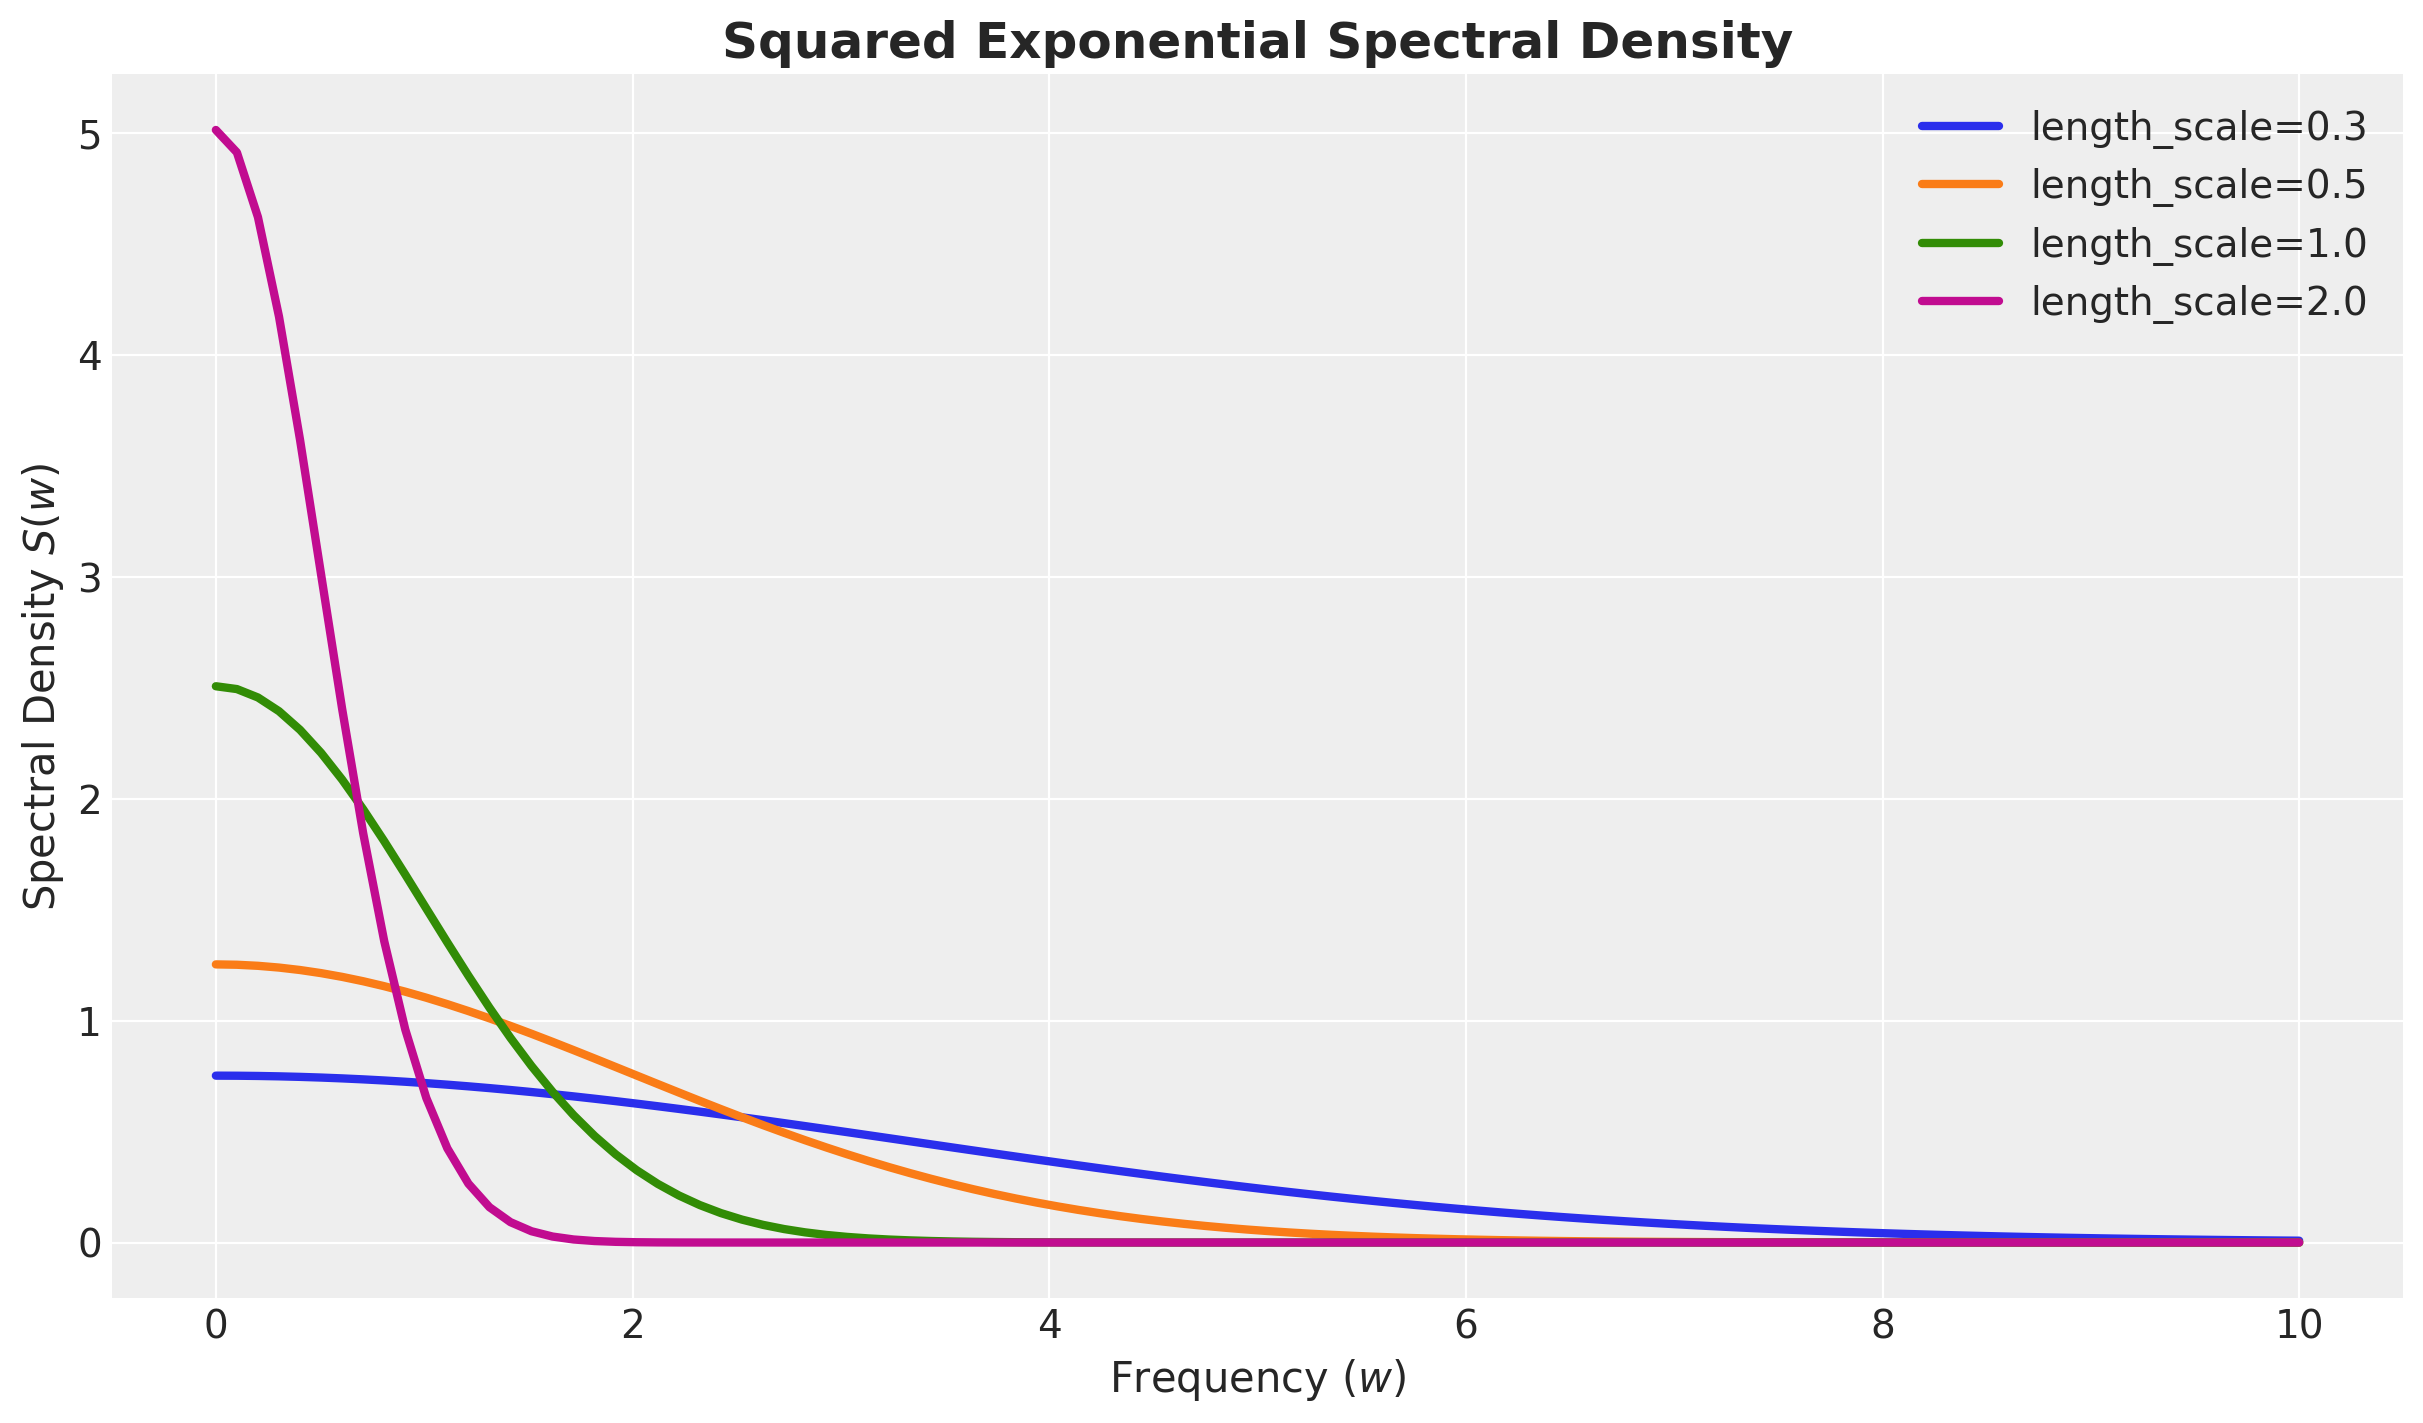

In [28]:
w = jnp.linspace(start=0, stop=10, num=100)
length_scales = [0.3, 0.5, 1.0, 2.0]

fig, ax = plt.subplots()
for i, length_scale in enumerate(length_scales):
    ax.plot(
        w,
        squared_exponential_spectral_density(
            w, amplitude=1.0, length_scale=length_scale
        ),
        c=f"C{i}",
        linewidth=3,
        label=f"length_scale={length_scale}",
    )
ax.legend(loc="upper right")
ax.set(xlabel="Frequency ($w$)", ylabel="Spectral Density $S(w)$")
ax.set_title("Squared Exponential Spectral Density", fontsize=18, fontweight="bold");

Observe that the spectral density is a bell-shaped curve centered at zero. In particular they decay fast at infinity. The length-scale parameter controls the width of the curve. The larger the length-scale, the narrower the curve.

**Remark [On the interpretation of spectral sensities from Rasmussen & Williams]:**
> *The complex exponentials $\exp(2 \pi i \omega x)$ are eigenfunctions of a stationary kernel* 
>
> $$
> k(x, x') = \int_{\mathbb{R}} e^{2\pi i \omega (x - x')} d\mu
> $$
> *with respect to Lebesgue measure $d\mu$ . Thus $S(\omega)$ is, loosely speaking, the amount of power allocated on average to the eigenfunction $\exp(2\pi i \omega x)$ with frequency $\omega$.*

### Formal Power Expansion of the Spectral Density

Next, to describe a convenient polynomial expansion of an spectral density, just like we do with [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) for functions. On the way, I will add comments relevant for the audience familiar with (pseudo) differential operators. This is not necessary to understand the main ideas but it is a nice connection to other areas of mathematics.

Let us assume the kernel function is isotropic, that is it only depends on the Euclidean (or $L^2$) norm $||r||$. In this case the associated spectral density $S(\omega)$ is also isotropic, i.e. $S(\omega) = S(||\omega||)$. We can formally write $S(||\omega||) = \psi(||\omega||^2)$ for a suitable function $\psi$. We can expand $\psi$ (for example, by requiring that $\psi$ is an analytic function) in a power series:

$$
S(||\omega||) = \psi(||\omega||^2) = a_0 + a_1 (||\omega||^2) + a_2 (||\omega||^2)^2 +  a_3 (||\omega||^2)^3 +  \cdots
$$

### Fourier Transform of the Laplacian

At fist sight, it looks very strange to expand the spectral density in terms of $||\omega||^2$ instead of $\omega$. The reason for this, as we will see below, is that we want to match this expansion with the one coming from the Laplace operator (via the spectral theorem). As the Laplace operator is a second order differential operator, its Fourier transform is a second order polynomial in $\omega$ (recall that the Fourier transform maps derivatives to polynomials). This is the link 😉! 

Concretely, if we denote by $\mathcal{F}$ the Fourier transform operator, then

$$
\mathcal{F}[\nabla^2 f](\omega) = - ||\omega||^2 \mathcal{F}[f]
$$

**Remark [Ellipticity]:** This also shows that the Laplacian is an [elliptic operator](https://en.wikipedia.org/wiki/Elliptic_operator), as its principal symbol (highest order of the Fourier transform) is $||\omega||^2$, which is invertible for $\omega \neq 0$. This is a key property for the existence of discrete eigenvalues and eigenfunctions.

Given the above, we can connect the spectral density expansion with the Laplacian operator by taking the inverse Fourier transform of the expansions of the spectral density. This will give us a polynomial expansion of the kernel operator 

$$
\mathcal{K} := \int_{\mathbb{R}^d} k(\cdot, x')\phi(x') dx'
$$

in terms of the Laplacian operator:

$$
\mathcal{K} = a_0  + a_1 (- \nabla^2) + a_2 (-\nabla^2)^2 - a_3 (\nabla^3)^2 + \cdots
$$

which is not a differential operator but a [pseudo-differential operator](https://en.wikipedia.org/wiki/Pseudo-differential_operator).

Our goal now is to use the spectral decomposition of the Laplacian (in terms of things we can explicitly compute) to approximate the kernel operator using the formula above. This is the main idea behind the Hilbert space approximation. Before we go into thee details, we go through a quick reminder of the main concepts and consequences of the spectral theorem.

### The Spectral Theorem

In this small subsection we recall the main ideas of the spectral theorem. For a detailed practical introduction for the finite-dimensional case (i.e. matrices), please see my blog post ["The Spectral Theorem for Matrices"](https://juanitorduz.github.io/the-spectral-theorem-for-matrices/).
When we talk about spectrum we mean eigenvalues and eigenvectors of a matrix or operator. The spectral theorem is a generalization of the diagonalization of matrices to more general operators. Let's work it out with a simple example. Consider the $2 \times 2$ matrix:

$$
A = \begin{pmatrix}
1 & 2 \\
2 & 1
\end{pmatrix}
$$

In [29]:
A = jnp.array([[1.0, 2.0], [2.0, 1.0]])

It is easy to see that the eigenvalues of $A$ are $\lambda_1 = 3$ and $\lambda_2 = -1$ with eigenvectors:

$$
v_1 = \frac{1}{\sqrt{2}} \begin{pmatrix}
1 \\
1
\end{pmatrix}

\quad \text{and} \quad

v_2 = \frac{1}{\sqrt{2}} \begin{pmatrix}
-1 \\
1
\end{pmatrix}
$$

We include the $\frac{1}{\sqrt{2}}$ factor so that $\{v_1, v_2\}$ is an orthonormal basis of $\mathbb{R}^2$. That is, 

$$
v_1^{T} v_2 = 0 \quad \text{and} \quad v_1^{T} v_1 = v_2^{T} v_2 = 1
$$

We can see this numerically:

In [30]:
eigenvalues, eigenvectors = jnp.linalg.eig(A)

print(f"Eigenvalues: {eigenvalues}\nEigenvectors:\n{eigenvectors}")

Eigenvalues: [ 3.+0.j -1.+0.j]
Eigenvectors:
[[ 0.70710678+0.j -0.70710678+0.j]
 [ 0.70710678+0.j  0.70710678+0.j]]


Th spectral theorem states that we can always find such orthonormal basis of eigenvectors for a symmetric matrix. Observe that if we cosnider the change of basis matrix

$$
Q = \begin{pmatrix}
v_1 & v_2
\end{pmatrix}
$$

then we can write the matrix $A$ in the new basis as

$$
D = Q^{T} A Q = \begin{pmatrix}
3 & 0 \\
0 & -1
\end{pmatrix}.
$$

We can compute this in JAX:

In [31]:
Q = eigenvectors

Q.T @ A @ Q

Array([[ 3.00000000e+00+0.j,  4.44089210e-16+0.j],
       [ 6.10622664e-16+0.j, -1.00000000e+00+0.j]], dtype=complex128)

**Remark:** Since $Q$ is defined trough an orthonormal basis, then $Q \in O(2)$ and $QQ^{T} = Q^{T}Q = I_2$.

In [32]:
Q @ Q.T

Array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]], dtype=complex128)

Another important consequence of the spectral theorem is that we can decompose the matrix $A$ as a sum of projections onto its eigenspaces. That is, we can write
is as 

$$
A = \sum_{j=1}^{2} \lambda_i v_j v_j^{T}
$$

Observe that the operator $P_{j} = v_j v_j ^{T}$ is indeed a projection operator, that is $P^2 = P$ and $P^T = P$, since the $v_j$ constitute an orthonormal basis.

We can write each individual projection as:

In [33]:
def proj(v, x):
    return jnp.dot(v, x) * v

So that the weighted sum of projections is the matrix $A$:

In [34]:
def matrix_proj(x):
    return eigenvalues[0] * proj(Q[:, 0], x) + eigenvalues[1] * proj(Q[:, 1], x)

We can verify that the action on a vector $x$ is the same as the action of the matrix $A$:

- Eigenvector $v_1$:

In [35]:
jnp.dot(A, Q[:, 0]) / eigenvalues[0]

Array([0.70710678+0.j, 0.70710678+0.j], dtype=complex128)

- Eigenvector $v_2$:

In [36]:
matrix_proj(Q[:, 1]) / eigenvalues[1]

Array([-0.70710678-0.j,  0.70710678-0.j], dtype=complex128)

- Arbitrary vector $v$:

In [37]:
v = jnp.array([1.0, 2.0])

jnp.allclose(jnp.dot(A, v), matrix_proj(v))

Array(True, dtype=bool)

The last consequence of the spectral theorem we want to mention is the [functional calculus](https://en.wikipedia.org/wiki/Spectral_theorem#Functional_calculus) of operators. This is a generalization of the Taylor series for functions to operators. Given a function $f$ we can define the operator $f(A)$ as

$$
f(A) = \sum_{j=1}^{2} f(\lambda_j) v_j v_j^{T}
$$

Observe that in the particular cases

- $f(z) = z$ we recover the operator $A$.
- $f(z) = 1$ we recover the identity operator $I$.

To illustrate this, we can evaluate the exponential the matrix $A$ defined as

$$
\exp(A) = \sum_{j=0}^{\infty} \frac{A^j}{j!}
$$

We can use the existing implmenetation to compute this directly:

In [38]:
scipy.linalg.expm(A)

Array([[10.22670818,  9.85882874],
       [ 9.85882874, 10.22670818]], dtype=float64)

On the other hand, we can use the fact that $A = Q D Q^{T}$ and that $Q$ is an orhogonal matrix to write

$$
\exp(A) = \sum_{j=0}^{\infty} \frac{(Q D Q^{T})^j}{j!} = Q \left(\sum_{j=0}^{\infty} \frac{D^j}{j!}\right) Q^{T} = Q \exp(D) Q^{T}
$$

and observe that $\exp(D)$ is a diagonal matrix with the exponential of the diagonal elements:

In [39]:
Q @ jnp.diag(jnp.exp(eigenvalues)) @ Q.T

Array([[10.22670818+0.j,  9.85882874+0.j],
       [ 9.85882874+0.j, 10.22670818+0.j]], dtype=complex128)

We indeed see that both methods give the same result.

Through the functional calculus we can define a large class of operators simply by defining the function $f$.

The spectral theorem has generalization to more general operators, including differential operators between Sobolev spaces. The theory is much more involved but the main ideas are the same. We do not go into details here (for a reference see ["Unbounded Self-adjoint Operators on Hilbert Space"](https://link.springer.com/book/10.1007/978-94-007-4753-1) by Konrad Schmüdgen).

After this short D-tour, we can now go continue and apply the spectral theorem to the Laplace operator.

### Dirichlet's Laplacian

Recall that an unbounded operator is not only defined by its action, but also by its domain of definition. In the case of the Laplacian on an open domain $\Omega \subset \mathbb{R}^d$ (with boundary $\partial \Omega$ sufficiently smooth), we need to specify the boundary conditions. The most common boundary conditions are the [Dirichlet boundary conditions](https://en.wikipedia.org/wiki/Dirichlet_eigenvalue), which are defined by requiring that the function vanishes on the boundary of the domain. The Laplacian with Dirichlet boundary conditions is a self-adjoint operator defined on the Hilbert space $L^{2}(\Omega)$ equipped with the Lebesgue measure. In addition, it has discrete spectrum with eigenvalues $\lambda_j$ and eigenfunctions $\phi_j$ that form an orthonormal basis of $L^2(\Omega)$, so that
$$
\int_{\Omega} \phi_{j}(x) \phi_{k}(x) dx = \delta_{jk}
$$

**Example [One Dimension]:** One can easily find the spectral decomposition of the Laplacian on the interval $[-L, L]$ with Dirichlet boundary conditions. We just need to solve the equation

$$
\frac{d^2 \phi}{dx^2} = - \lambda \phi \quad \text{with} \quad \phi(-L) = \phi(L) = 0
$$

It is easy to see that the solutions are given by

$$
\phi_j(x) = \sqrt{\frac{1}{L}} \sin\left(\frac{\pi j (x + L)}{2L}\right)
$$

with eigenvalues 

$$
\lambda_j = \left(\frac{j \pi}{2L}\right)^2.
$$

### Hilbert Space Gaussian Process Approximation

Using the functional calculus of the spectral decomposition (see details in the section above), one can write the Laplacian as acting on function $f$ in the domain of definition as:

$$
-\nabla^2 f(x) = \int_{\Omega} l(x, x') f(x') dx'
$$

where 

$$
l(x, x') = \sum_{j} \lambda_{j} \phi_{j}(x) \phi_{j}(x')
$$

is the kernel operator associated with the Laplacian. Note that this resembles the finite dimensional case, where we use the dot product instead of the integral.

The functional calculus allows to consider powers of the Laplacian $(- \nabla^2)^{s}$,

$$
(- \nabla^2)^{s} f(x) = \int_{\Omega} l^{s}(x, x') f(x') dx'.
$$

We can use this expression and compare it with the expansion of the spectral density to approximate the kernel operator of the Gaussian process:

\begin{align*}
& \left[ a_{0} + a_{1}(-\nabla^2) + a_{2}(-\nabla^2)^2 + \cdots \right]f(x) = \\
&\int_{\Omega} \left[a_{0} + a_{1} l(x, x') + a_{2} l^{2}(x, x') + \cdots \right] f(x') dx'
\end{align*}

This implies we can approximate the kernel as

\begin{align*}
k(x, x') \approx & \: a_{0} + a_{1} l(x, x') + a_{2} l^{2}(x, x') + \cdots \\
\approx & \sum_{j} \left[ a_{0} + a_{1} \lambda_{j} + a_{2} \lambda_{j}^2 + \cdots \right] \phi_{j}(x) \phi_{j}(x')
\end{align*}

> **which is only an approximation to the covariance function due to restriction of the domain to Ω and the boundary conditions.**

Finally, recall that the coefficient $a_j$ where defined by the polynomial expansion of the spectral density, so if we take $||\omega||^2 = \lambda_j$ then we arrive at the final expression for e approximation formula:

$$
\boxed{
k(x, x') \approx \sum_{j} S(\sqrt{\lambda_j})\phi_{j}(x) \phi_{j}(x')
}
$$

**Example [One Dimension]:**  Coming back to the one-dimensional case, we can use this formula to approximate the squared exponential kernel in terms of the Dirichlet's Laplacian on the interval $[-L, L]$,

$$
k(x, x') \approx 
\sum_{j} \underbrace{a^2 \sqrt{2 \pi} \ell \exp\left(-2\pi^2\ell^2 \left(\frac{\pi j}{2L}\right)^2 \right) }_{S(\sqrt{\lambda_j})} 
\overbrace{\left(\sqrt{\frac{1}{L}} \sin\left(\frac{\pi j (x + L)}{2L}\right)\right)}^{\phi_{j}(x)}
\overbrace{\left(\sqrt{\frac{1}{L}} \sin\left(\frac{\pi j (x' + L)}{2L}\right)\right)}^{\phi_{j}(x')}
$$

In the next section we use this formula to approximate the squared exponential kernel in the one-dimensional case.

**Remark:** Note that the eigenvectors $\phi_j$ **do not** depend on the kernel parameters $a$ and $\ell$. This is a key property as this is essentially reducing the problem to a *linear regression* problem in the eigenvector basis. This is where the speed-up comes from 🤓!

## NumPyro Hilbert Space Gaussian Process Model

Now that we have a theoretical understanding of the Hilbert space Gaussian process approximation and have explicit formulas for the case of the squared exponential kernel in one dimension, we can implement the approximation in JAX and NumPyro for  the same synthetic data as before. We follow closelly the implementation described in Numpyro's documentation ["Example: Hilbert space approximation for Gaussian processes"](https://num.pyro.ai/en/stable/examples/hsgp.html).

### Hilbert Space Approximation Step by Step

In the last part we already implemented the spectral density for the squared exponential kernel in one dimension. Next, we need to write the expressions of the eigenvalues and eigenvector of the Laplacian in the interval $[-L, L]$ (we use the `l_max` for $L$ as we do not like upper-case for function arguments 😅).

In [40]:
def laplacian_sqrt_eigenvalues(l_max: float, m: int):
    sqrt_base_eigenvalue = jnp.pi / (2 * l_max)
    return sqrt_base_eigenvalue * jnp.arange(1, 1 + m)


def diag_squared_exponential_spectral_density(
    amplitude: float, length_scale: float, l_max: float, m: int
):
    sqrt_eigenvalues = laplacian_sqrt_eigenvalues(l_max, m)
    return squared_exponential_spectral_density(
        sqrt_eigenvalues, amplitude, length_scale
    )

Recall that the weights in the approximation formula are given by the spectral density evaluated on the square root of the eigenvalues of the Laplacian. Let's see how these look for various length scales and fixed amplitude $a=1$ and box length $L=1.5$.

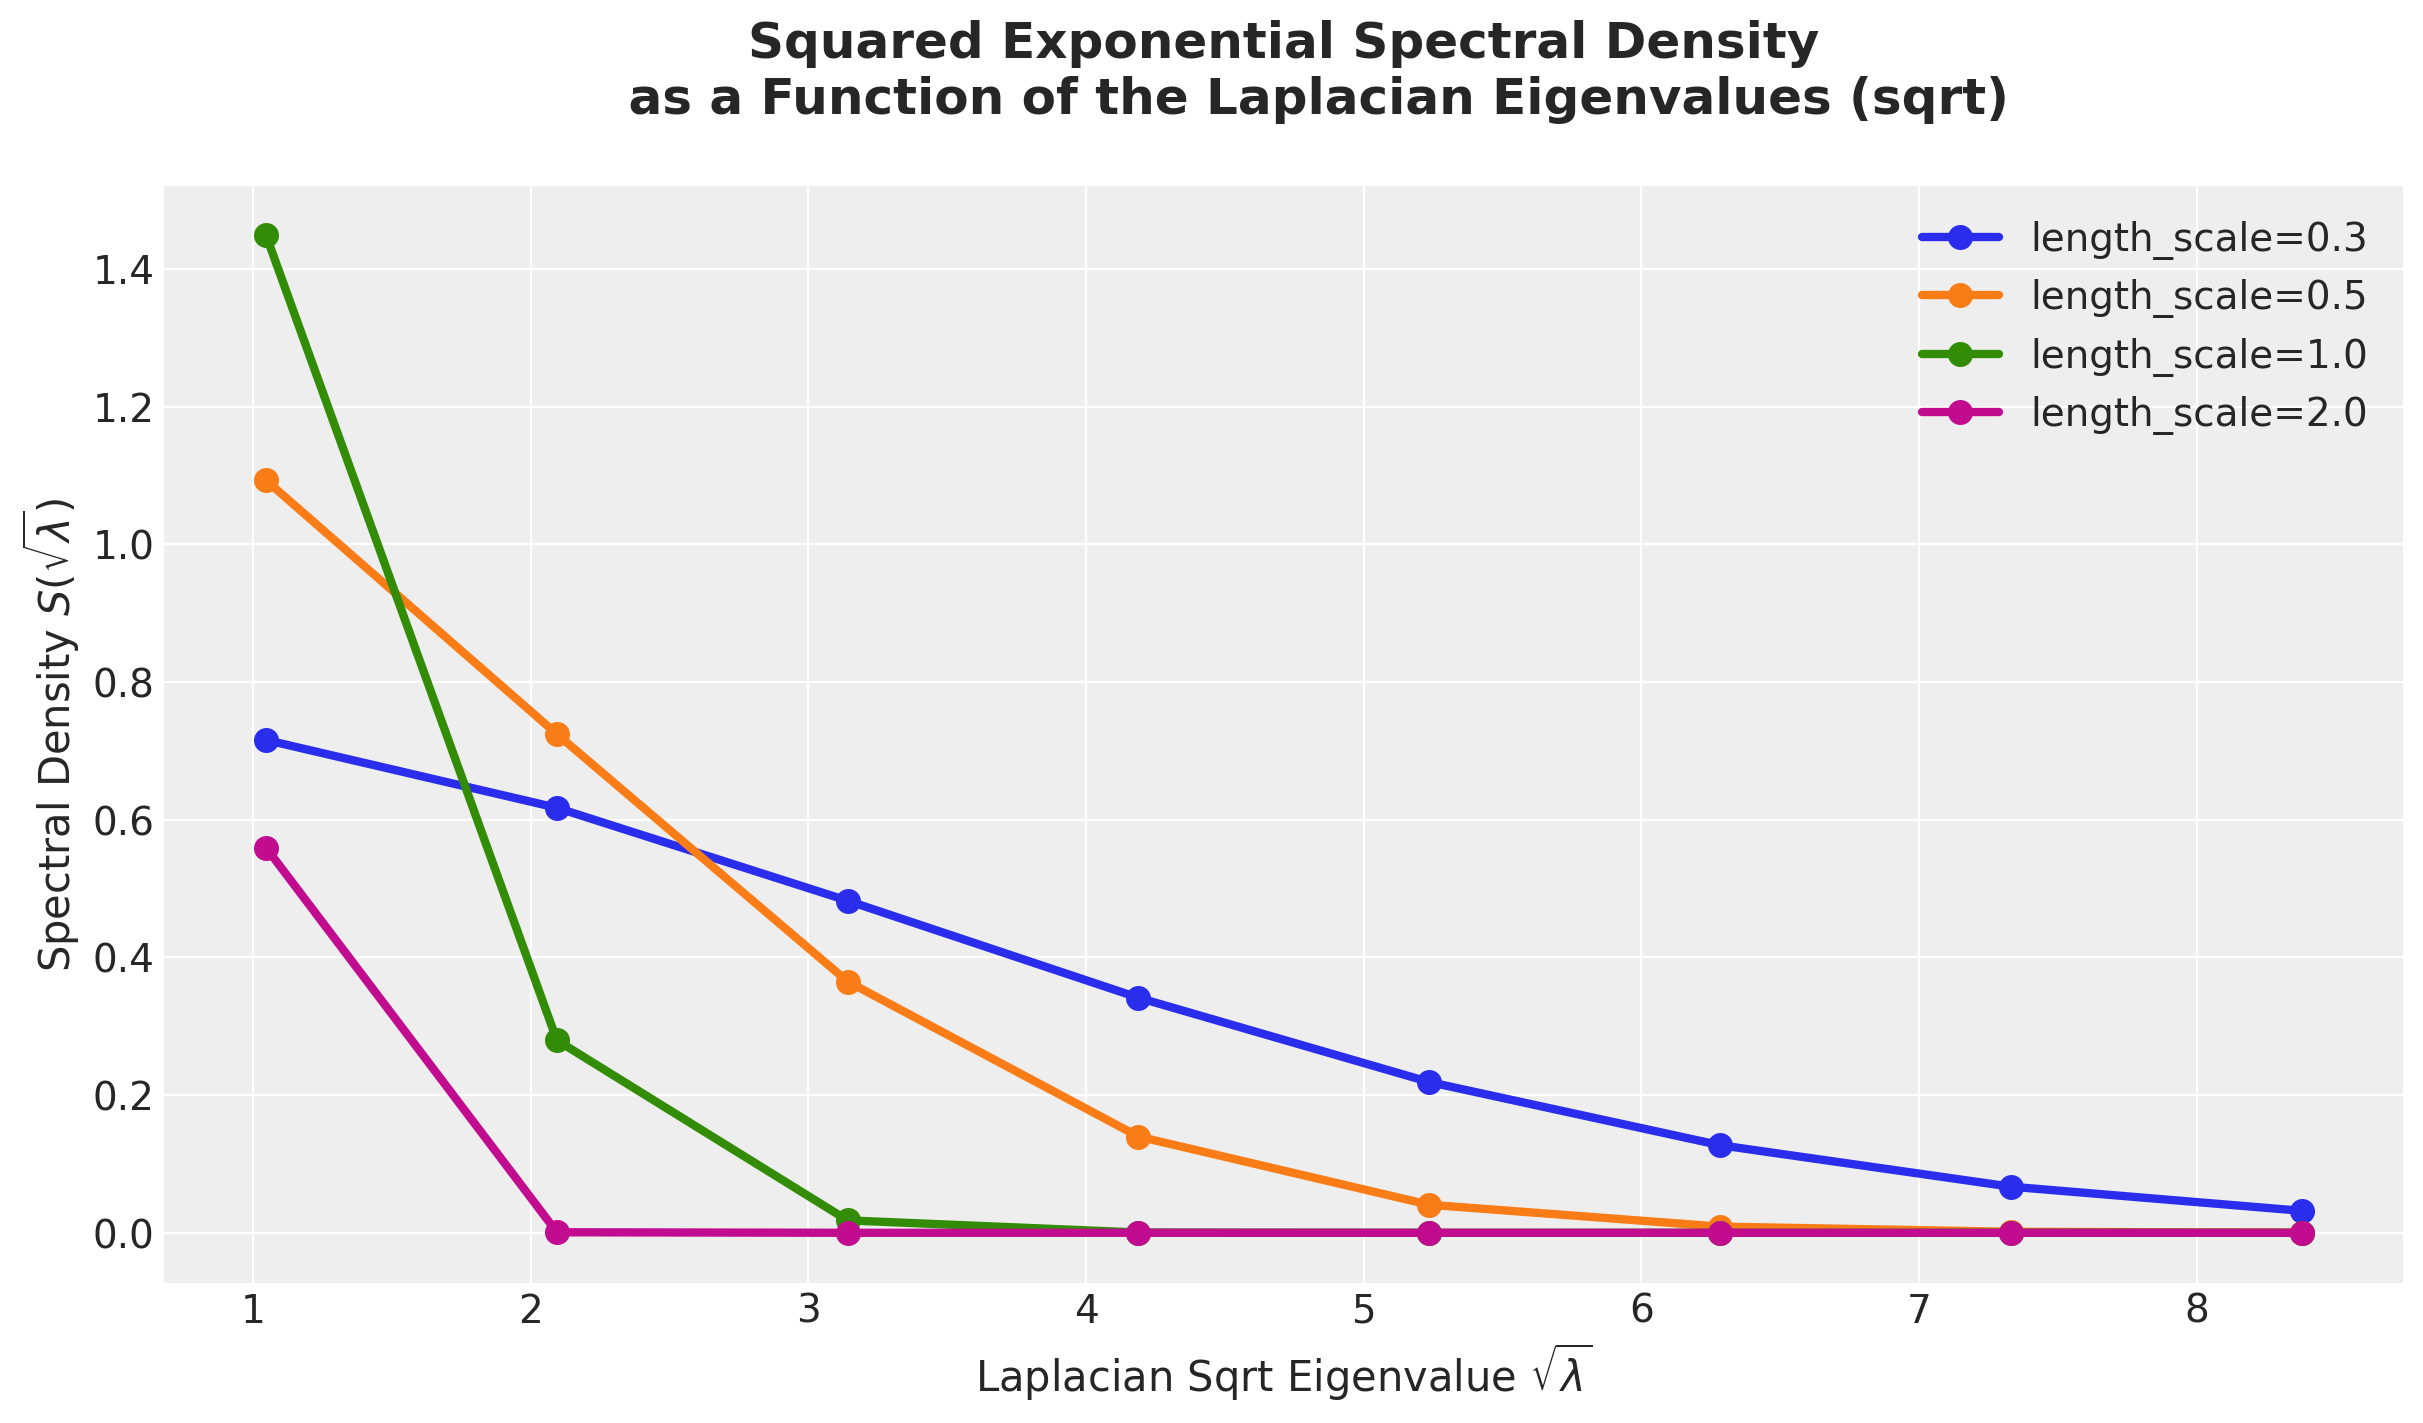

In [41]:
m = 8
l_max = 1.5


fig, ax = plt.subplots()
for i, length_scale in enumerate(length_scales):
    ax.plot(
        laplacian_sqrt_eigenvalues(l_max=l_max, m=m),
        diag_squared_exponential_spectral_density(
            amplitude=1.0, length_scale=length_scale, l_max=l_max, m=m
        ),
        marker="o",
        c=f"C{i}",
        linewidth=3,
        markersize=8,
        label=f"length_scale={length_scale}",
    )
ax.legend(loc="upper right")
ax.set(
    xlabel="Laplacian Sqrt Eigenvalue $\\sqrt{\\lambda}$",
    ylabel="Spectral Density $S(\\sqrt{\\lambda})$",
)
ax.set_title(
    """Squared Exponential Spectral Density
    as a Function of the Laplacian Eigenvalues (sqrt)
    """,
    fontsize=18,
    fontweight="bold",
);

From this plot we see how the concentration of the spectral density varies with the langth-scale parameter. The larger the length-scale, the more concentrated the spectral density is around zero.

We continue by looking into the Laplacian eigenfunctions

$$
\phi_j(x) = \sqrt{\frac{1}{L}} \sin\left(\frac{\pi j (x + L)}{2L}\right)
$$

We can compute them in a vectorized way:

In [42]:
def laplace_eigenfunctions(x, l_max, m):
    sqrt_eigenvalues = laplacian_sqrt_eigenvalues(l_max, m)
    rep_x = jnp.tile(l_max + x[:, None], reps=m)
    diag_sqrt_eigenvalues = jnp.diag(sqrt_eigenvalues)
    num = jnp.sin(rep_x @ diag_sqrt_eigenvalues)
    den = jnp.sqrt(l_max)
    return num / den


phi = laplace_eigenfunctions(x_train, l_max, m)

assert phi.shape == (n_train, m)

We can visualize the first few eigenfunctions on the domain of the training data:

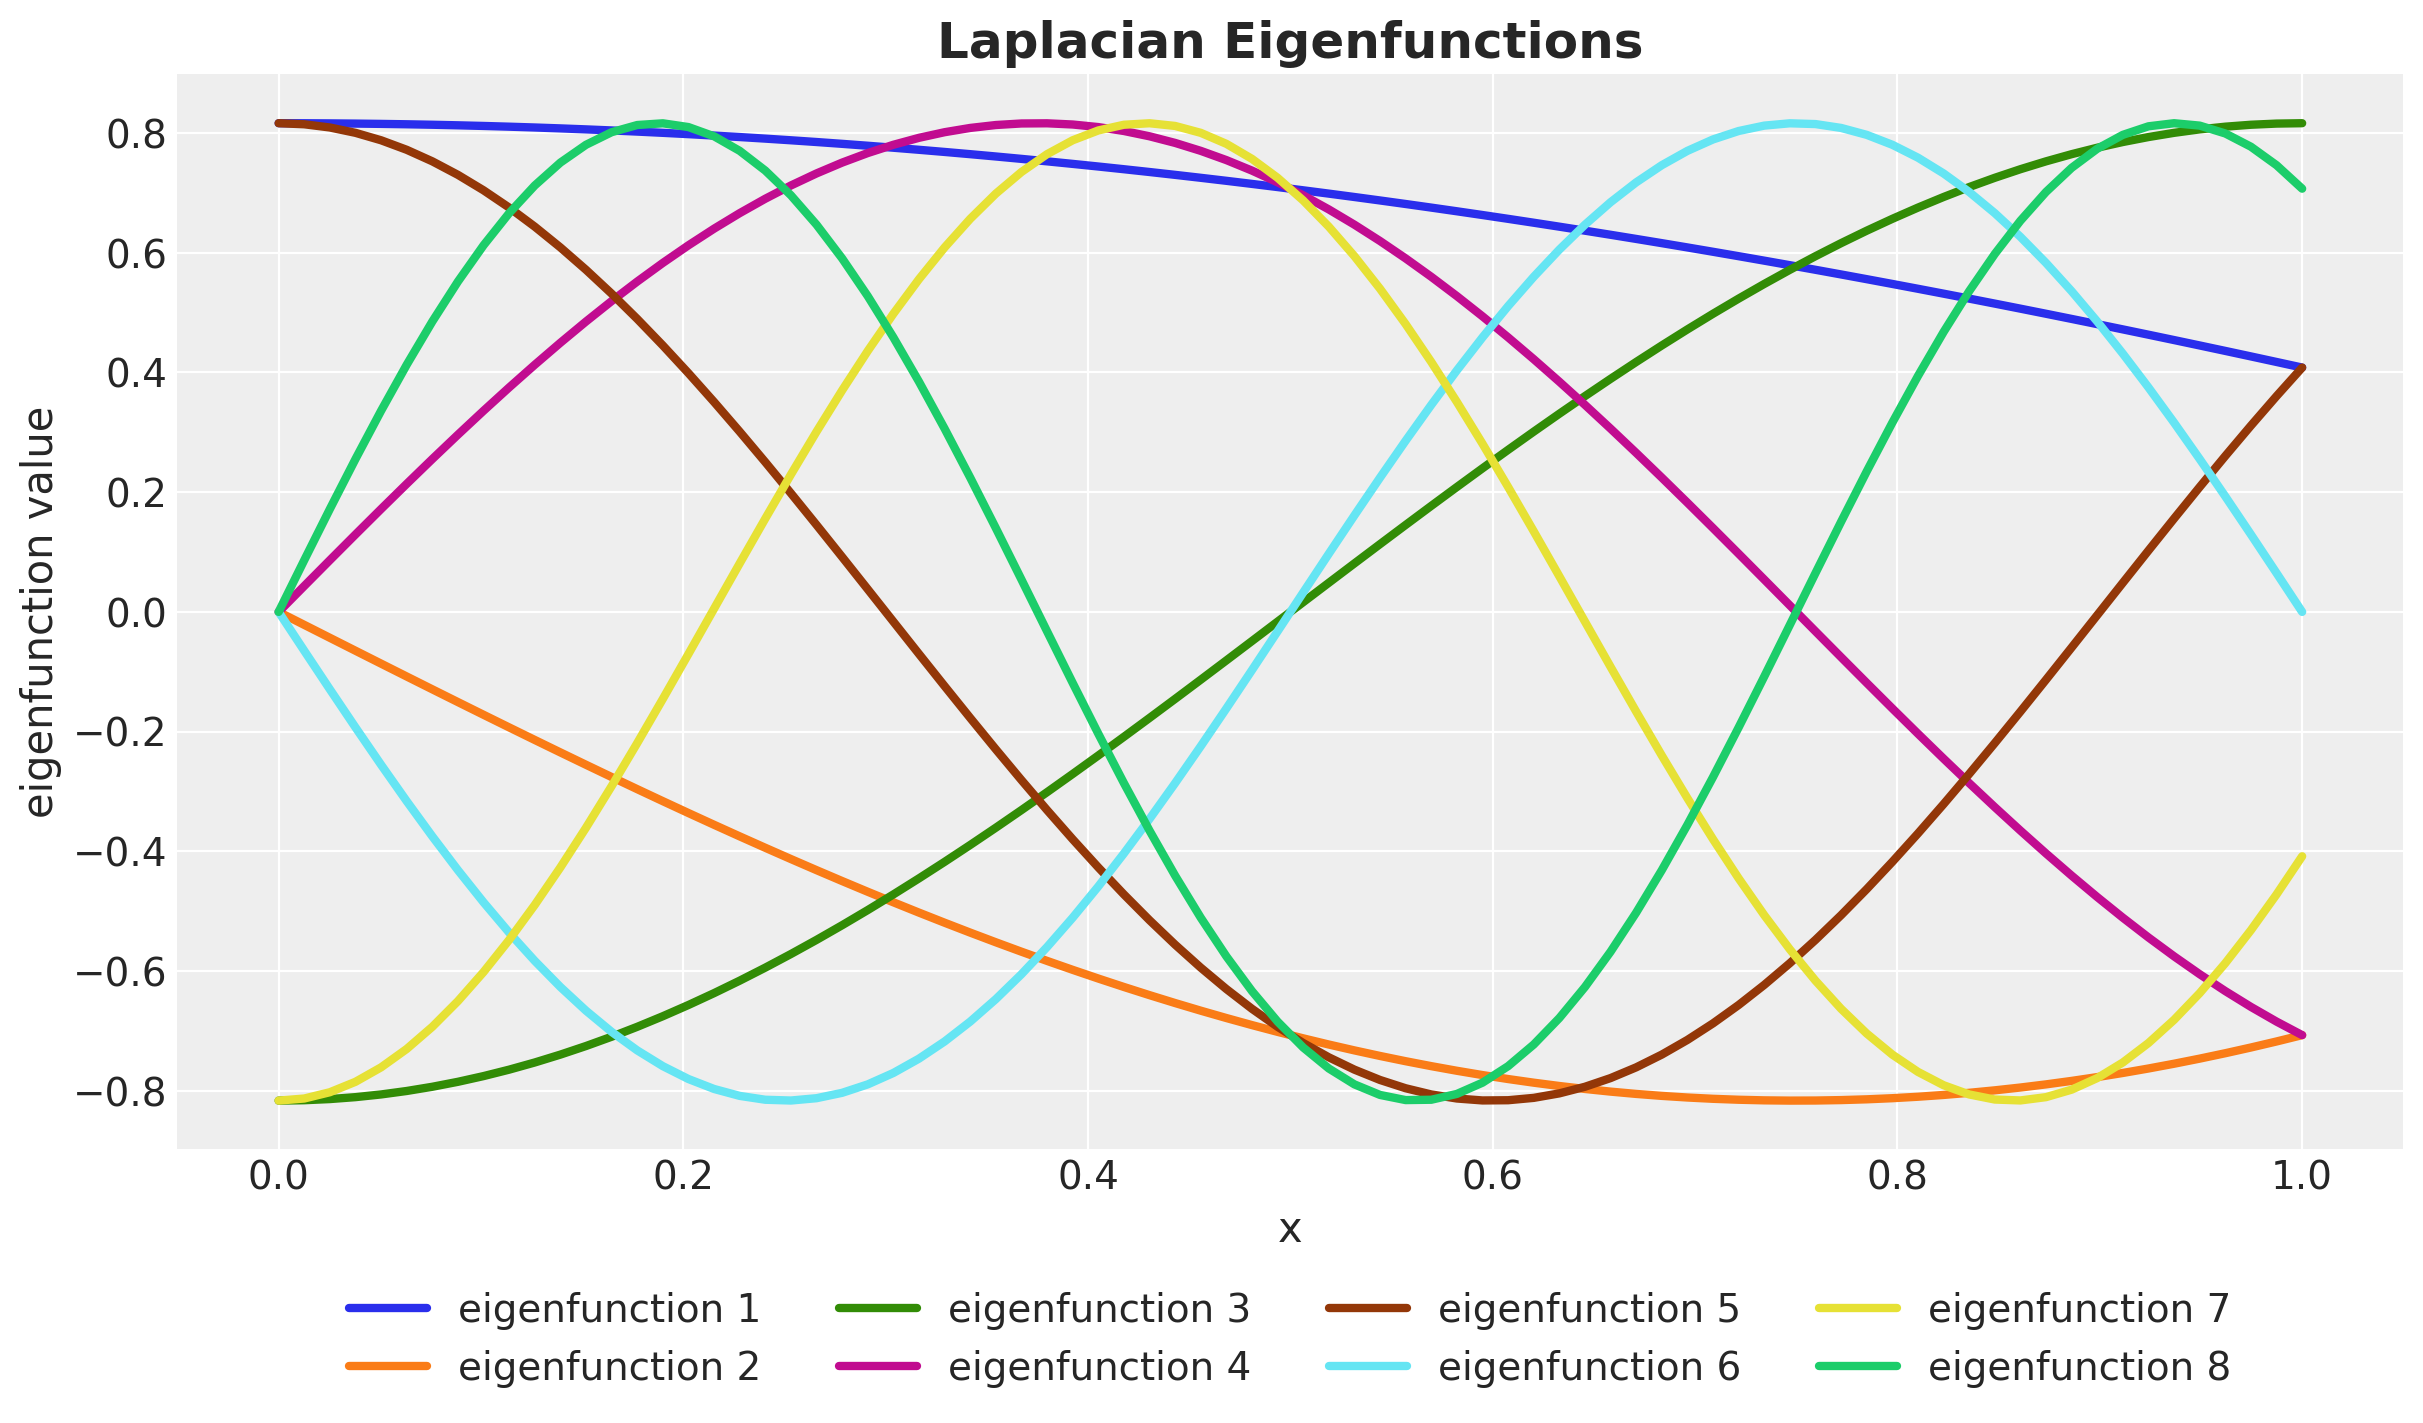

In [43]:
fig, ax = plt.subplots()
for i in range(m):
    ax.plot(
        x_train,
        phi[:, i],
        linewidth=3,
        c=f"C{i}",
        label=f"eigenfunction {i + 1}",
    )
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="eigenfunction value")
ax.set_title("Laplacian Eigenfunctions", fontsize=18, fontweight="bold");

**Remark:** Although it is not strictly necessary, it is recommended to center the training data `x_train` so that it has mean zero and it is symmetrically located in a bounded box $[-L, L]$. This is automatically handled in the PyMC implementation as we will see below (see ["Practical Hilbert space approximate Bayesian Gaussian processes for probabilistic programming"](https://link.springer.com/article/10.1007/s11222-022-10167-2)).

Now we can put everything together as a function that computes the Hilbert space approximation of the squared exponential kernel in one dimension:

In [45]:
def hs_approx_squared_exponential_ncp(x, amplitude, length_scale, l_max, m):
    phi = laplace_eigenfunctions(x, l_max, m)
    spd = jnp.sqrt(
        diag_squared_exponential_spectral_density(amplitude, length_scale, l_max, m)
    )
    with numpyro.plate("basis", m):
        beta = numpyro.sample("beta", dist.Normal(0, 1))

    return numpyro.deterministic("f", phi @ (spd * beta))

**Remark:** This implementation is using the so called *non-centered* parametrization. It is the same mathematical model but just written in a way that it samples more efficiently. This is a common practice in hierarchical models. The main idea is that sampling from a normal distribution

$$x \sim \text{Normal}(\mu, \sigma)$$

is equivalent to sampling from the standard normal distribution and then transforming the samples as

$$x = \mu + \sigma z \quad \text{with} \quad z \sim \text{Normal}(0, 1).$$

For details, see the example ["A Primer on Bayesian Methods for Multilevel Modeling"](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html).

In order to get a feeling on the implementation, let's sample from this component using the mean of the parameters (amplitude and length-scale) from the model fitted in the first part. We use take $40$ samples with $m=8$ eigenfunctions to approximate the kernel and we keep the box size $L=1.5$.

In [47]:
# prior sample from the HSGP component
def prior_sample_f_approx_se_ncp(rng_key, *args, **kwargs):
    model = seed(hs_approx_squared_exponential_ncp, rng_key)
    model_trace = trace(model).get_trace(*args, **kwargs)
    return model_trace["f"]["value"]


# set parameters
m = 8
l_max = 1.5
amplitude = gp_mcmc.get_samples()["kernel_amplitude"].mean()
length_scale = gp_mcmc.get_samples()["kernel_length_scale"].mean()

# vectorize the computation
# see https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Predictive-Utility-With-Effect-Handlers
vmap_prior_sample_f_approx_se_ncp = vmap(
    lambda rng_key: prior_sample_f_approx_se_ncp(
        rng_key=rng_key,
        x=x_train,
        amplitude=amplitude,
        length_scale=length_scale,
        l_max=l_max,
        m=m,
    ),
    in_axes=0,
    out_axes=-1,
)

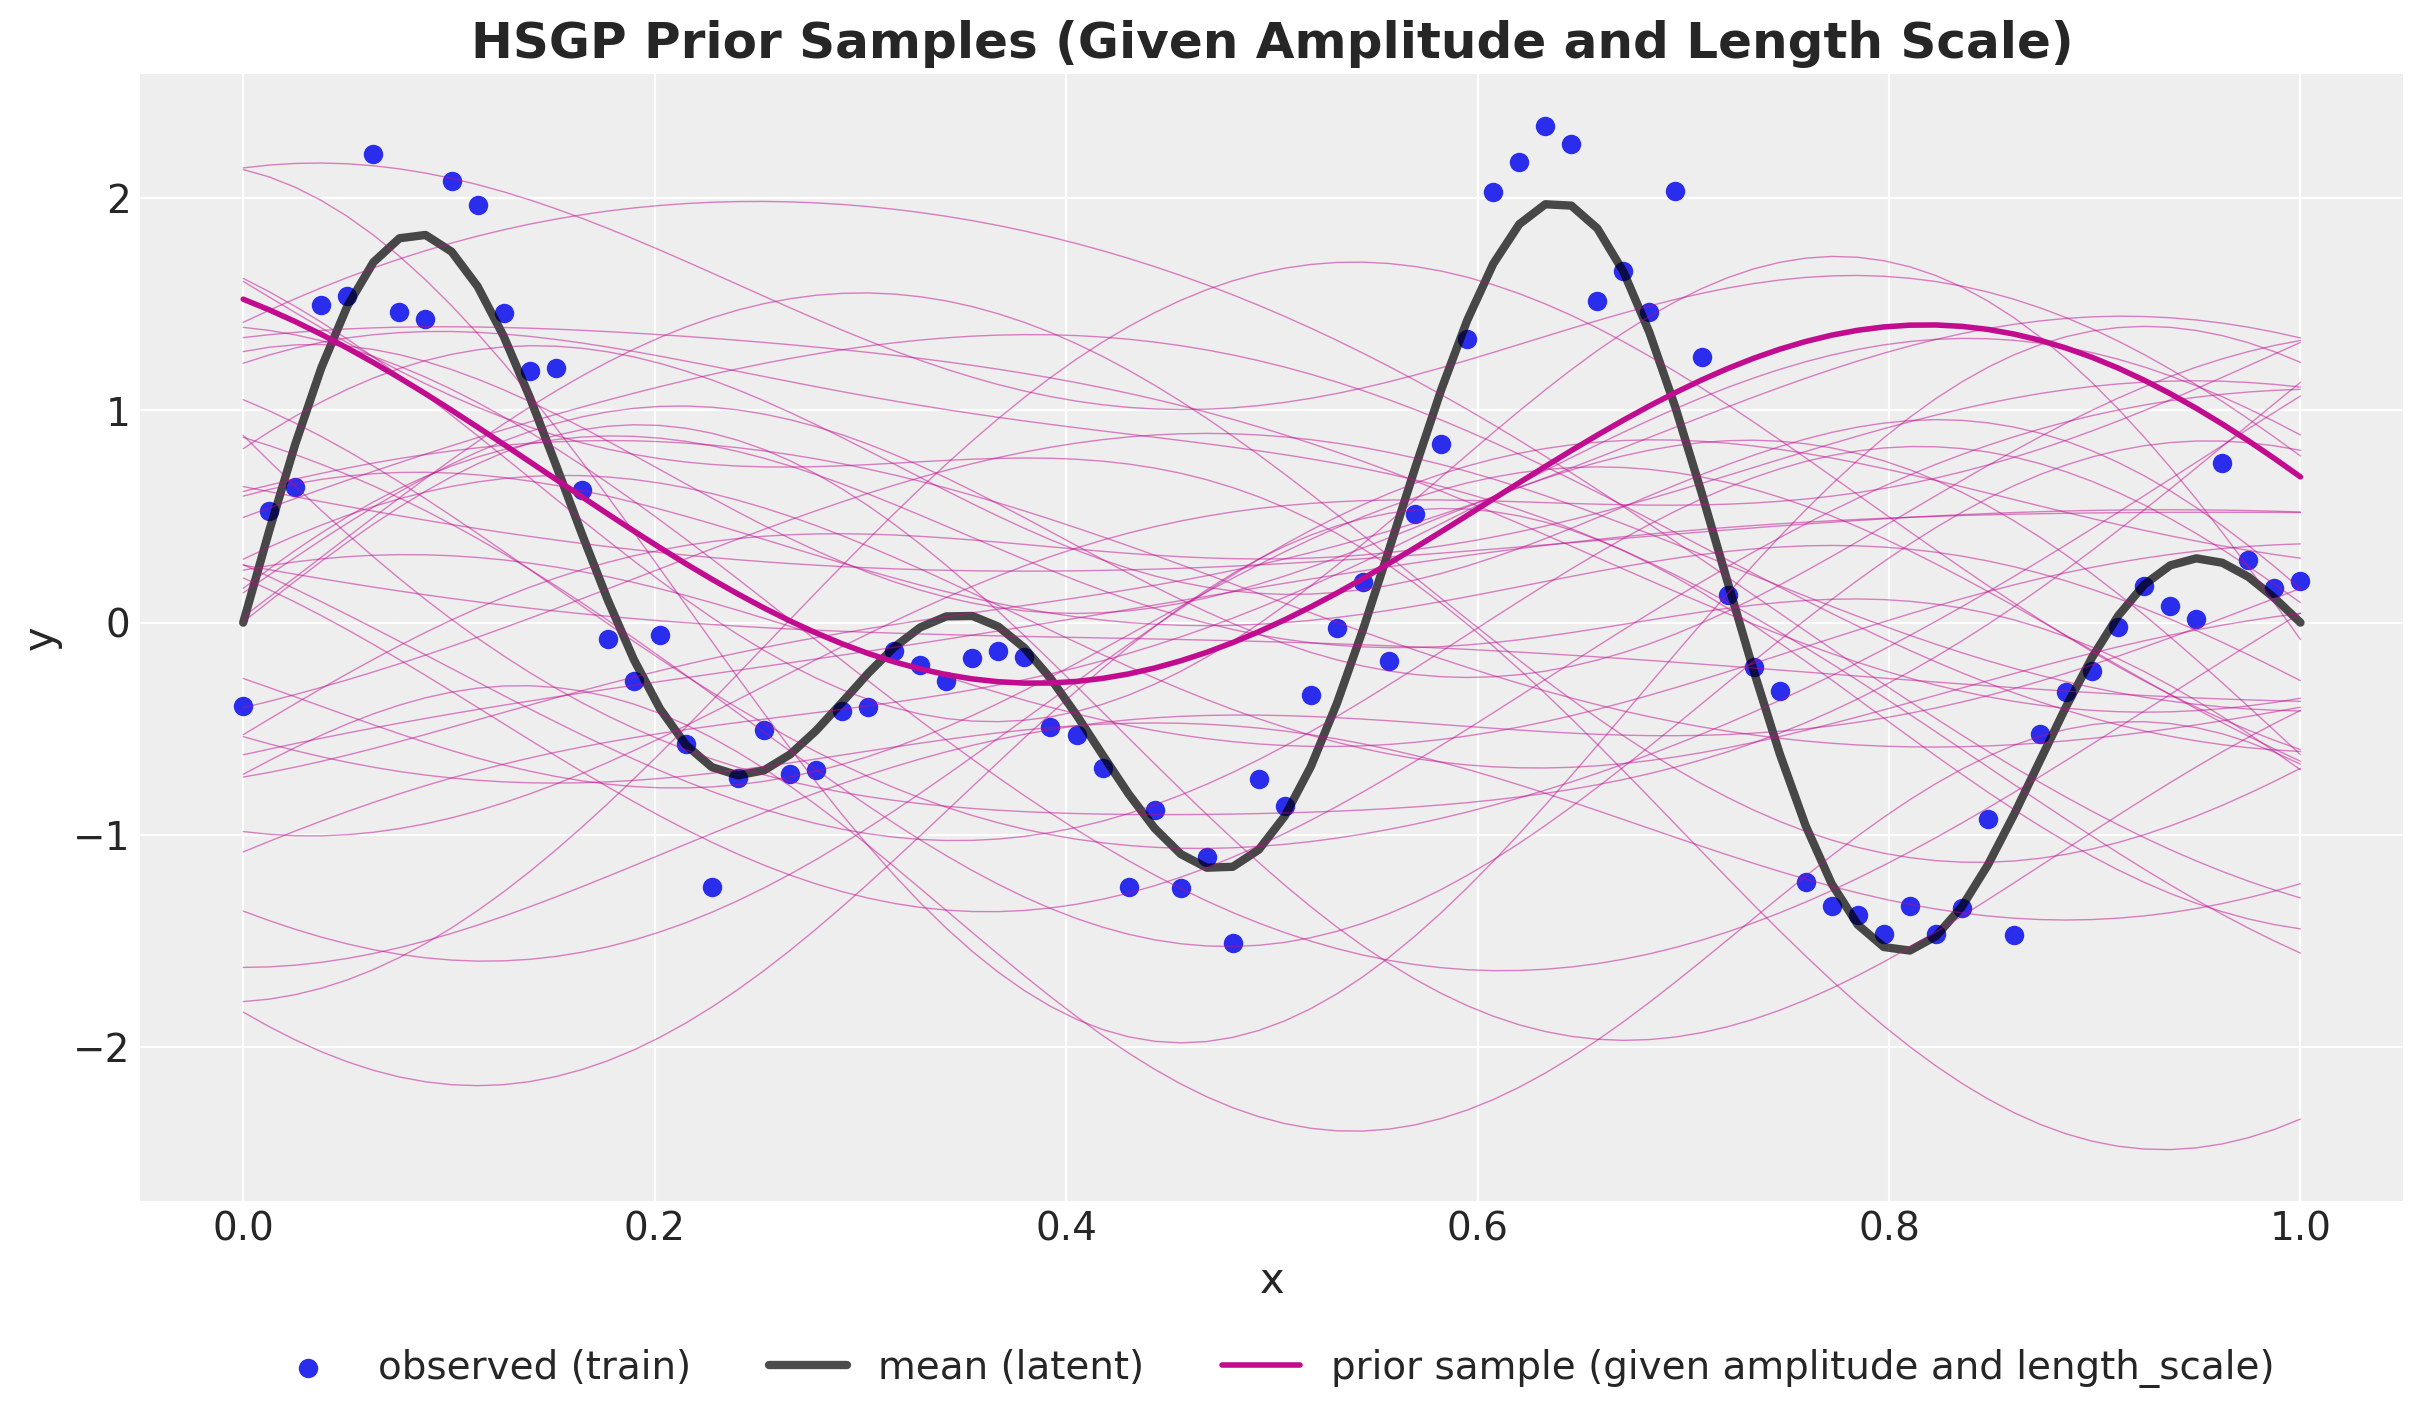

In [48]:
n_prior_samples = 40
rng_key, rng_subkey = random.split(rng_key)
prior_samples_f_approx_se_ncp = vmap_prior_sample_f_approx_se_ncp(
    rng_key=random.split(rng_subkey, n_prior_samples)
)

fig, ax = plt.subplots()
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.plot(x_train, prior_samples_f_approx_se_ncp, c="C3", alpha=0.5, linewidth=0.5)
ax.plot(
    x_train,
    prior_samples_f_approx_se_ncp[:, 0],
    c="C3",
    alpha=1,
    linewidth=2,
    label="prior sample (given amplitude and length_scale)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title(
    "HSGP Prior Samples (Given Amplitude and Length Scale)",
    fontsize=18,
    fontweight="bold",
);

These prior predictive samples look very reasonable!

### Model Specification

Having implemented the Hilbert space approximation component, we are ready to define the whole model in NumPyro. We use the same priors for the amplitude and length-scale parameters as in the first part. We also use the same priors for the noise parameter.

In [51]:
def hsgp_model(x, l_max, m, y=None) -> None:
    """Hilbert Space Gaussian Process (HSGP) model with a
    squared-exponential kernel in one dimension.

    Parameters
    ----------
    x : feature variable
    l_max : box size L (well, the box size is in fact 2L)
    m : number of eigenfunctions to select
    y : target variable
    """
    # --- Priors ---
    kernel_amplitude = numpyro.sample(
        "kernel_amplitude",
        dist.InverseGamma(
            concentration=inverse_gamma_params_2["alpha"],
            rate=inverse_gamma_params_2["beta"],
        ),
    )
    kernel_length_scale = numpyro.sample(
        "kernel_length_scale",
        dist.InverseGamma(
            concentration=inverse_gamma_params_1["alpha"],
            rate=inverse_gamma_params_1["beta"],
        ),
    )
    noise = numpyro.sample(
        "noise",
        dist.InverseGamma(
            concentration=inverse_gamma_params_2["alpha"],
            rate=inverse_gamma_params_2["beta"],
        ),
    )
    # --- Parametrization ---
    f = hs_approx_squared_exponential_ncp(
        x, kernel_amplitude, kernel_length_scale, l_max, m
    )
    # --- Likelihood ---
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("likelihood", dist.Normal(loc=f, scale=noise), obs=y)

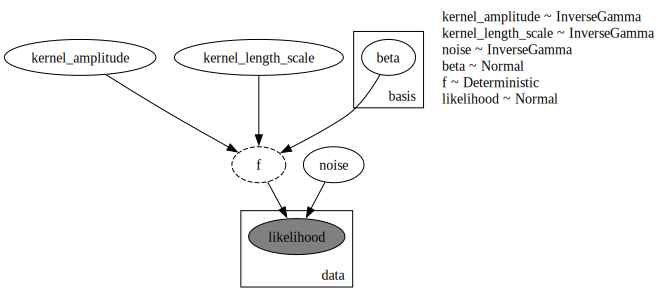

In [50]:
numpyro.render_model(
    model=hsgp_model,
    model_kwargs={"x": x_train, "l_max": 1.5, "m": 8, "y": y_train_obs},
    render_distributions=True,
    render_params=True,
)

### Prior Predictive Check

For this specific example we choose:

In [52]:
l_max = 1.3
m = 20

Before fitting the model to the data, we can use the model above to generate samples from the prior distribution over functions.

In [53]:
hsgp_numpyro_prior_predictive = Predictive(hsgp_model, num_samples=1_000)
rng_key, rng_subkey = random.split(rng_key)
hsgp_numpyro_prior_samples = hsgp_numpyro_prior_predictive(
    rng_subkey, x_train, l_max, m
)

hsgp_numpyro_prior_idata = az.from_numpyro(prior=hsgp_numpyro_prior_samples)

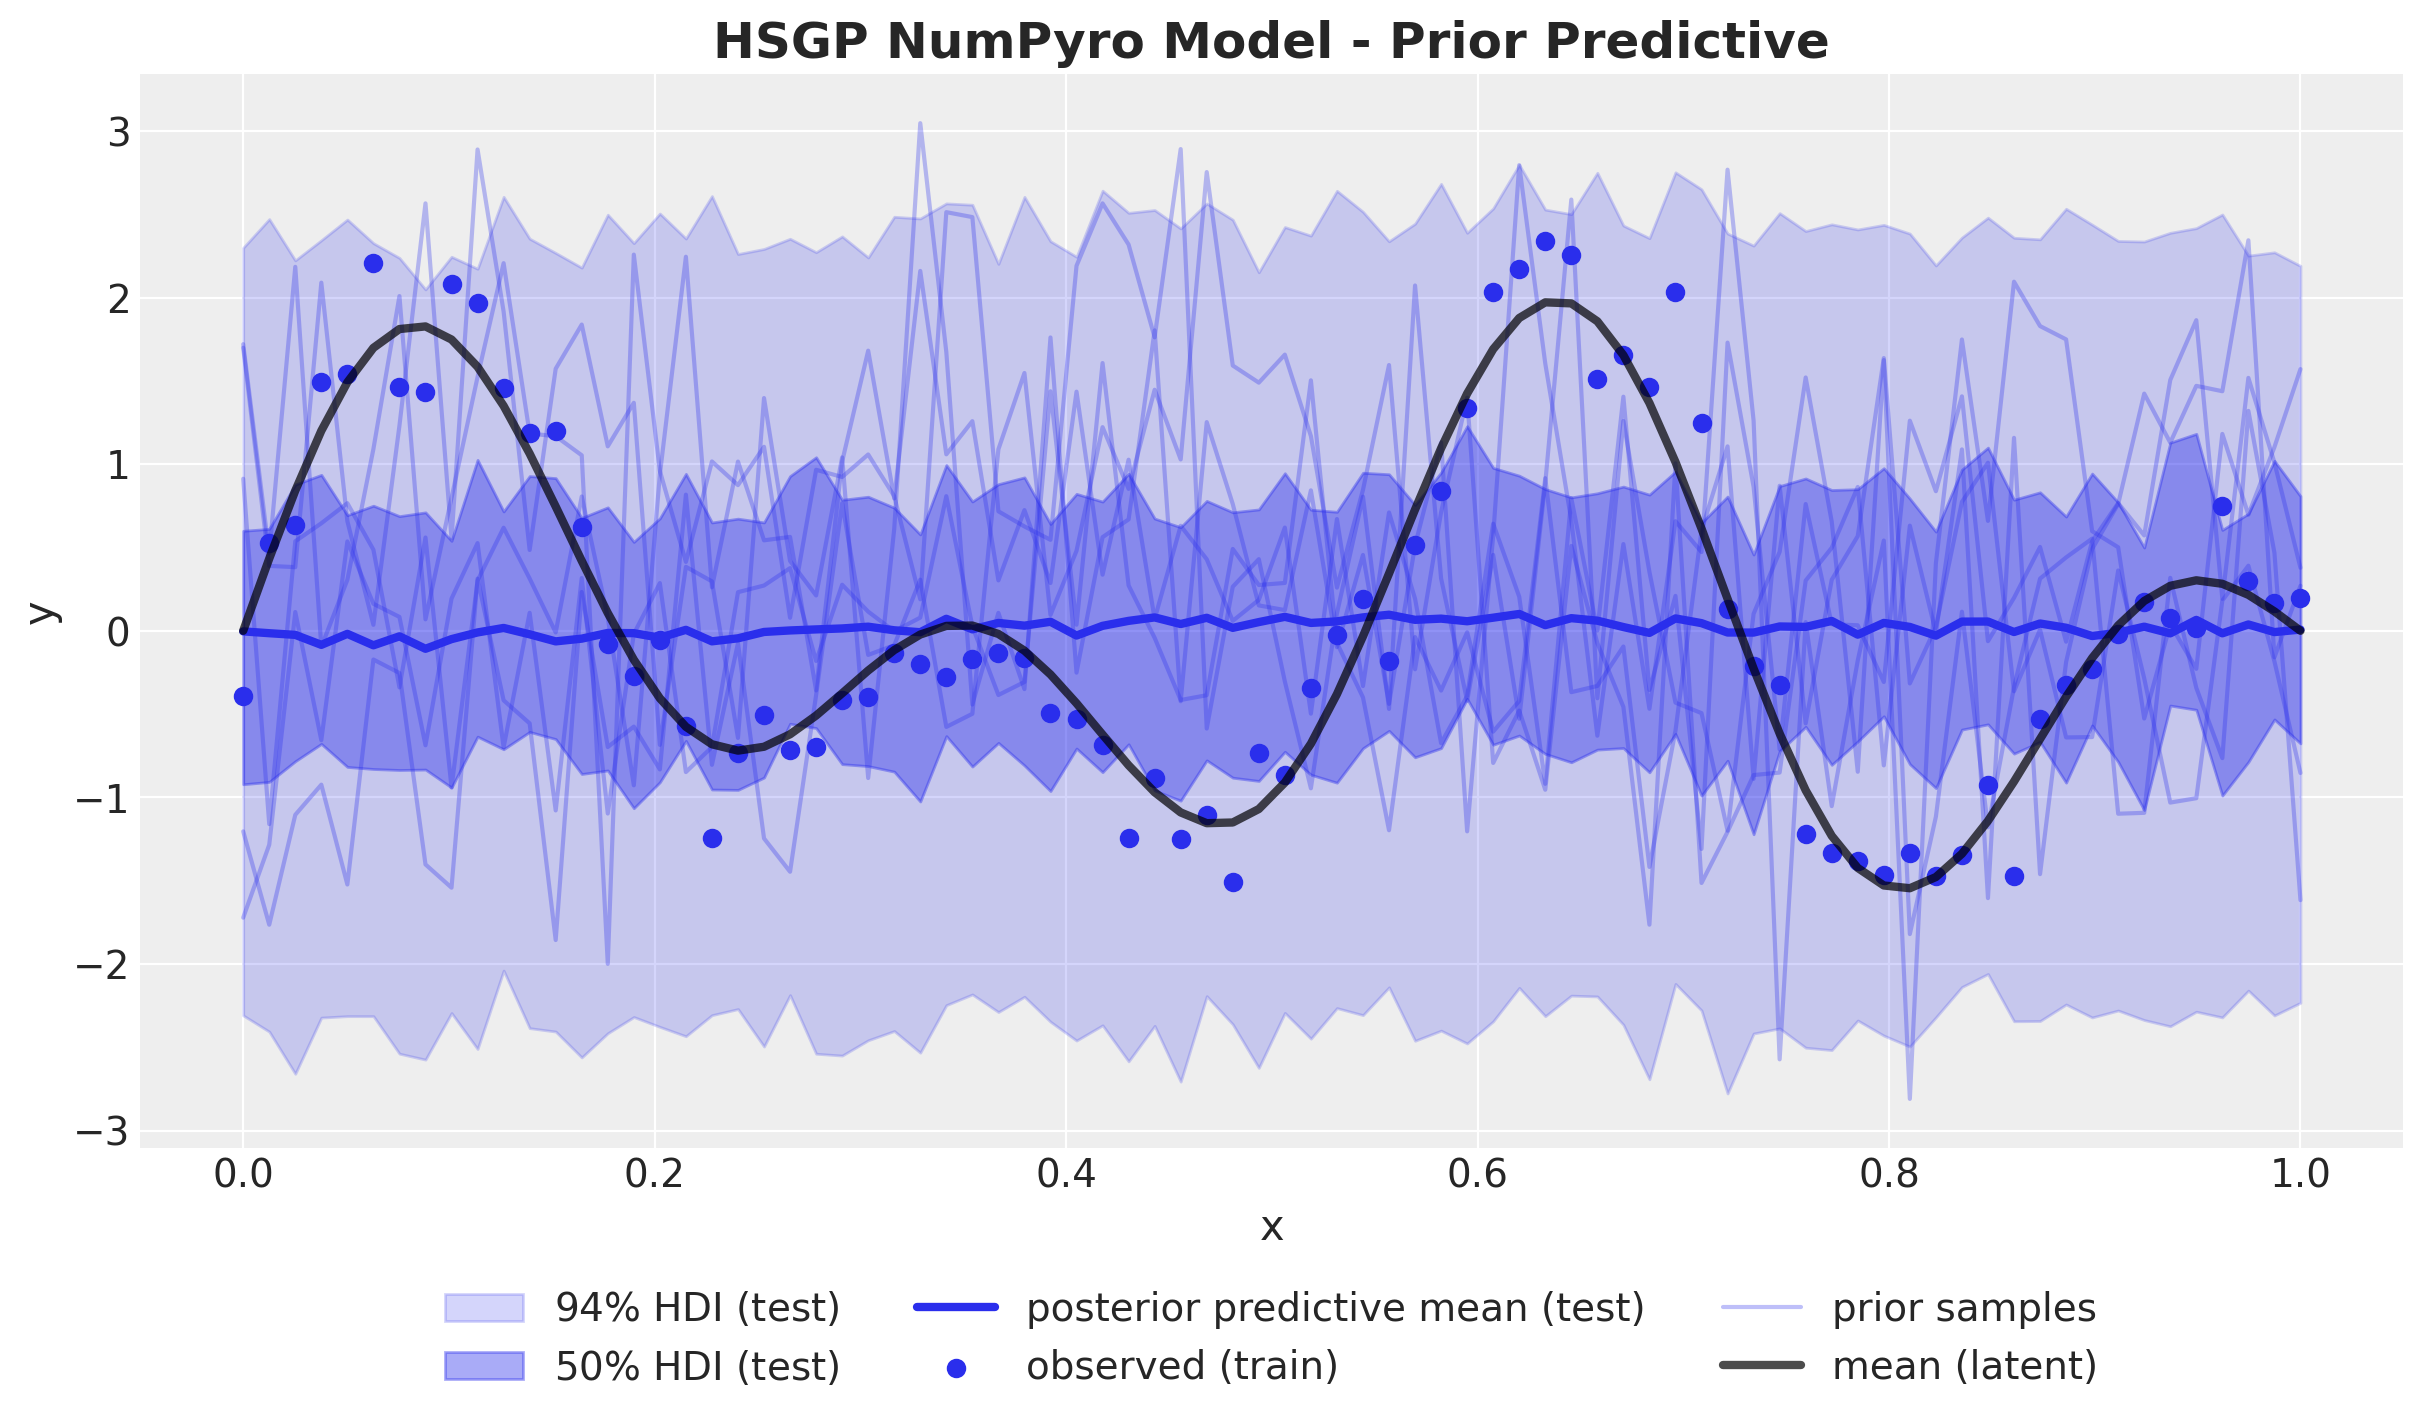

In [54]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_train,
    hsgp_numpyro_prior_idata.prior["likelihood"],
    hdi_prob=0.94,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_train,
    hsgp_numpyro_prior_idata.prior["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_train,
    hsgp_numpyro_prior_idata.prior["likelihood"].mean(dim=("chain", "draw")),
    color="C0",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
for i in range(5):
    label = "prior samples" if i == 0 else None
    ax.plot(
        x_train,
        hsgp_numpyro_prior_idata.prior["likelihood"].sel(chain=0, draw=i),
        color="C0",
        alpha=0.3,
        label=label,
    )
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("HSGP NumPyro Model - Prior Predictive", fontsize=18, fontweight="bold");

The prior predictive samples look similar to the ones from the first part (vanilla Gaussian process model).

### Model Fitting

We can fit the model as usual:

In [55]:
rng_key, rng_subkey = random.split(rng_key)
hsgp_mcmc = run_inference(
    rng_subkey,
    hsgp_model,
    inference_params,
    x_train,
    l_max,
    m,
    y_train_obs,
    target_accept_prob=0.9,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Observe that it runs very fast!

### Model Diagnostics

The model diagnostics look good:

In [56]:
hsgp_numpyro_idata = az.from_numpyro(posterior=hsgp_mcmc)

az.summary(
    data=hsgp_numpyro_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise", "beta"],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel_amplitude     1.284  0.255   0.832    1.736      0.004    0.003   
kernel_length_scale  0.077  0.012   0.055    0.099      0.000    0.000   
noise                0.327  0.029   0.274    0.381      0.000    0.000   
beta[0]             -0.123  0.657  -1.354    1.122      0.008    0.007   
beta[1]             -0.005  0.718  -1.412    1.277      0.008    0.008   
beta[2]             -0.004  0.690  -1.279    1.293      0.008    0.008   
beta[3]              0.231  0.738  -1.105    1.635      0.009    0.008   
beta[4]             -0.175  0.707  -1.510    1.148      0.008    0.009   
beta[5]              0.045  0.760  -1.412    1.432      0.009    0.009   
beta[6]             -0.374  0.734  -1.783    1.014      0.008    0.008   
beta[7]              0.425  0.758  -1.020    1.844      0.008    0.008   
beta[8]              0.607  0.746  -0.722    2.079      0.009    0.007   
beta[9]             -1.312  0.775  -2.766    0.145      0.008    0.007   
beta[10]             0.288  0.736  -1.039    1.728      0.008    0.008   
beta[11]             1.006  0.770  -0.451    2.425      0.008    0.007   
beta[12]            -0.758  0.758  -2.180    0.665      0.008    0.007   
beta[13]             0.020  0.738  -1.402    1.348      0.009    0.008   
beta[14]            -0.406  0.730  -1.790    0.938      0.009    0.007   
beta[15]             0.650  0.721  -0.731    1.961      0.008    0.007   
beta[16]             0.952  0.728  -0.418    2.293      0.008    0.007   
beta[17]            -2.394  0.783  -3.815   -0.904      0.009    0.007   
beta[18]             1.222  0.662  -0.064    2.408      0.008    0.006   
beta[19]             0.999  0.552  -0.024    2.066      0.007    0.005   

                     ess_bulk  ess_tail  r_hat  
kernel_amplitude       3935.0    4678.0    1.0  
kernel_length_scale    7642.0    5672.0    1.0  
noise                  8272.0    5553.0    1.0  
beta[0]                7568.0    6171.0    1.0  
beta[1]                7198.0    5696.0    1.0  
beta[2]                7163.0    5513.0    1.0  
beta[3]                6324.0    5263.0    1.0  
beta[4]                8021.0    5575.0    1.0  
beta[5]                7289.0    5631.0    1.0  
beta[6]                7987.0    5436.0    1.0  
beta[7]                8480.0    5932.0    1.0  
beta[8]                7418.0    5938.0    1.0  
beta[9]                8503.0    5863.0    1.0  
beta[10]               8091.0    5259.0    1.0  
beta[11]               8238.0    5303.0    1.0  
beta[12]               8026.0    5617.0    1.0  
beta[13]               6945.0    5512.0    1.0  
beta[14]               7360.0    5045.0    1.0  
beta[15]               7484.0    5694.0    1.0  
beta[16]               7930.0    5471.0    1.0  
beta[17]               7362.0    6074.0    1.0  
beta[18]               7376.0    6064.0    1.0  
beta[19]               7016.0    5376.0    1.0

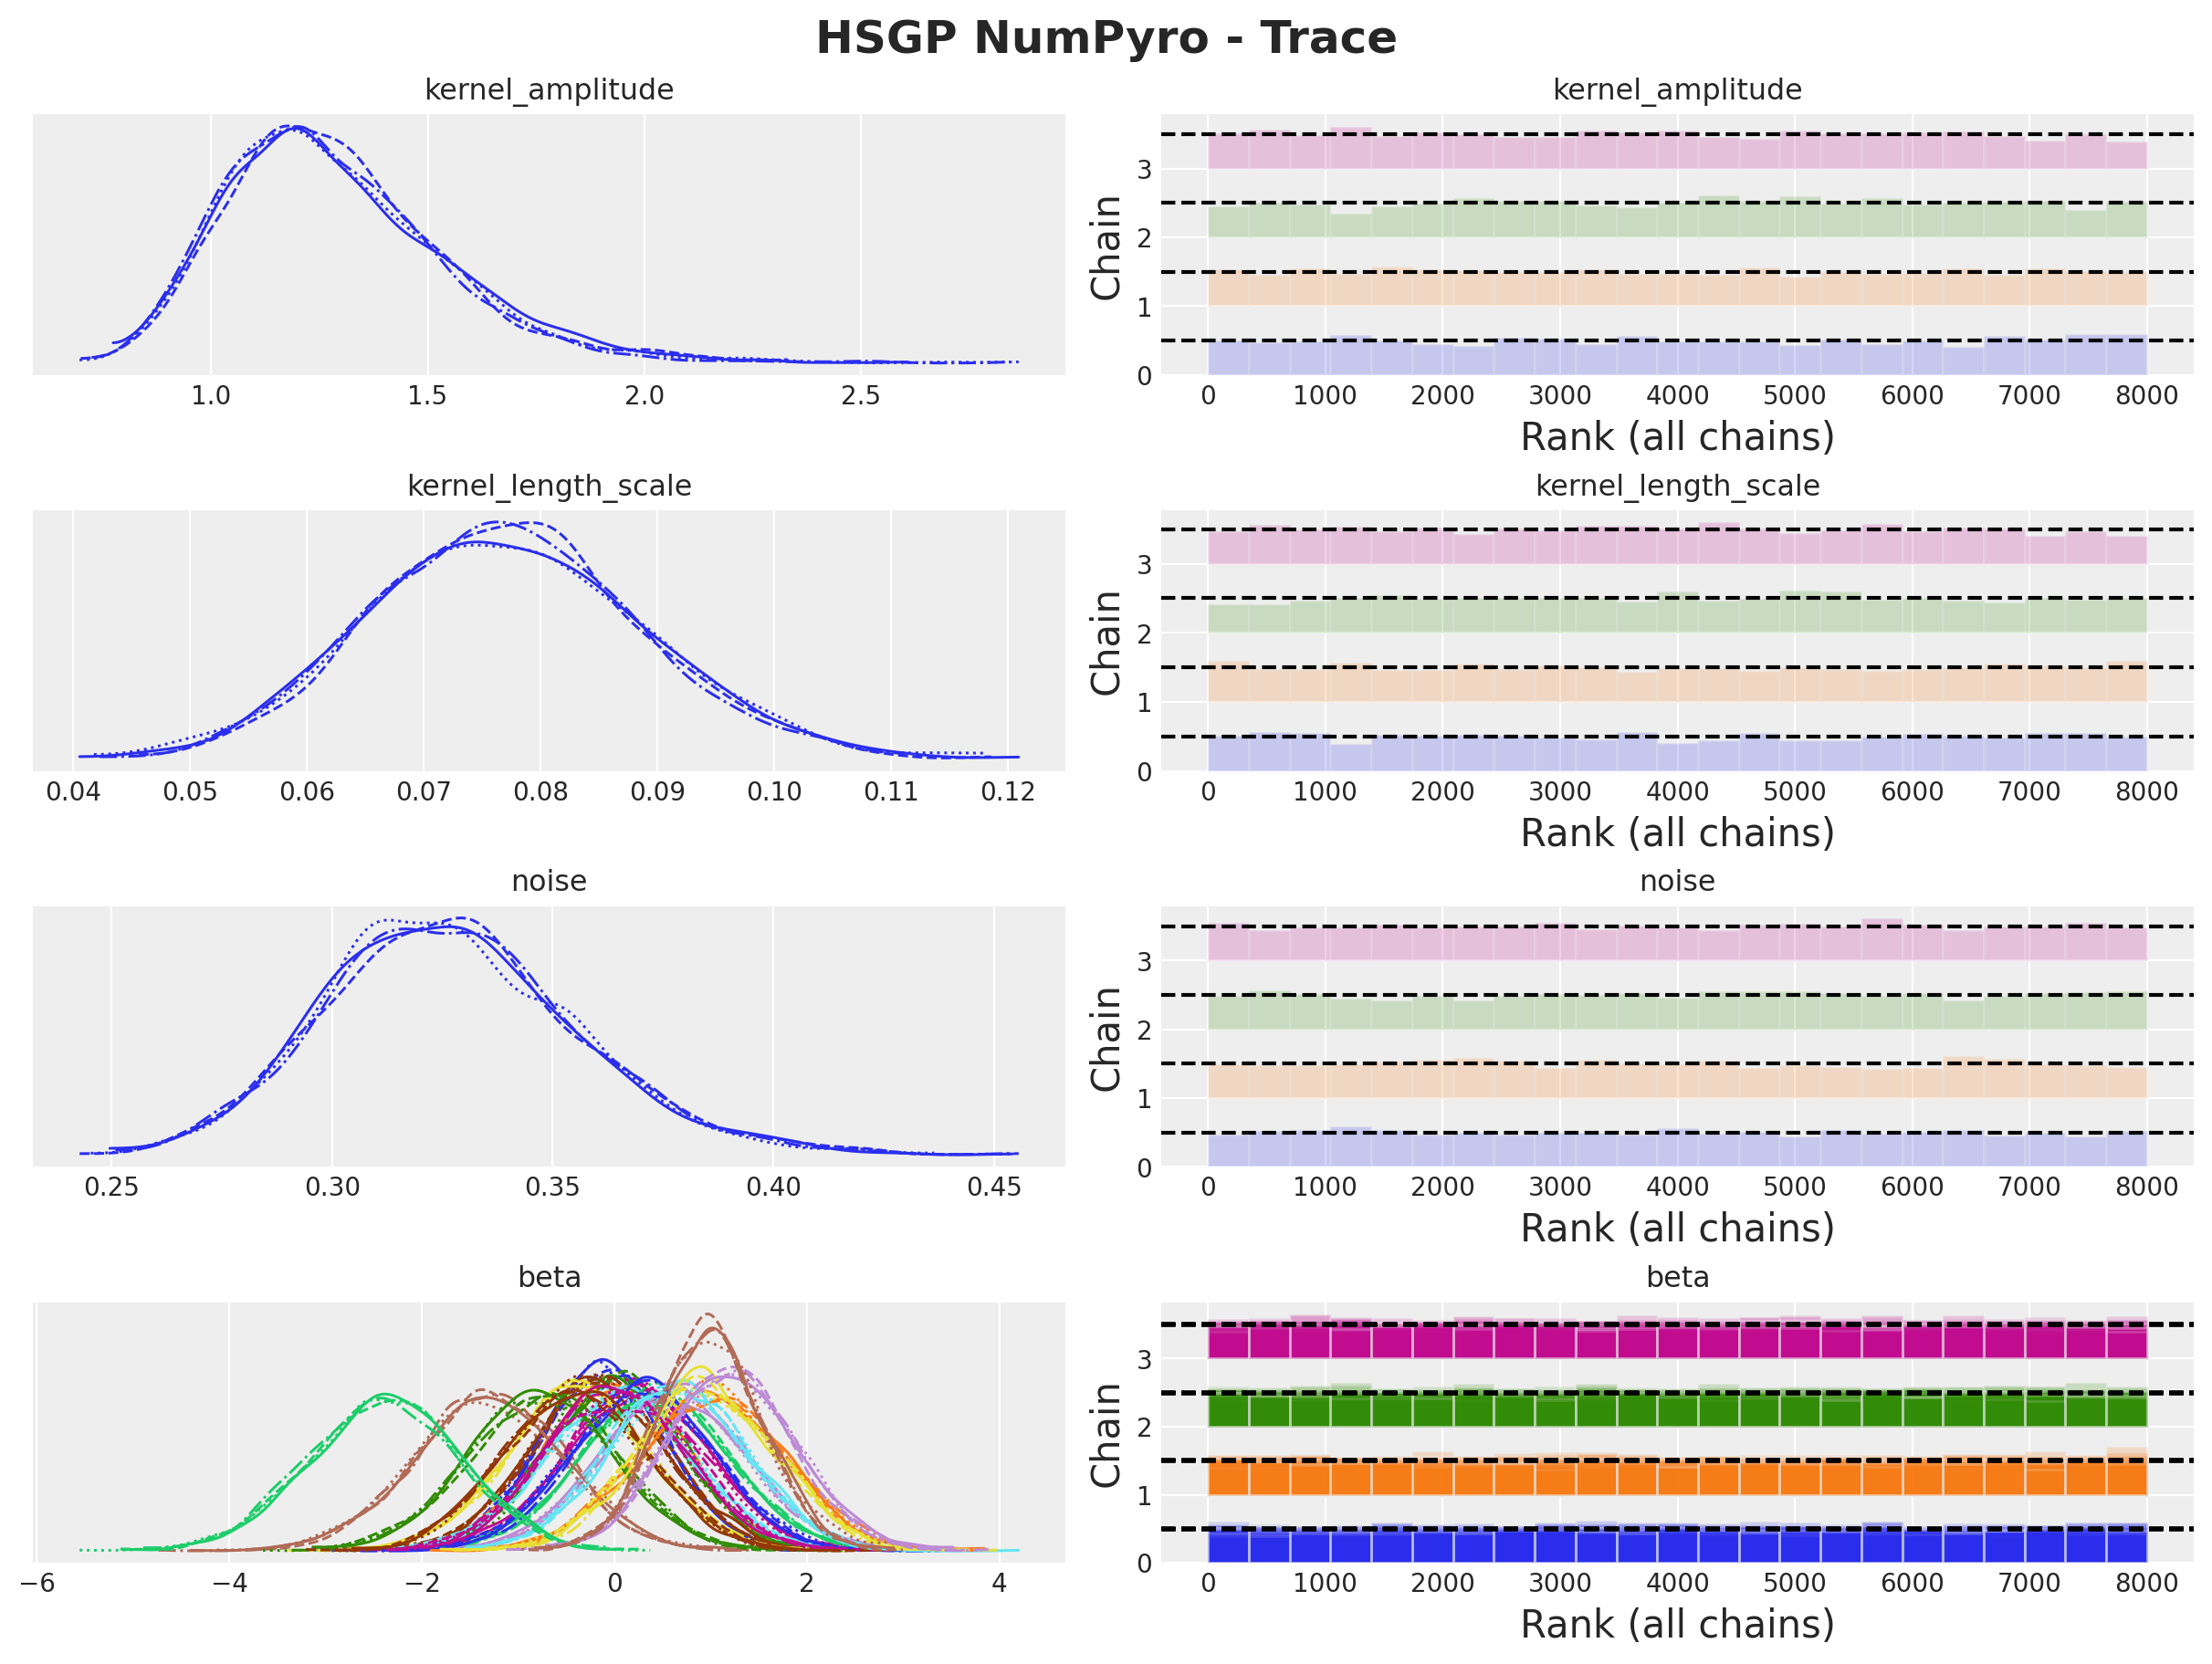

In [57]:
axes = az.plot_trace(
    data=hsgp_numpyro_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise", "beta"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("HSGP NumPyro - Trace", fontsize=18, fontweight="bold");

We can compare the posterior distributions of the parameters of the Hilbert space approximation with the ones of the Gaussian process model:

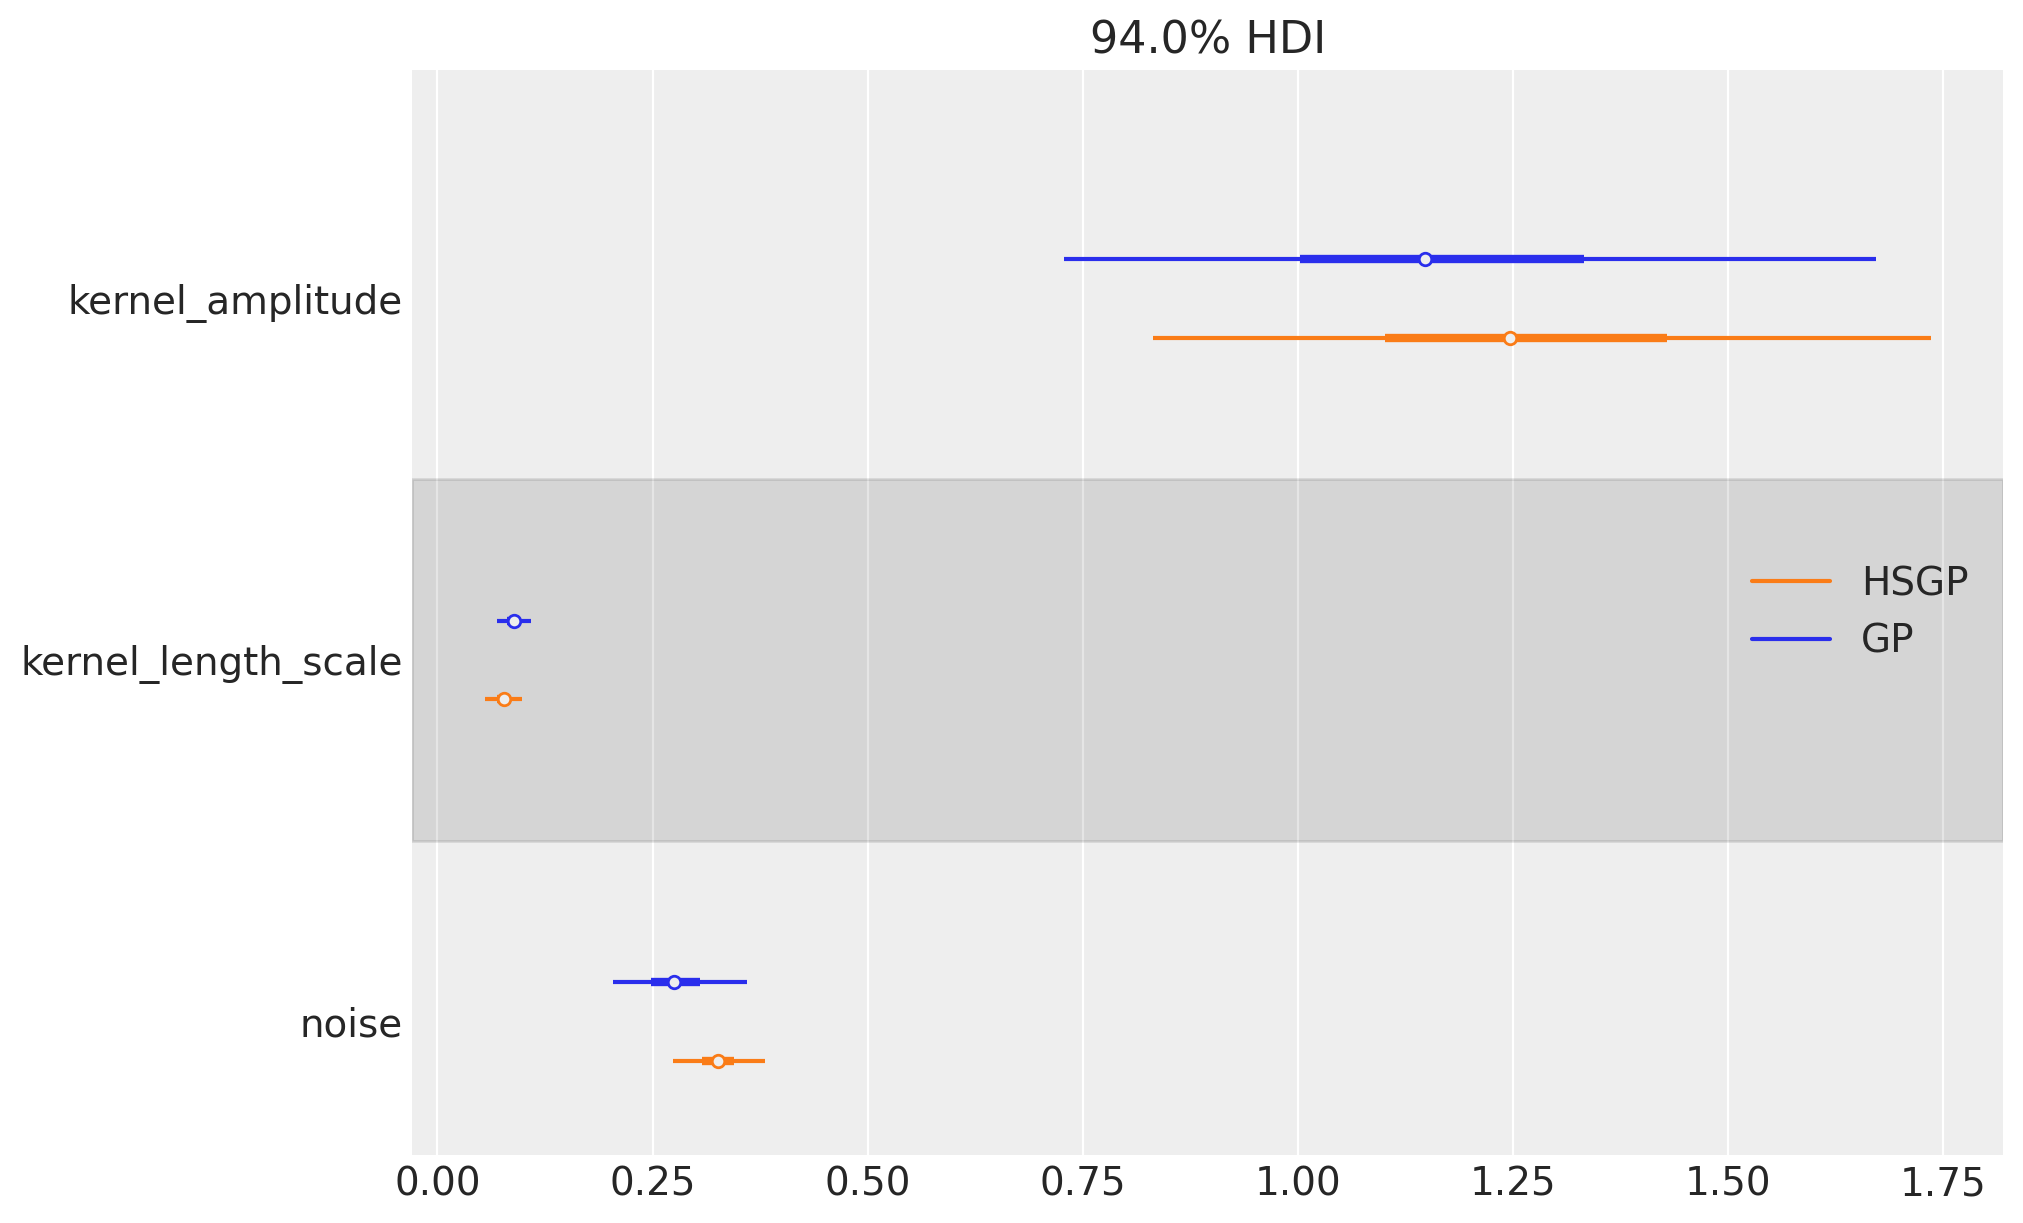

In [63]:
axes = az.plot_forest(
    data=[gp_numpyro_idata, hsgp_numpyro_idata],
    model_names=["GP", "HSGP"],
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    combined=True,
    hdi_prob=0.94,
    figsize=(10, 6),
);

They look very similar!

### Out of Sample Prediction

Finally, we can generate samples from the posterior distribution over functions on the test set. Note that we need to ensure these values lie inside the approximation domain $[-L, L]$.

In [64]:
hpgp_mcmc_samples_no_f = {
    k: v for (k, v) in hsgp_mcmc.get_samples().items() if k != "f"
}

rng_key, rng_subkey = random.split(rng_key)
hsgp_numpyro_idata.extend(
    az.from_numpyro(
        posterior_predictive=Predictive(hsgp_model, hpgp_mcmc_samples_no_f)(
            rng_subkey, x_test, l_max, m
        )
    )
)

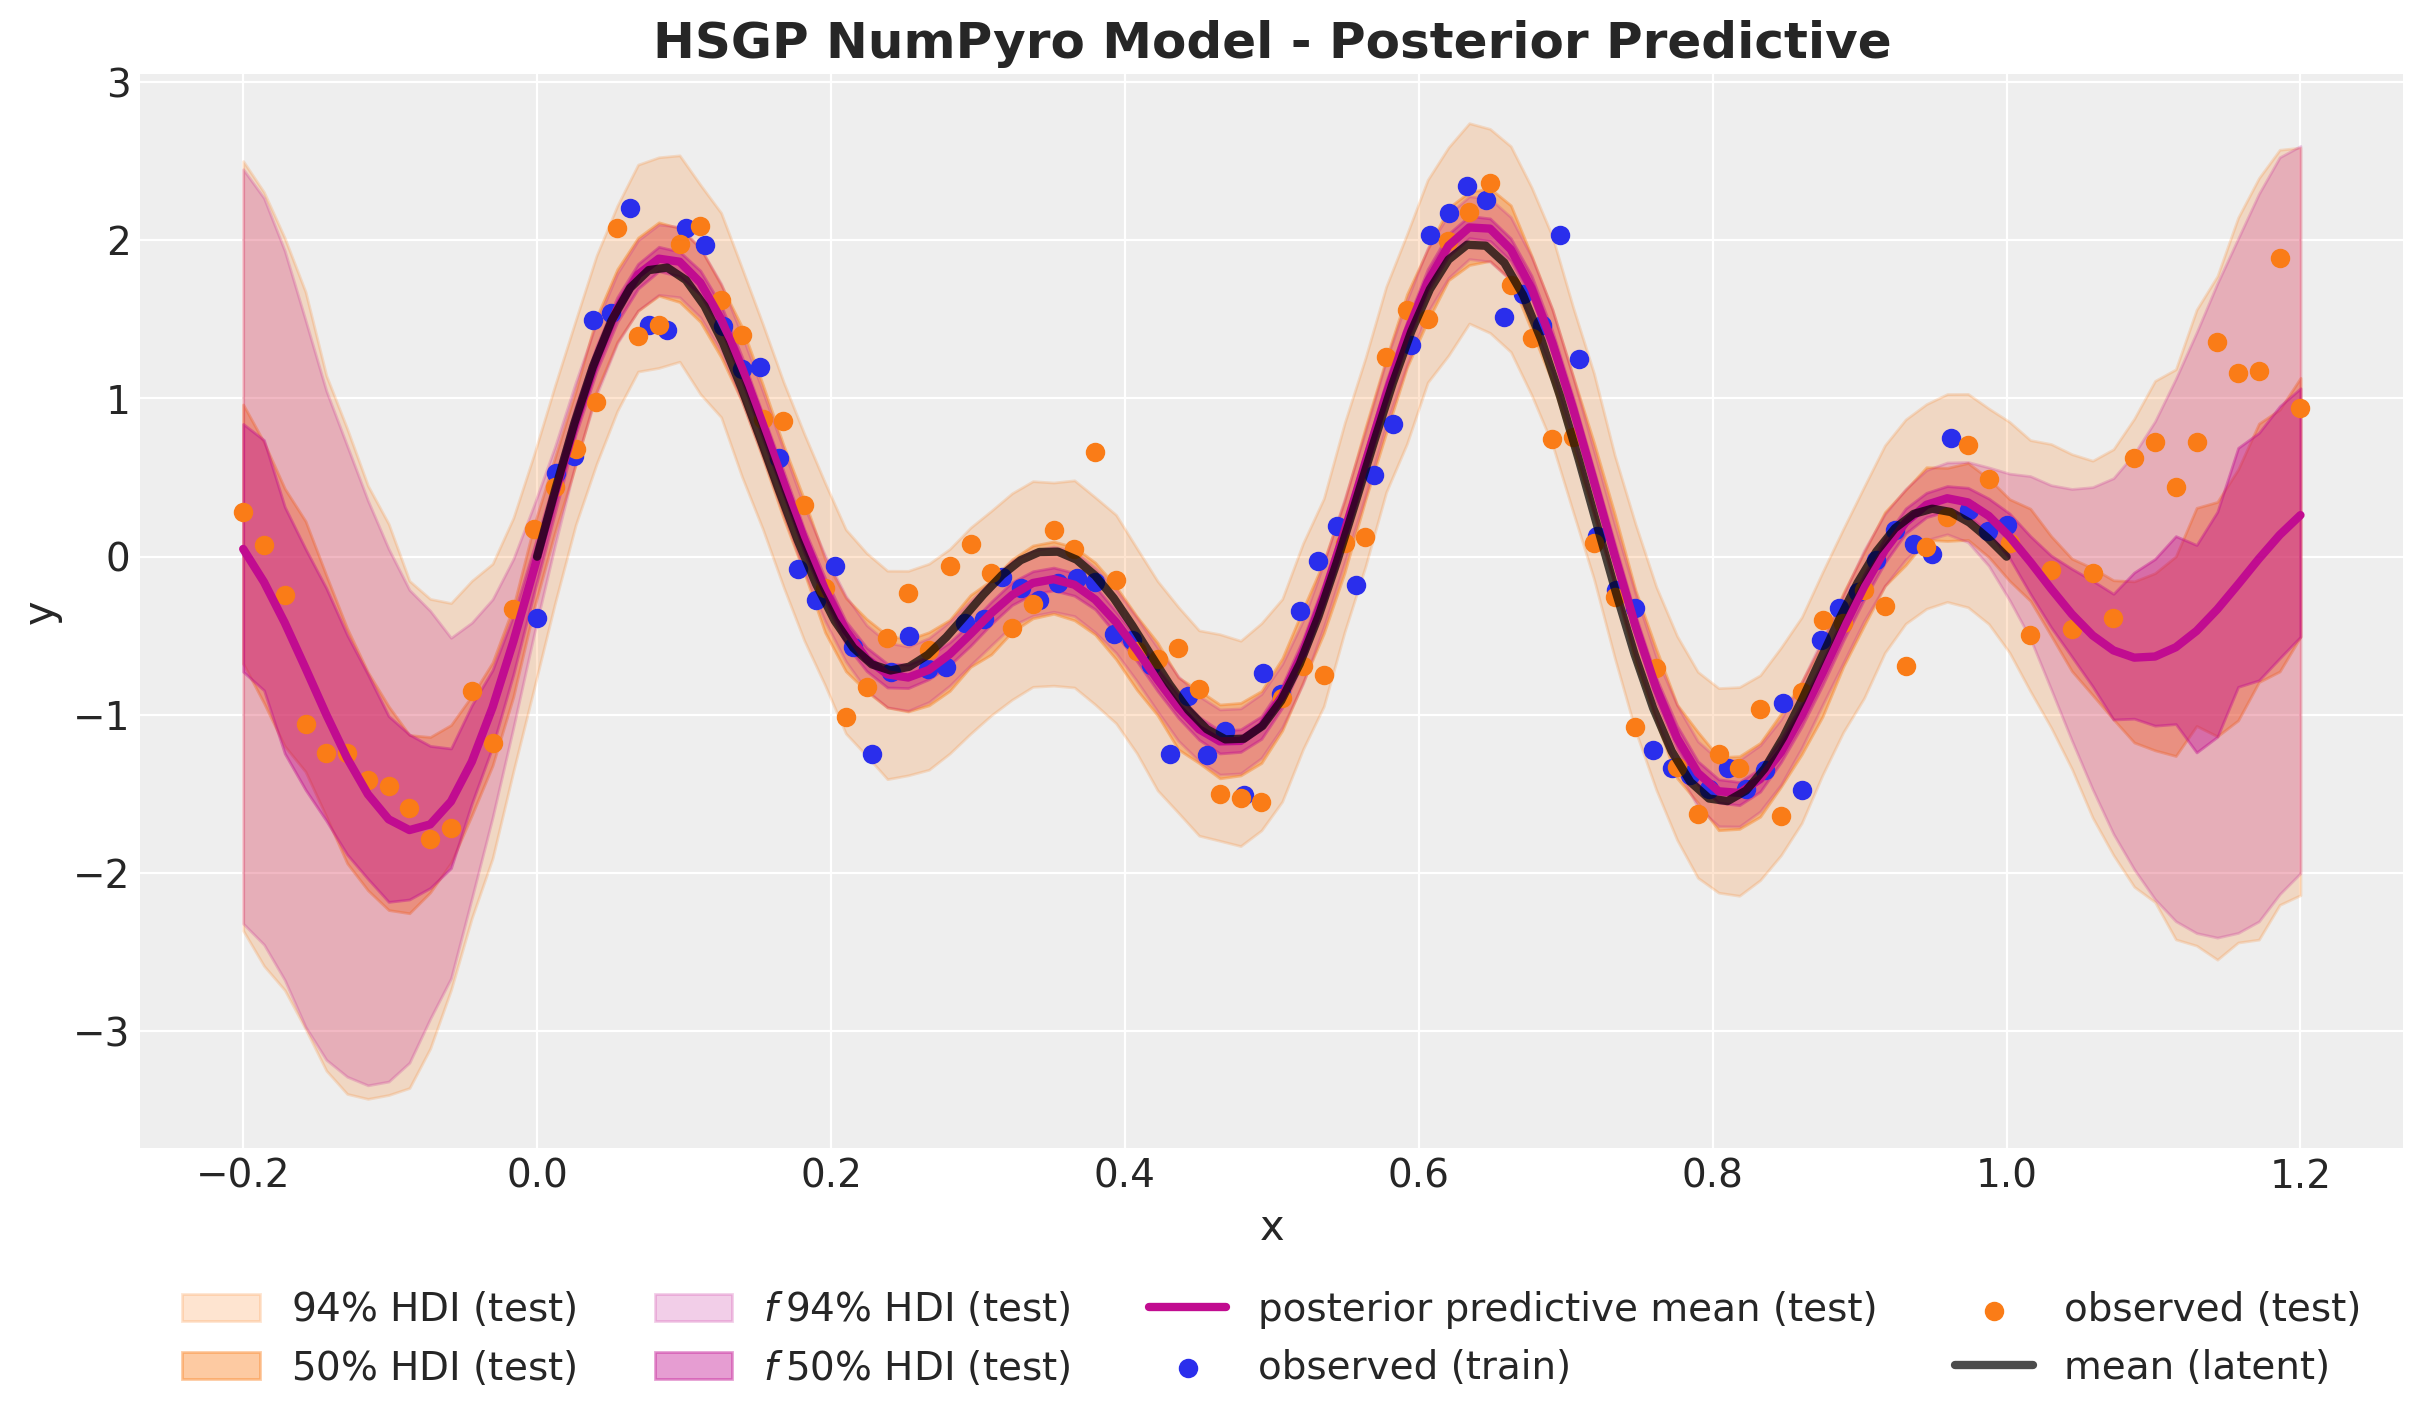

In [65]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    hsgp_numpyro_idata.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_numpyro_idata.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_numpyro_idata.posterior_predictive["f"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$f \\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_numpyro_idata.posterior_predictive["f"],
    hdi_prob=0.5,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$f \\: 50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    hsgp_numpyro_idata.posterior_predictive["f"].mean(dim=("chain", "draw")),
    color="C3",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title(
    "HSGP NumPyro Model - Posterior Predictive", fontsize=18, fontweight="bold"
);

We have successfully implemented the Hilbert space Gaussian process approximation in NumPyro and applied it to the same synthetic data as in the first part. The results look very good 🚀!

Next, let's see how to leverage PyMC's API to do the same!

## PyMC Hilbert Space Gaussian Process Model

### [`HSGP.prior`](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/classmethods/pymc.gp.HSGP.prior.html#pymc.gp.HSGP.prior)

In [ ]:
with pm.Model() as hsgp_pymc_model:
    x_data = pm.MutableData("x_data", value=x_train)
    y_data = pm.MutableData("y_data", y_train_obs)

    kernel_amplitude = pm.InverseGamma(
        "kernel_amplitude",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )
    kernel_length_scale = pm.InverseGamma(
        "kernel_length_scale",
        alpha=inverse_gamma_params_1["alpha"],
        beta=inverse_gamma_params_1["beta"],
    )
    noise = pm.InverseGamma(
        "noise",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )

    mean = pm.gp.mean.Zero()
    cov = kernel_amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=kernel_length_scale)
    gp = pm.gp.HSGP(m=[20], L=[1.3], mean_func=mean, cov_func=cov)
    f = gp.prior("f", X=x_data[:, None])

    pm.Normal("likelihood", mu=f, sigma=noise, observed=y_data)


pm.model_to_graphviz(model=hsgp_pymc_model)

In [ ]:
rng_key, rng_subkey = random.split(rng_key)

with hsgp_pymc_model:
    hsgp_pymc_idata = pm.sample(
        target_accept=0.9,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

In [ ]:
axes = az.plot_trace(
    data=hsgp_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("HSGP PyMC - Trace", fontsize=18, fontweight="bold");

In [ ]:
with hsgp_pymc_model:
    x_star_data = pm.MutableData("x_star_data", x_test)
    f_star = gp.conditional("f_star", x_star_data[:, None])
    pm.set_data({"x_data": x_test, "y_data": np.ones_like(x_test)})
    hsgp_pymc_idata.extend(
        pm.sample_posterior_predictive(
            trace=hsgp_pymc_idata,
            var_names=["f_star", "likelihood"],
            random_seed=rng_subkey[1].item(),
        )
    )

In [ ]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    hsgp_pymc_idata.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$\\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_pymc_idata.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$\\: 50\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_pymc_idata.posterior_predictive["f_star"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$f \\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_pymc_idata.posterior_predictive["f_star"],
    hdi_prob=0.5,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$f \\: 50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    hsgp_pymc_idata.posterior_predictive["f_star"].mean(dim=("chain", "draw")),
    color="C3",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title("HSGP PyMC Model - Posterior Predictive", fontsize=18, fontweight="bold");

## [`HSGP.HSGP.prior_linearized`](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/classmethods/pymc.gp.HSGP.prior_linearized.html#pymc.gp.HSGP.prior_linearized)

In [ ]:
with pm.Model() as hsgp_linearized_pymc_model:
    x_train_mean = np.array(x_train).mean(axis=0)
    x_data = pm.MutableData("x_data", value=x_train)
    x_data_centered = x_data - x_train_mean
    y_data = pm.MutableData("y_data", value=y_train_obs)

    kernel_amplitude = pm.InverseGamma(
        "kernel_amplitude",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )
    kernel_length_scale = pm.InverseGamma(
        "kernel_length_scale",
        alpha=inverse_gamma_params_1["alpha"],
        beta=inverse_gamma_params_1["beta"],
    )
    noise = pm.InverseGamma(
        "noise",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )

    mean = pm.gp.mean.Zero()
    cov = kernel_amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=kernel_length_scale)
    gp = pm.gp.HSGP(m=[20], L=[1.3], mean_func=mean, cov_func=cov)
    phi, sqrt_psd = gp.prior_linearized(Xs=x_data_centered[:, None])

    beta = pm.Normal("beta", mu=0, sigma=1, size=gp._m_star)
    f = f = pm.Deterministic("f", phi @ (beta * sqrt_psd))

    pm.Normal("likelihood", mu=f, sigma=noise, observed=y_data)


pm.model_to_graphviz(model=hsgp_linearized_pymc_model)

In [ ]:
rng_key, rng_subkey = random.split(rng_key)

with hsgp_linearized_pymc_model:
    hsgp_linearized_pymc_idata = pm.sample(
        target_accept=0.92,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

In [ ]:
axes = az.plot_trace(
    data=hsgp_linearized_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise", "beta"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("HSGP (Linearized) PyMC - Trace", fontsize=18, fontweight="bold");

In [ ]:
with hsgp_pymc_model:
    pm.set_data({"x_data": x_test, "y_data": np.ones_like(x_test)})
    hsgp_linearized_pymc_idata.extend(
        pm.sample_posterior_predictive(
            trace=hsgp_pymc_idata,
            var_names=[
                "f",
                "likelihood",
            ],
            random_seed=rng_subkey[1].item(),
        )
    )

In [ ]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    hsgp_linearized_pymc_idata.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$f \\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_linearized_pymc_idata.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$f \\: 50\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_linearized_pymc_idata.posterior_predictive["f"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$f \\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    hsgp_linearized_pymc_idata.posterior_predictive["f"],
    hdi_prob=0.5,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$f \\: 50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    hsgp_linearized_pymc_idata.posterior_predictive["f"].mean(dim=("chain", "draw")),
    color="C3",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title(
    "HSGP (Linearized) PyMC Model - Posterior Predictive",
    fontsize=18,
    fontweight="bold",
);